In [1]:
from Model import Model
import pandas as pd
import numpy as np
import itertools
import shap
from sklearn.model_selection import train_test_split
# from Parameters import Parameters

# t = Parameters('ranf').training_reg_params

%load_ext autoreload
%autoreload 2

In [2]:
model = Model('ranf')

In [3]:
X,Y = model.preprocessing.load_data('../Agg_data_from_frame_163.xlsx',labels=False,sheet_name="Sheet1")
Y_most_likely = model.preprocessing.load_Y('./Agg_most_likely.xlsx',video_name=False,column_name="same")
Y_old = model.preprocessing.load_Y('../Updated_targets_300519.xlsx',video_name=False,column_name="diff")
Y_new = model.preprocessing.load_Y('../../Frame_Analysis/new_targets_21062019.xlsx',video_name=False,column_name="diff")
Y_unaided = model.preprocessing.load_Y('./Agg_Unaided.xlsx',video_name=False,column_name="same")

In [4]:
X = X.set_index(X['Video Name'])
X = X.drop('Unnamed: 0',1)
Y_old['Video Name'] = Y_old.index.values
Y_new['Video Name'] = Y_new.index.values

Y_new = Y_new[Y_new['Video Name']!= 'Surface Laptop_UK_30_Courtney v2 US VO_TV']
Y_new = Y_new[Y_new['Video Name']!='284 Surface Laptop_UK_30_Courtney v2 US VO_TV' ]
Y_new = Y_new.drop('Video Name',1)
Y = pd.concat((Y_old,Y_new),axis=1)
Y = pd.concat((Y,Y_most_likely),axis=1)
X = X.loc[X['Campaign']=='Surface']
Y = Y.loc[X.index.values,:]
Y['Unaided_Branding'] = Y_unaided.loc[Y.index,['Unaided Branding']]

In [5]:
Y.dropna(how='all')
X,Y= model.preprocessing.clean_data(X,Y)

In [6]:
# surface_pro_frames = [col for col in X.columns if "Surface Pro".lower() in col.lower()]
# for suf in ['_dur','_first_ocr','_last_ocr','_total_ocr']:
#     cols = [col+suf for col in surface_pro_frames[:10]]
#     X = model.preprocessing.addNewFeature(X,cols,_type="sum",new_column_name="Surface"+suf)
# X = X.drop(surface_pro_frames,axis=1)

In [7]:
frame_count_columns = [col for col in X.columns.values if '_dur' in col]
columns_removed =[]
for x in X.columns.values:
    if '_frame_count' in x:
        columns_removed.append(x)
cols = [col[:-12] for col in columns_removed]
for x in frame_count_columns:
#     if x+'_dur' in X.columns.values or '_frame_count' in x:
    if x[:-4] not in cols:
        columns_removed.append(x[:-4])
columns_removed.remove('Intel')
columns_removed.remove('Surface')

In [8]:
X = X.drop(columns=columns_removed,axis=1)
columns_removed

['African_frame_count',
 'Caucasian_frame_count',
 'Eastasian_frame_count',
 'Latino_frame_count',
 'Angry_frame_count',
 'Disgust_frame_count',
 'Fear_frame_count',
 'Happiness_frame_count',
 'Neutral_frame_count',
 'Sadness_frame_count',
 'Surprise_frame_count',
 'Age: 0-15_frame_count',
 'Age: 15-24_frame_count',
 'Age: 25-34_frame_count',
 'Age: 35-44_frame_count',
 'Age: 45-60_frame_count',
 'Female_frame_count',
 'Male_frame_count',
 'microsoft',
 'ASUS T102',
 'Dell_sub_brand_group',
 'HP_group',
 'Lenovo_group',
 'Macbook_group',
 'Surface_group',
 'Windows',
 'Yoga',
 'Asus_text',
 'Currys PCs world_text',
 'Dell_text',
 'Hp_text',
 'Lenovo_text',
 'Apple',
 'Asus',
 'Dell',
 'Hp',
 'Microsoft_text',
 'Laptop',
 'Tablet',
 'Mobile',
 'PC']

In [9]:
# new_features =[["Happiness_dur",'Female_dur'],["Surprise_dur","Male_dur"],["Neutral_dur","Male_dur"],["Happiness_dur","Age: 0-15_dur"],["Disgust_dur","Age: 45-60_dur"],["Surprise_dur","Age: 0-15_dur"],["Neutral_dur","Age: 25-34_dur"],["Happiness_dur","Eastasian_dur"],["Surprise_dur","Eastasian_dur"]]
# age_cols = ['Age: 0-15_dur', 'Age: 15-24_dur','Age: 25-34_dur', 'Age: 35-44_dur', 'Age: 45-60_dur']
# ethinicity_cols = ['African_dur', 'Caucasian_dur', 'Eastasian_dur','Latino_dur']
# gender_cols = ["Female_dur","Male_dur"]
emotion_cols = ["Happiness_dur","Surprise_dur","Neutral_dur","Sadness_dur"]
# age_ethinicity_col = list(itertools.product(age_cols,ethinicity_cols))
# new_features.extend(age_ethinicity_col)
# X = model.preprocessing.addNewFeature(X,new_features,_type='per')
# X['Happiness_length_of_ad_impact'] = X['Happiness_dur'] * (1-X['length_of_ad_15'])

In [10]:
# X = X.drop(age_cols,1)
# X = X.drop(ethinicity_cols,1)
# X = X.drop(gender_cols,1)
# X = X.drop(emotion_cols,1)

In [11]:
model.preprocessing.checkNull(X).head()
X= model.preprocessing.removeNULLColumns(X,percentage=0.8)
model.preprocessing.checkNull(X).head()

African_dur         78.1250
Age: 35-44_dur      75.0000
Sadness_dur         62.5000
Tablet_total_ocr    45.3125
Tablet_last_ocr     45.3125
dtype: float64

In [12]:
ocr_columns = [col for col in X.columns if "ocr" in col]

X[ocr_columns] = model.preprocessing.imputeConstant(X,columns=ocr_columns,constant=-1)
X = model.preprocessing.replace(X,np.inf,np.nan)

In [13]:
X = model.preprocessing.imputeConstant(X,constant=0)
X = X.fillna(0)

In [14]:
Y = model.preprocessing.imputeMedian(Y,model.preprocessing.targets)
Y.isna().sum()

Unaided_Branding                          0
Brand_Cues__Mean                          0
Aided_Branding__Mean                      0
Active_Involvement__Mean                  0
New_Information__Mean                     0
Enjoyment__Mean                           0
Brand_Appeal__Mean                        0
Understanding__Mean                       0
Relevance_of_Information__Mean            0
Credibility_of_Information__Mean          0
Brand_Difference__Mean                    0
Video Name                                0
Interest_peak                             0
Interest_mean_score                       0
Purchase_intent                           0
Persuasion_mean                           0
Persuasion_very_likely                    0
Interest_peak_frames                      0
Enjoyment_vey_much                        0
Aided_Branding_almost_anything            0
Brand_Cues_very_easily                    0
Brand_Appeal_more_appealing               0
Understanding_very_easily       

In [15]:
X.shape

(64, 39)

In [16]:
(X.columns.values,len(Y.columns))

(array(['Video Name', 'African_dur', 'Caucasian_dur', 'Eastasian_dur',
        'Happiness_dur', 'Neutral_dur', 'Sadness_dur', 'length_of_ad_15',
        'Female_dur', 'Male_dur', 'Age: 25-34_dur', 'Age: 35-44_dur',
        'microsoft_dur', 'microsoft_first_ocr', 'microsoft_last_ocr',
        'microsoft_total_ocr', 'ASUS T102_dur', 'Dell_sub_brand_group_dur',
        'HP_group_dur', 'Lenovo_group_dur', 'Macbook_group_dur',
        'Surface_group_dur', 'Windows_dur', 'Yoga_dur',
        'Surface_group_first_ocr', 'Surface_group_last_ocr',
        'Surface_group_total_ocr', 'Laptop_dur', 'Laptop_first_ocr',
        'Laptop_last_ocr', 'Laptop_total_ocr', 'Tablet_dur',
        'Tablet_first_ocr', 'Tablet_last_ocr', 'Tablet_total_ocr',
        'Surface_dur', 'Surface_first_ocr', 'Surface_last_ocr',
        'Surface_total_ocr'], dtype=object), 27)

In [17]:
# Y_14 = Y.loc[:,Y.isna().sum()==0]
# Y_4 = Y.loc[:,Y.isna().sum()!=0]
# X_4 = X[Y_4['Unaided_Branding'].isna()==False]
# Y_4 = Y_4[Y_4['Unaided_Branding'].isna()==False]

In [19]:
X_res_17,Y_res_17 = model.preprocessing.overSampling(X,Y.drop('Video Name',1),each_Col=False,size=800,random_state=12)
X_train_17,X_test_17,y_train_17,y_test_17 = train_test_split(X_res_17,Y_res_17,random_state = 123,test_size=0.3)

# X_res_4,Y_res_4 = model.preprocessing.overSampling(X_4,Y_4,each_Col=False,size=1000,random_state=12)
# X_train_4,X_test_4,y_train_4,y_test_4 = train_test_split(X_res_4,Y_res_4,random_state = 123,test_size=0.3)

In [19]:
# print("------------------------ 14 Models Training ----------------------------\n")
# models_14 = model.train(X_train_14,y_train_14,X_test_14,y_test_14,metrics='r2',plot_error=False,set_params=True,params=t)
print("------------------------ 17 Models Training ----------------------------\n")
models_17 = model.train(X_train_17,y_train_17,X_test_17,y_test_17,metrics='r2',plot_error=False)

------------------------ 17 Models Training ----------------------------

Unaided_Branding


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.910012
For test set
r2_score: 0.874090


Brand_Cues__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.791308
For test set
r2_score: 0.897940


Aided_Branding__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.843882
For test set
r2_score: 0.925056


Active_Involvement__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.921629
For test set
r2_score: 0.924707


New_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.891099
For test set
r2_score: 0.928250


Enjoyment__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.886987
For test set
r2_score: 0.871177


Brand_Appeal__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.925069
For test set
r2_score: 0.933122


Understanding__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.852689
For test set
r2_score: 0.927229


Relevance_of_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.934159
For test set
r2_score: 0.949580


Credibility_of_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.898066
For test set
r2_score: 0.919568


Brand_Difference__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.929307
For test set
r2_score: 0.943128


Interest_peak


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.851424
For test set
r2_score: 0.792948


Interest_mean_score


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.882647
For test set
r2_score: 0.868377


Purchase_intent


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.943446
For test set
r2_score: 0.936390


Persuasion_mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.922804
For test set
r2_score: 0.925148


Persuasion_very_likely


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.924781
For test set
r2_score: 0.946433


Interest_peak_frames


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.851824
For test set
r2_score: 0.802151


Enjoyment_vey_much


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.915241
For test set
r2_score: 0.905561


Aided_Branding_almost_anything


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.850239
For test set
r2_score: 0.842736


Brand_Cues_very_easily


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.876795
For test set
r2_score: 0.941926


Brand_Appeal_more_appealing


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.909983
For test set
r2_score: 0.931133


Understanding_very_easily


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.875899
For test set
r2_score: 0.941576


Relevance_Information_very_relevant


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.934315
For test set
r2_score: 0.953644


Credibility_Information_agree_strongly


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.922609
For test set
r2_score: 0.941148


New_Information_alot


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


For training set
r2_score: 0.919681
For test set
r2_score: 0.958511


Brand_Difference_strongly


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


For training set
r2_score: 0.913648
For test set
r2_score: 0.915795




[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:    0.0s finished


In [20]:
model_dt = Model('DT')
models_17_dt = model_dt.train(X_train_17,y_train_17,X_test_17,y_test_17,metrics='r2',plot_error=False)

Unaided_Branding


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


For training set
r2_score: 0.594350
For test set
r2_score: 0.606327


Brand_Cues__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_

For training set
r2_score: 0.374317
For test set
r2_score: 0.602829


Aided_Branding__Mean
For training set
r2_score: 0.527642
For test set
r2_score: 0.588353


Active_Involvement__Mean
For training set
r2_score: 0.682106
For test set
r2_score: 0.678846


New_Information__Mean
For training set
r2_score: 0.562333
For test set
r2_score: 0.488771


Enjoyment__Mean
For training set
r2_score: 0.524053
For test set
r2_score: 0.600055


Brand_Appeal__Mean
For training set
r2_score: 0.616709
For test set
r2_score: 0.552318


Understanding__Mean
For training set
r2_score: 0.475311
For test set
r2_score: 0.745004


Relevance_of_Information__Mean


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parall

For training set
r2_score: 0.607327
For test set
r2_score: 0.706716


Credibility_of_Information__Mean
For training set
r2_score: 0.501513
For test set
r2_score: 0.552340


Brand_Difference__Mean
For training set
r2_score: 0.560788
For test set
r2_score: 0.664951


Interest_peak
For training set
r2_score: 0.469023
For test set
r2_score: 0.484135


Interest_mean_score
For training set
r2_score: 0.423219
For test set
r2_score: 0.410672


Purchase_intent
For training set
r2_score: 0.439269
For test set
r2_score: 0.681814


Persuasion_mean
For training set
r2_score: 0.746482
For test set
r2_score: 0.539209


Persuasion_very_likely
For training set
r2_score: 0.726779
For test set
r2_score: 0.569876


Interest_peak_frames


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=

For training set
r2_score: 0.469023
For test set
r2_score: 0.484135


Enjoyment_vey_much
For training set
r2_score: 0.643360
For test set
r2_score: 0.612947


Aided_Branding_almost_anything
For training set
r2_score: 0.451184
For test set
r2_score: 0.603970


Brand_Cues_very_easily
For training set
r2_score: 0.503004
For test set
r2_score: 0.531865


Brand_Appeal_more_appealing
For training set
r2_score: 0.560778
For test set
r2_score: 0.551829


Understanding_very_easily
For training set
r2_score: 0.414290
For test set
r2_score: 0.626150


Relevance_Information_very_relevant
For training set
r2_score: 0.557812
For test set
r2_score: 0.613379


Credibility_Information_agree_strongly
For training set
r2_score: 0.527148
For test set
r2_score: 0.601372


New_Information_alot
For training set
r2_score: 0.572607
For test set
r2_score: 0.609005


Brand_Difference_strongly
For training set
r2_score: 0.591332
For test set
r2_score: 0.640396




[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


### Change folder path

In [21]:
model_dt.plot_tree(savefig=True,folder="./plots_test/")

Unaided_Branding
Feature ranking:
Windows_total_ocr
Windows_last_ocr
Lenovo_text_dur
Lenovo_group_dur
Windows_dur
Windows_first_ocr
Laptop_dur
Laptop_first_ocr
Laptop_last_ocr
Yoga_dur
Male_dur
microsoft_last_ocr
Female_dur
Hp_text_dur
Asus_text_dur
Hp_text_total_ocr
Happiness_dur
microsoft_first_ocr
Hp_text_first_ocr
ASUS T102_dur
Hp_text_last_ocr
Age: 15-24_dur
microsoft_dur
Neutral_dur
Hp_last_ocr
Laptop_total_ocr
Eastasian_dur
Dell_sub_brand_group_dur
Age: 25-34_dur
Sadness_dur
Tablet_last_ocr
Age: 35-44_dur
Hp_dur
length_of_ad_15
African_dur
Hp_total_ocr
Hp_first_ocr
Tablet_dur
Tablet_total_ocr
Dell_dur
HP_group_dur
Asus_dur
microsoft_total_ocr
Tablet_first_ocr
Dell_text_dur
Surface_group_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


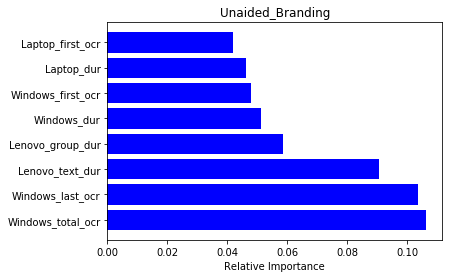

Brand_Cues__Mean
Feature ranking:
Male_dur
Windows_last_ocr
Laptop_total_ocr
microsoft_last_ocr
microsoft_first_ocr
Laptop_first_ocr
Female_dur
Age: 15-24_dur
microsoft_total_ocr
African_dur
Happiness_dur
Age: 25-34_dur
Neutral_dur
Laptop_last_ocr
microsoft_dur
Windows_first_ocr
Laptop_dur
Asus_text_dur
ASUS T102_dur
Dell_text_dur
Sadness_dur
Windows_dur
Hp_dur
Eastasian_dur
Tablet_first_ocr
Windows_total_ocr
Asus_dur
Tablet_dur
Dell_dur
Age: 35-44_dur
Lenovo_group_dur
Lenovo_text_dur
Hp_first_ocr
Hp_last_ocr
Tablet_last_ocr
Dell_sub_brand_group_dur
Hp_text_first_ocr
Tablet_total_ocr
length_of_ad_15
Hp_total_ocr
HP_group_dur
Yoga_dur
Hp_text_last_ocr
Hp_text_dur
Hp_text_total_ocr
Surface_group_dur
Currys PCs world_text_dur
Apple_dur
Macbook_group_dur


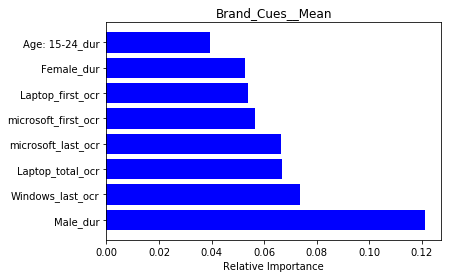

Aided_Branding__Mean
Feature ranking:
Windows_last_ocr
microsoft_last_ocr
Windows_first_ocr
Male_dur
Happiness_dur
microsoft_dur
ASUS T102_dur
Age: 25-34_dur
Windows_dur
Laptop_dur
Asus_text_dur
microsoft_first_ocr
Hp_text_total_ocr
Female_dur
Hp_text_dur
Age: 35-44_dur
Hp_text_first_ocr
Windows_total_ocr
Sadness_dur
Laptop_first_ocr
Age: 15-24_dur
Neutral_dur
Laptop_last_ocr
Hp_text_last_ocr
Laptop_total_ocr
Tablet_first_ocr
Tablet_last_ocr
Eastasian_dur
Tablet_dur
African_dur
Tablet_total_ocr
Lenovo_text_dur
length_of_ad_15
microsoft_total_ocr
Hp_dur
Yoga_dur
Surface_group_dur
Dell_text_dur
Hp_total_ocr
Dell_dur
Hp_last_ocr
Dell_sub_brand_group_dur
Lenovo_group_dur
Hp_first_ocr
HP_group_dur
Asus_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


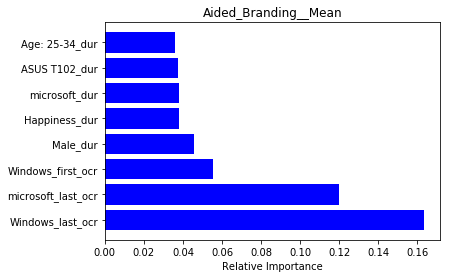

Active_Involvement__Mean
Feature ranking:
African_dur
Laptop_last_ocr
microsoft_first_ocr
microsoft_dur
Age: 25-34_dur
Laptop_dur
microsoft_last_ocr
Neutral_dur
Laptop_total_ocr
Windows_last_ocr
Hp_first_ocr
Laptop_first_ocr
Male_dur
Happiness_dur
Female_dur
Windows_dur
Eastasian_dur
Sadness_dur
Age: 35-44_dur
microsoft_total_ocr
Windows_first_ocr
Dell_sub_brand_group_dur
Tablet_dur
Dell_text_dur
Hp_dur
Windows_total_ocr
Hp_text_first_ocr
Hp_text_last_ocr
Tablet_last_ocr
Hp_last_ocr
Hp_text_dur
Age: 15-24_dur
Tablet_total_ocr
Dell_dur
Tablet_first_ocr
Hp_total_ocr
Lenovo_text_dur
Lenovo_group_dur
Hp_text_total_ocr
length_of_ad_15
Yoga_dur
Asus_text_dur
ASUS T102_dur
Surface_group_dur
HP_group_dur
Asus_dur
Currys PCs world_text_dur
Apple_dur
Macbook_group_dur


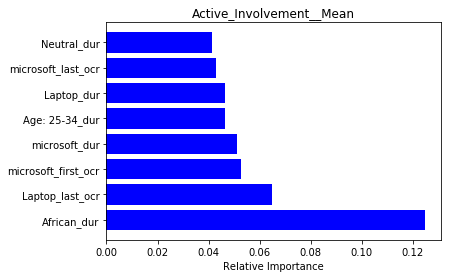

New_Information__Mean
Feature ranking:
microsoft_last_ocr
Laptop_last_ocr
Lenovo_text_dur
Laptop_first_ocr
Laptop_total_ocr
microsoft_first_ocr
Neutral_dur
Laptop_dur
Happiness_dur
Windows_last_ocr
Yoga_dur
Lenovo_group_dur
Eastasian_dur
microsoft_total_ocr
Female_dur
Age: 35-44_dur
Hp_last_ocr
African_dur
Windows_first_ocr
microsoft_dur
Age: 25-34_dur
Male_dur
Windows_dur
Windows_total_ocr
Sadness_dur
Hp_total_ocr
Age: 15-24_dur
Hp_dur
Dell_sub_brand_group_dur
Hp_text_last_ocr
ASUS T102_dur
Hp_first_ocr
Hp_text_dur
Hp_text_first_ocr
Asus_text_dur
Tablet_first_ocr
Tablet_dur
Dell_dur
Hp_text_total_ocr
Tablet_total_ocr
Dell_text_dur
Tablet_last_ocr
length_of_ad_15
Asus_dur
Surface_group_dur
HP_group_dur
Apple_dur
Macbook_group_dur
Currys PCs world_text_dur


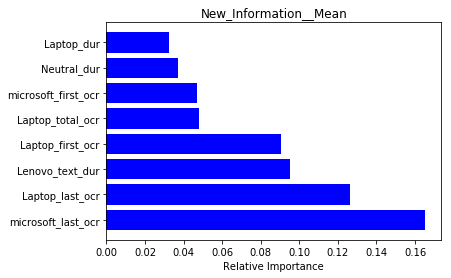

Enjoyment__Mean
Feature ranking:
Windows_last_ocr
microsoft_last_ocr
Windows_first_ocr
Happiness_dur
length_of_ad_15
Laptop_last_ocr
Laptop_first_ocr
Laptop_dur
microsoft_first_ocr
Laptop_total_ocr
microsoft_dur
Male_dur
Neutral_dur
Lenovo_text_dur
microsoft_total_ocr
Age: 15-24_dur
Hp_last_ocr
Sadness_dur
Yoga_dur
Dell_sub_brand_group_dur
Female_dur
Windows_dur
Eastasian_dur
Lenovo_group_dur
Windows_total_ocr
Hp_first_ocr
Age: 35-44_dur
African_dur
Surface_group_dur
Age: 25-34_dur
Hp_dur
Hp_total_ocr
Tablet_total_ocr
Hp_text_dur
Tablet_dur
Tablet_first_ocr
Tablet_last_ocr
Hp_text_total_ocr
Hp_text_last_ocr
Hp_text_first_ocr
HP_group_dur
Asus_text_dur
Dell_dur
Dell_text_dur
ASUS T102_dur
Asus_dur
Currys PCs world_text_dur
Macbook_group_dur
Apple_dur


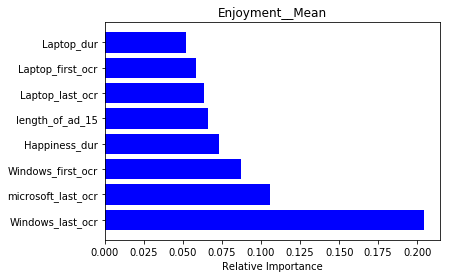

Brand_Appeal__Mean
Feature ranking:
Windows_last_ocr
Laptop_last_ocr
microsoft_first_ocr
Windows_first_ocr
microsoft_last_ocr
Laptop_first_ocr
Neutral_dur
Windows_dur
Happiness_dur
Laptop_total_ocr
Male_dur
microsoft_dur
Yoga_dur
Lenovo_group_dur
Age: 35-44_dur
Lenovo_text_dur
Hp_dur
length_of_ad_15
Laptop_dur
Sadness_dur
Windows_total_ocr
Female_dur
microsoft_total_ocr
Hp_total_ocr
Age: 15-24_dur
African_dur
Hp_last_ocr
Age: 25-34_dur
Asus_text_dur
Eastasian_dur
Tablet_dur
Hp_text_first_ocr
ASUS T102_dur
Hp_first_ocr
Hp_text_last_ocr
Dell_sub_brand_group_dur
Tablet_first_ocr
Surface_group_dur
Hp_text_dur
Hp_text_total_ocr
Tablet_last_ocr
Asus_dur
Tablet_total_ocr
Dell_dur
Dell_text_dur
HP_group_dur
Apple_dur
Currys PCs world_text_dur
Macbook_group_dur


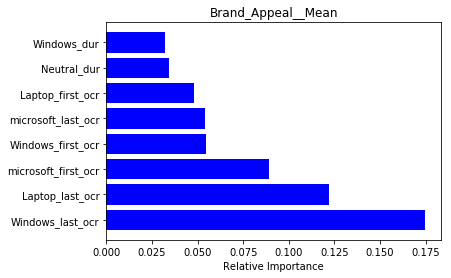

Understanding__Mean
Feature ranking:
Male_dur
Female_dur
microsoft_last_ocr
Neutral_dur
microsoft_first_ocr
microsoft_dur
Windows_dur
Laptop_first_ocr
Windows_last_ocr
Windows_first_ocr
Happiness_dur
Hp_text_dur
microsoft_total_ocr
Laptop_dur
Hp_text_first_ocr
Hp_text_total_ocr
African_dur
Laptop_last_ocr
Sadness_dur
Hp_text_last_ocr
Laptop_total_ocr
Age: 25-34_dur
Age: 35-44_dur
Hp_dur
Eastasian_dur
Windows_total_ocr
Hp_first_ocr
Age: 15-24_dur
Hp_last_ocr
Lenovo_text_dur
Hp_total_ocr
Tablet_dur
Lenovo_group_dur
Asus_text_dur
length_of_ad_15
Dell_text_dur
Tablet_first_ocr
Tablet_total_ocr
Dell_dur
ASUS T102_dur
Tablet_last_ocr
Asus_dur
Surface_group_dur
Dell_sub_brand_group_dur
Yoga_dur
HP_group_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


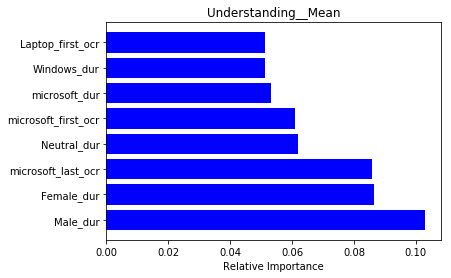

Relevance_of_Information__Mean
Feature ranking:
microsoft_last_ocr
Windows_last_ocr
Windows_first_ocr
length_of_ad_15
Laptop_last_ocr
Happiness_dur
microsoft_first_ocr
Laptop_first_ocr
Laptop_total_ocr
Neutral_dur
microsoft_dur
Laptop_dur
Age: 15-24_dur
Asus_text_dur
Age: 25-34_dur
Eastasian_dur
ASUS T102_dur
Age: 35-44_dur
Asus_dur
Male_dur
Windows_dur
Hp_text_total_ocr
Female_dur
African_dur
Hp_first_ocr
Windows_total_ocr
Hp_text_dur
Sadness_dur
Hp_total_ocr
microsoft_total_ocr
Hp_text_last_ocr
Hp_last_ocr
Hp_dur
Surface_group_dur
Hp_text_first_ocr
Lenovo_group_dur
Dell_sub_brand_group_dur
Dell_dur
Tablet_total_ocr
Lenovo_text_dur
Tablet_dur
Tablet_last_ocr
Tablet_first_ocr
HP_group_dur
Yoga_dur
Dell_text_dur
Apple_dur
Macbook_group_dur
Currys PCs world_text_dur


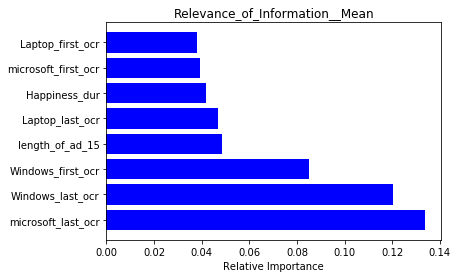

Credibility_of_Information__Mean
Feature ranking:
Laptop_last_ocr
Laptop_first_ocr
Laptop_total_ocr
microsoft_last_ocr
Neutral_dur
microsoft_dur
Happiness_dur
microsoft_first_ocr
Windows_dur
Windows_first_ocr
Windows_last_ocr
Female_dur
Laptop_dur
Male_dur
Hp_text_dur
Age: 25-34_dur
Dell_text_dur
microsoft_total_ocr
Windows_total_ocr
Tablet_dur
Sadness_dur
Hp_dur
Dell_sub_brand_group_dur
Tablet_total_ocr
Hp_text_last_ocr
Hp_last_ocr
Tablet_first_ocr
Eastasian_dur
Hp_text_total_ocr
Lenovo_group_dur
Hp_text_first_ocr
African_dur
Hp_first_ocr
Lenovo_text_dur
Hp_total_ocr
Age: 35-44_dur
Age: 15-24_dur
Dell_dur
length_of_ad_15
Tablet_last_ocr
Yoga_dur
ASUS T102_dur
Asus_text_dur
Surface_group_dur
Asus_dur
HP_group_dur
Apple_dur
Macbook_group_dur
Currys PCs world_text_dur


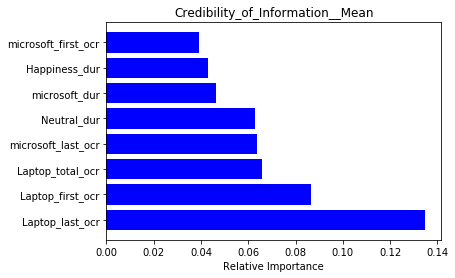

Brand_Difference__Mean
Feature ranking:
microsoft_last_ocr
Laptop_last_ocr
Windows_last_ocr
Laptop_first_ocr
microsoft_first_ocr
Windows_first_ocr
Neutral_dur
Happiness_dur
Dell_text_dur
Laptop_dur
Laptop_total_ocr
Age: 25-34_dur
length_of_ad_15
Age: 15-24_dur
Tablet_total_ocr
Eastasian_dur
Age: 35-44_dur
Tablet_dur
African_dur
microsoft_dur
Sadness_dur
Tablet_first_ocr
Tablet_last_ocr
microsoft_total_ocr
Female_dur
Dell_sub_brand_group_dur
Windows_dur
Male_dur
Dell_dur
Hp_text_dur
Windows_total_ocr
Hp_total_ocr
ASUS T102_dur
Hp_text_first_ocr
Hp_last_ocr
Asus_text_dur
Hp_text_last_ocr
Lenovo_text_dur
Hp_first_ocr
Asus_dur
Hp_dur
Lenovo_group_dur
HP_group_dur
Hp_text_total_ocr
Surface_group_dur
Yoga_dur
Apple_dur
Currys PCs world_text_dur
Macbook_group_dur


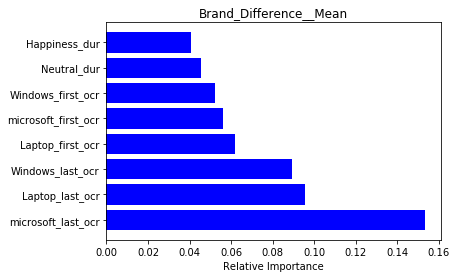

Interest_peak
Feature ranking:
Dell_text_dur
Windows_first_ocr
microsoft_first_ocr
Windows_last_ocr
Laptop_total_ocr
Happiness_dur
Neutral_dur
microsoft_last_ocr
Age: 15-24_dur
Laptop_first_ocr
microsoft_dur
Laptop_dur
Female_dur
Eastasian_dur
Laptop_last_ocr
microsoft_total_ocr
Age: 25-34_dur
Male_dur
Sadness_dur
length_of_ad_15
Dell_dur
Tablet_total_ocr
Windows_dur
Hp_last_ocr
Hp_total_ocr
Age: 35-44_dur
Hp_dur
African_dur
Tablet_dur
Windows_total_ocr
Hp_first_ocr
Tablet_last_ocr
Asus_text_dur
HP_group_dur
Tablet_first_ocr
Hp_text_dur
ASUS T102_dur
Lenovo_text_dur
Dell_sub_brand_group_dur
Lenovo_group_dur
Hp_text_first_ocr
Hp_text_total_ocr
Surface_group_dur
Asus_dur
Hp_text_last_ocr
Yoga_dur
Apple_dur
Macbook_group_dur
Currys PCs world_text_dur


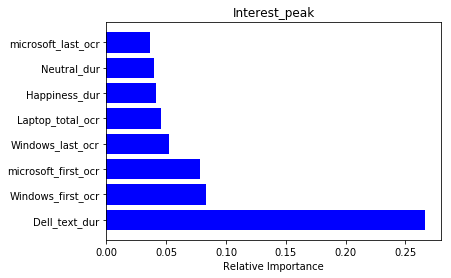

Interest_mean_score
Feature ranking:
Windows_last_ocr
Windows_first_ocr
microsoft_last_ocr
Windows_dur
microsoft_first_ocr
microsoft_dur
length_of_ad_15
Hp_text_dur
Laptop_last_ocr
Laptop_dur
Laptop_first_ocr
Laptop_total_ocr
Eastasian_dur
Happiness_dur
Hp_dur
Dell_text_dur
Hp_text_first_ocr
Neutral_dur
Hp_total_ocr
Age: 25-34_dur
Hp_text_total_ocr
Female_dur
Male_dur
Hp_text_last_ocr
Hp_first_ocr
microsoft_total_ocr
Hp_last_ocr
Tablet_first_ocr
African_dur
Tablet_dur
Sadness_dur
Tablet_last_ocr
Dell_sub_brand_group_dur
Age: 35-44_dur
Tablet_total_ocr
Lenovo_group_dur
Age: 15-24_dur
Lenovo_text_dur
Windows_total_ocr
Dell_dur
Surface_group_dur
Yoga_dur
Asus_text_dur
ASUS T102_dur
Asus_dur
HP_group_dur
Apple_dur
Currys PCs world_text_dur
Macbook_group_dur


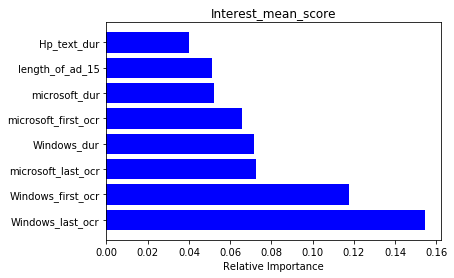

Purchase_intent
Feature ranking:
Dell_sub_brand_group_dur
Dell_text_dur
microsoft_dur
microsoft_last_ocr
Windows_last_ocr
Laptop_last_ocr
Dell_dur
microsoft_first_ocr
microsoft_total_ocr
Laptop_total_ocr
Windows_first_ocr
Laptop_dur
Happiness_dur
Hp_first_ocr
Laptop_first_ocr
Neutral_dur
Sadness_dur
Hp_text_last_ocr
Hp_last_ocr
Female_dur
Age: 25-34_dur
Hp_text_first_ocr
Male_dur
Eastasian_dur
Windows_dur
African_dur
Tablet_dur
Windows_total_ocr
Hp_total_ocr
Hp_dur
Age: 15-24_dur
Tablet_total_ocr
Lenovo_group_dur
Age: 35-44_dur
Tablet_first_ocr
Tablet_last_ocr
length_of_ad_15
ASUS T102_dur
Hp_text_total_ocr
Hp_text_dur
Yoga_dur
Asus_text_dur
Surface_group_dur
Lenovo_text_dur
HP_group_dur
Asus_dur
Apple_dur
Currys PCs world_text_dur
Macbook_group_dur


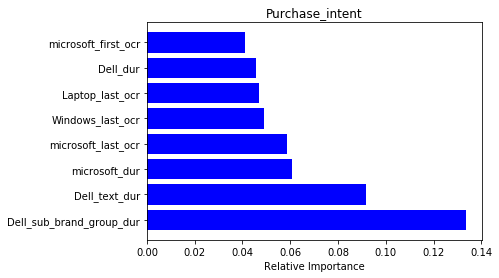

Persuasion_mean
Feature ranking:
Dell_text_dur
microsoft_first_ocr
Dell_dur
Laptop_last_ocr
Happiness_dur
Neutral_dur
Sadness_dur
microsoft_dur
Lenovo_group_dur
Laptop_total_ocr
Laptop_dur
Eastasian_dur
Windows_first_ocr
Windows_last_ocr
Laptop_first_ocr
Lenovo_text_dur
Male_dur
Age: 25-34_dur
microsoft_total_ocr
microsoft_last_ocr
Hp_last_ocr
African_dur
Yoga_dur
Windows_dur
Hp_first_ocr
ASUS T102_dur
Female_dur
Asus_dur
Hp_dur
Tablet_first_ocr
Hp_total_ocr
Asus_text_dur
Age: 35-44_dur
Age: 15-24_dur
Hp_text_last_ocr
Dell_sub_brand_group_dur
Tablet_total_ocr
Tablet_last_ocr
length_of_ad_15
Hp_text_first_ocr
HP_group_dur
Tablet_dur
Surface_group_dur
Hp_text_dur
Windows_total_ocr
Hp_text_total_ocr
Apple_dur
Macbook_group_dur
Currys PCs world_text_dur


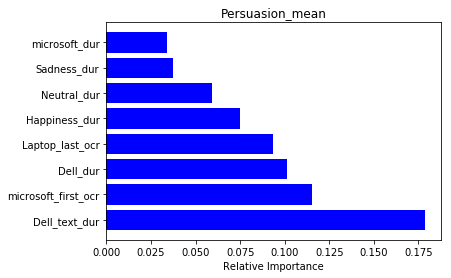

Persuasion_very_likely
Feature ranking:
Dell_text_dur
Laptop_last_ocr
Neutral_dur
Dell_dur
microsoft_first_ocr
Happiness_dur
Age: 35-44_dur
Age: 25-34_dur
Laptop_first_ocr
Male_dur
Laptop_dur
Female_dur
Lenovo_group_dur
Sadness_dur
Laptop_total_ocr
Windows_first_ocr
Dell_sub_brand_group_dur
Windows_dur
microsoft_last_ocr
microsoft_dur
African_dur
microsoft_total_ocr
Eastasian_dur
Windows_last_ocr
Age: 15-24_dur
Hp_first_ocr
Hp_total_ocr
Tablet_first_ocr
Hp_last_ocr
Tablet_dur
Hp_dur
Lenovo_text_dur
ASUS T102_dur
Tablet_total_ocr
Yoga_dur
Asus_text_dur
Hp_text_total_ocr
Tablet_last_ocr
Asus_dur
Hp_text_dur
Hp_text_last_ocr
Hp_text_first_ocr
Windows_total_ocr
HP_group_dur
length_of_ad_15
Surface_group_dur
Apple_dur
Currys PCs world_text_dur
Macbook_group_dur


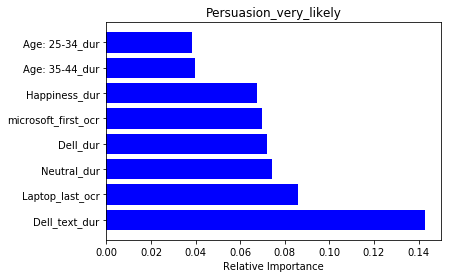

Interest_peak_frames
Feature ranking:
Dell_text_dur
Windows_first_ocr
microsoft_first_ocr
Windows_last_ocr
Neutral_dur
Laptop_total_ocr
Happiness_dur
microsoft_last_ocr
Laptop_first_ocr
Age: 15-24_dur
Laptop_dur
microsoft_dur
Female_dur
Eastasian_dur
Laptop_last_ocr
Age: 25-34_dur
Male_dur
Dell_dur
microsoft_total_ocr
Sadness_dur
length_of_ad_15
Windows_dur
Hp_total_ocr
Tablet_total_ocr
Hp_last_ocr
Tablet_dur
Age: 35-44_dur
Hp_dur
Windows_total_ocr
Hp_first_ocr
African_dur
Tablet_last_ocr
Tablet_first_ocr
ASUS T102_dur
HP_group_dur
Asus_text_dur
Hp_text_dur
Dell_sub_brand_group_dur
Lenovo_group_dur
Lenovo_text_dur
Hp_text_total_ocr
Hp_text_first_ocr
Hp_text_last_ocr
Asus_dur
Surface_group_dur
Yoga_dur
Apple_dur
Macbook_group_dur
Currys PCs world_text_dur


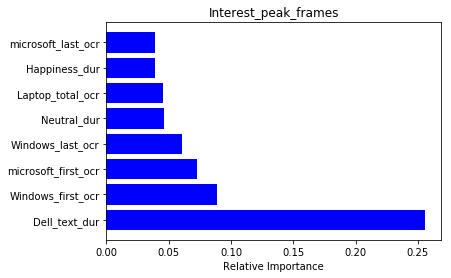

Enjoyment_vey_much
Feature ranking:
Windows_last_ocr
microsoft_last_ocr
Windows_first_ocr
microsoft_first_ocr
Laptop_last_ocr
Laptop_dur
length_of_ad_15
Laptop_total_ocr
Happiness_dur
microsoft_total_ocr
Neutral_dur
Male_dur
Sadness_dur
Laptop_first_ocr
microsoft_dur
Age: 25-34_dur
Lenovo_text_dur
Age: 35-44_dur
Eastasian_dur
Female_dur
Yoga_dur
Hp_last_ocr
African_dur
Windows_dur
Tablet_first_ocr
Dell_text_dur
Tablet_dur
Hp_first_ocr
Lenovo_group_dur
Age: 15-24_dur
Hp_text_first_ocr
Dell_dur
Windows_total_ocr
Hp_text_last_ocr
Hp_total_ocr
Tablet_total_ocr
Hp_dur
Hp_text_dur
Tablet_last_ocr
Dell_sub_brand_group_dur
Asus_text_dur
ASUS T102_dur
Hp_text_total_ocr
Asus_dur
HP_group_dur
Surface_group_dur
Apple_dur
Macbook_group_dur
Currys PCs world_text_dur


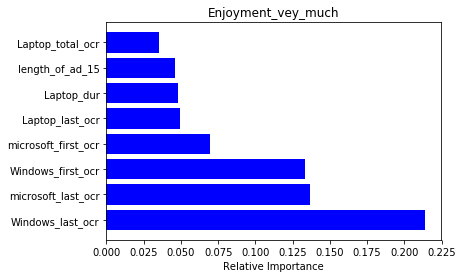

Aided_Branding_almost_anything
Feature ranking:
Age: 25-34_dur
Laptop_first_ocr
microsoft_last_ocr
microsoft_dur
Windows_first_ocr
Male_dur
Laptop_total_ocr
Neutral_dur
Laptop_dur
Happiness_dur
Windows_last_ocr
Sadness_dur
Windows_dur
Age: 35-44_dur
microsoft_first_ocr
Laptop_last_ocr
Female_dur
Eastasian_dur
Age: 15-24_dur
Hp_text_dur
Hp_text_total_ocr
Dell_dur
African_dur
microsoft_total_ocr
Asus_text_dur
Surface_group_dur
Windows_total_ocr
ASUS T102_dur
Hp_text_first_ocr
Hp_last_ocr
Lenovo_group_dur
Hp_text_last_ocr
Hp_first_ocr
Hp_dur
Hp_total_ocr
Tablet_dur
Lenovo_text_dur
Tablet_total_ocr
Tablet_first_ocr
Tablet_last_ocr
Asus_dur
Dell_sub_brand_group_dur
HP_group_dur
length_of_ad_15
Dell_text_dur
Yoga_dur
Apple_dur
Macbook_group_dur
Currys PCs world_text_dur


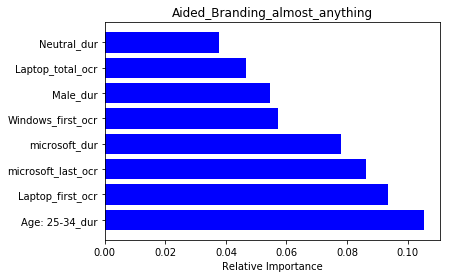

Brand_Cues_very_easily
Feature ranking:
Windows_last_ocr
microsoft_last_ocr
microsoft_first_ocr
Laptop_last_ocr
Laptop_first_ocr
Neutral_dur
Male_dur
Happiness_dur
Laptop_total_ocr
African_dur
Dell_text_dur
Female_dur
Age: 25-34_dur
Windows_first_ocr
Windows_dur
microsoft_dur
Sadness_dur
Laptop_dur
Eastasian_dur
Age: 15-24_dur
Age: 35-44_dur
Dell_dur
Dell_sub_brand_group_dur
microsoft_total_ocr
ASUS T102_dur
Hp_text_first_ocr
Asus_text_dur
Hp_total_ocr
Lenovo_group_dur
Hp_last_ocr
Hp_first_ocr
Tablet_first_ocr
Hp_dur
Lenovo_text_dur
Tablet_total_ocr
Yoga_dur
Hp_text_last_ocr
Hp_text_total_ocr
Hp_text_dur
Tablet_dur
Windows_total_ocr
Tablet_last_ocr
Surface_group_dur
HP_group_dur
Asus_dur
length_of_ad_15
Currys PCs world_text_dur
Apple_dur
Macbook_group_dur


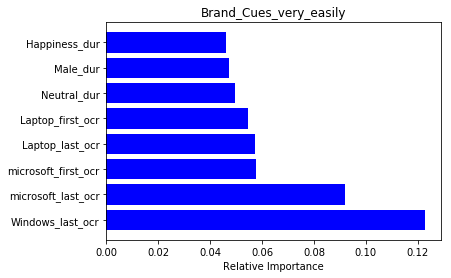

Brand_Appeal_more_appealing
Feature ranking:
Windows_last_ocr
microsoft_last_ocr
microsoft_first_ocr
Windows_first_ocr
Neutral_dur
Laptop_last_ocr
length_of_ad_15
Laptop_total_ocr
Lenovo_text_dur
Yoga_dur
Happiness_dur
Lenovo_group_dur
Windows_total_ocr
Laptop_first_ocr
African_dur
Age: 35-44_dur
microsoft_dur
Male_dur
Laptop_dur
Female_dur
Hp_total_ocr
Hp_dur
Hp_text_first_ocr
ASUS T102_dur
Hp_last_ocr
microsoft_total_ocr
Age: 25-34_dur
Windows_dur
Age: 15-24_dur
Hp_text_last_ocr
Eastasian_dur
Asus_text_dur
Sadness_dur
Tablet_dur
Tablet_first_ocr
Dell_dur
Dell_sub_brand_group_dur
Asus_dur
Surface_group_dur
Tablet_total_ocr
Hp_first_ocr
Tablet_last_ocr
Dell_text_dur
Hp_text_dur
Hp_text_total_ocr
HP_group_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


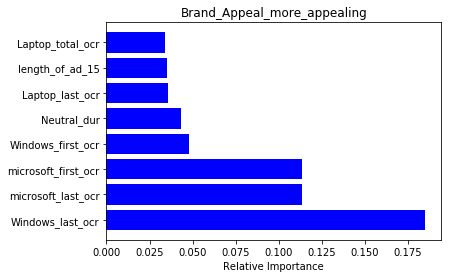

Understanding_very_easily
Feature ranking:
Male_dur
Female_dur
Neutral_dur
microsoft_last_ocr
microsoft_first_ocr
Windows_first_ocr
Windows_last_ocr
microsoft_total_ocr
microsoft_dur
Happiness_dur
Sadness_dur
Laptop_total_ocr
Laptop_first_ocr
Age: 25-34_dur
Laptop_dur
Hp_dur
African_dur
Windows_dur
Windows_total_ocr
Age: 35-44_dur
Hp_first_ocr
Age: 15-24_dur
Dell_text_dur
Hp_last_ocr
Laptop_last_ocr
Eastasian_dur
Hp_total_ocr
Tablet_first_ocr
Lenovo_text_dur
Hp_text_first_ocr
Hp_text_last_ocr
Tablet_last_ocr
length_of_ad_15
Tablet_total_ocr
Dell_dur
Hp_text_dur
Asus_dur
Lenovo_group_dur
Hp_text_total_ocr
Tablet_dur
Asus_text_dur
ASUS T102_dur
Surface_group_dur
HP_group_dur
Yoga_dur
Dell_sub_brand_group_dur
Apple_dur
Macbook_group_dur
Currys PCs world_text_dur


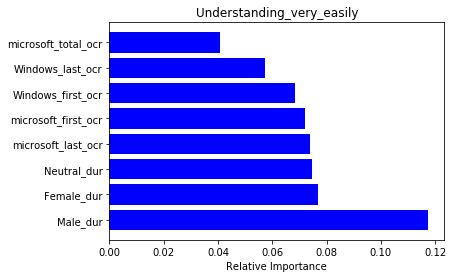

Relevance_Information_very_relevant
Feature ranking:
microsoft_last_ocr
Windows_last_ocr
microsoft_first_ocr
Happiness_dur
Laptop_total_ocr
Windows_first_ocr
Neutral_dur
Age: 35-44_dur
Laptop_first_ocr
Age: 25-34_dur
Laptop_dur
Laptop_last_ocr
ASUS T102_dur
Asus_text_dur
Windows_dur
microsoft_dur
Male_dur
Eastasian_dur
Windows_total_ocr
Hp_text_total_ocr
African_dur
length_of_ad_15
Age: 15-24_dur
Female_dur
Hp_text_dur
Hp_text_last_ocr
microsoft_total_ocr
Lenovo_group_dur
Asus_dur
Tablet_total_ocr
Dell_dur
Hp_text_first_ocr
Tablet_first_ocr
Sadness_dur
Hp_total_ocr
Hp_first_ocr
Surface_group_dur
Yoga_dur
Hp_last_ocr
Hp_dur
Lenovo_text_dur
Tablet_dur
Dell_text_dur
Tablet_last_ocr
Dell_sub_brand_group_dur
HP_group_dur
Currys PCs world_text_dur
Macbook_group_dur
Apple_dur


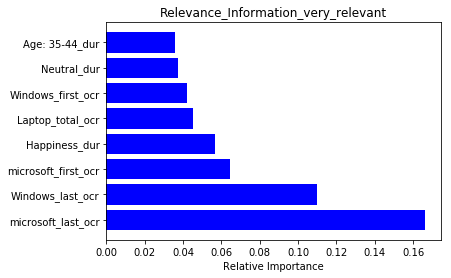

Credibility_Information_agree_strongly
Feature ranking:
microsoft_last_ocr
Neutral_dur
Laptop_last_ocr
microsoft_dur
Laptop_total_ocr
Happiness_dur
microsoft_first_ocr
Tablet_total_ocr
Windows_first_ocr
Windows_dur
Tablet_first_ocr
Laptop_dur
Tablet_dur
Laptop_first_ocr
microsoft_total_ocr
Tablet_last_ocr
Age: 25-34_dur
Sadness_dur
Male_dur
Female_dur
Eastasian_dur
Hp_text_dur
Windows_last_ocr
Dell_sub_brand_group_dur
Hp_last_ocr
Dell_text_dur
Lenovo_group_dur
Hp_first_ocr
Hp_total_ocr
African_dur
Hp_text_first_ocr
Hp_dur
Hp_text_last_ocr
Windows_total_ocr
Hp_text_total_ocr
Age: 15-24_dur
Age: 35-44_dur
Dell_dur
Lenovo_text_dur
Yoga_dur
Asus_text_dur
ASUS T102_dur
HP_group_dur
Asus_dur
length_of_ad_15
Surface_group_dur
Apple_dur
Macbook_group_dur
Currys PCs world_text_dur


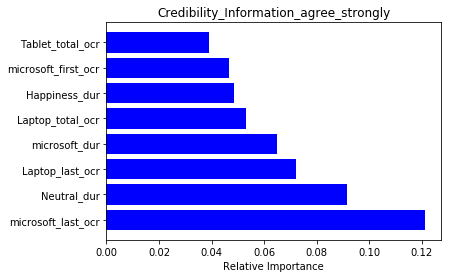

New_Information_alot
Feature ranking:
microsoft_last_ocr
Laptop_last_ocr
Windows_last_ocr
Laptop_total_ocr
Happiness_dur
Age: 25-34_dur
Windows_first_ocr
microsoft_first_ocr
Lenovo_text_dur
Yoga_dur
Laptop_dur
Laptop_first_ocr
Age: 35-44_dur
Lenovo_group_dur
Neutral_dur
length_of_ad_15
African_dur
Tablet_total_ocr
Male_dur
microsoft_total_ocr
microsoft_dur
Eastasian_dur
Hp_total_ocr
Hp_last_ocr
Dell_text_dur
Age: 15-24_dur
Female_dur
Windows_dur
Sadness_dur
Tablet_dur
Dell_sub_brand_group_dur
Hp_dur
Tablet_last_ocr
Dell_dur
Hp_text_last_ocr
Tablet_first_ocr
Hp_text_dur
Windows_total_ocr
Hp_first_ocr
Surface_group_dur
Hp_text_total_ocr
Hp_text_first_ocr
ASUS T102_dur
Asus_text_dur
HP_group_dur
Asus_dur
Macbook_group_dur
Apple_dur
Currys PCs world_text_dur


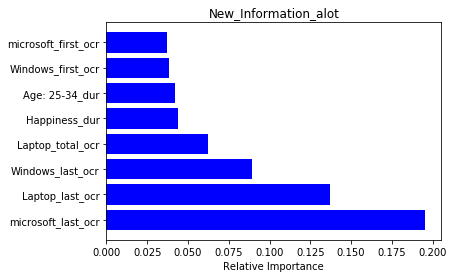

Brand_Difference_strongly
Feature ranking:
Laptop_last_ocr
microsoft_last_ocr
Age: 25-34_dur
microsoft_first_ocr
Windows_last_ocr
Neutral_dur
Happiness_dur
Laptop_total_ocr
African_dur
Dell_text_dur
Sadness_dur
Laptop_dur
Laptop_first_ocr
Age: 15-24_dur
Dell_dur
Eastasian_dur
microsoft_total_ocr
Windows_first_ocr
Hp_text_dur
microsoft_dur
Female_dur
Male_dur
Tablet_last_ocr
Tablet_first_ocr
Hp_total_ocr
Windows_total_ocr
Hp_last_ocr
Hp_first_ocr
Tablet_total_ocr
Tablet_dur
Hp_dur
Surface_group_dur
Age: 35-44_dur
Windows_dur
Lenovo_group_dur
HP_group_dur
Lenovo_text_dur
Hp_text_first_ocr
Yoga_dur
Hp_text_last_ocr
Dell_sub_brand_group_dur
ASUS T102_dur
Hp_text_total_ocr
Asus_text_dur
length_of_ad_15
Asus_dur
Currys PCs world_text_dur
Apple_dur
Macbook_group_dur


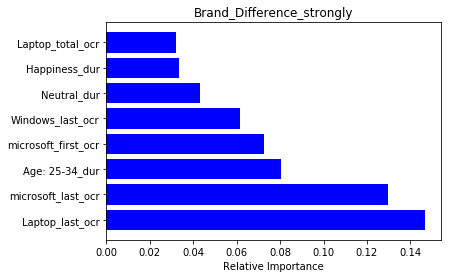

In [22]:
imp_features_rf = model.plot_feature_importance(models_17,10,y_train_17.columns,X_train_17.columns,savefig=False)

In [38]:
imp_features_rf[:,:10]

array([['Laptop_first_ocr', 'microsoft_first_ocr', 'Surface_group_dur',
        'Surface_group_last_ocr', 'Laptop_last_ocr',
        'Surface_group_first_ocr', 'Happiness_dur', 'microsoft_last_ocr',
        'Female_dur', 'Caucasian_dur'],
       ['Neutral_dur', 'African_dur', 'microsoft_first_ocr',
        'Surface_group_dur', 'Male_dur', 'Surface_group_last_ocr',
        'microsoft_total_ocr', 'Caucasian_dur', 'Tablet_first_ocr',
        'Macbook_group_dur'],
       ['microsoft_total_ocr', 'Laptop_total_ocr',
        'Surface_group_first_ocr', 'Tablet_total_ocr', 'Male_dur',
        'Surface_group_dur', 'Surface_group_last_ocr', 'Tablet_dur',
        'Neutral_dur', 'African_dur'],
       ['Laptop_dur', 'Surface_group_last_ocr', 'microsoft_first_ocr',
        'Laptop_last_ocr', 'Tablet_first_ocr', 'Laptop_total_ocr',
        'microsoft_total_ocr', 'length_of_ad_15', 'Tablet_last_ocr',
        'Caucasian_dur'],
       ['Surface_group_first_ocr', 'Surface_group_total_ocr',
        'Neutr

In [70]:
len(y_train_17.columns)

17

Unaided_Branding
Feature ranking:
microsoft_first_ocr
Laptop_first_ocr
microsoft_dur
Happiness_dur
Laptop_total_ocr
Age: 25-34_Eastasian_dur
Age: 25-34_dur
Surface_total_ocr
Surface_dur
Tablet_last_ocr
Tablet_dur
Happiness_length_of_ad_impact
African_dur
Surface Book_dur
Caucasian_dur
Laptop_dur
microsoft_last_ocr
Age: 25-34_Caucasian_dur
Male_dur
Sadness_dur
Female_dur
Laptop_last_ocr
microsoft_total_ocr
Surface_first_ocr
Happiness_Eastasian_dur
Neutral_Male_dur
Age: 35-44_Eastasian_dur
Surface_last_ocr
Happiness_Female_dur
Eastasian_dur
Neutral_dur
Tablet_total_ocr
Tablet_first_ocr
length_of_ad_15
Neutral_Age: 25-34_dur
Age: 35-44_dur
Surface Pen_dur
MacBook Air_dur
Macbook Air_dur
ad_type_tv
MacBook Pro_dur
Microsoft Surface_dur
The surface Laptop_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
Windows_dur
Surface Laptop_dur
Surface laptop_dur
Suface Laptop_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS_dur
Dell XPS 13_dur

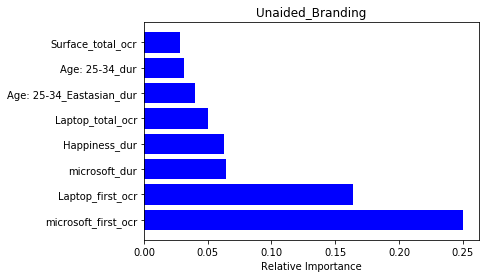

Interest_peak
Feature ranking:
Macbook Air_dur
Neutral_Male_dur
Neutral_Age: 25-34_dur
Happiness_Female_dur
Female_dur
Happiness_dur
Surface_first_ocr
Age: 25-34_dur
Surface_last_ocr
Laptop_last_ocr
Laptop_dur
Age: 25-34_Caucasian_dur
Laptop_total_ocr
Caucasian_dur
microsoft_first_ocr
Tablet_dur
Tablet_last_ocr
Surface_dur
microsoft_last_ocr
Tablet_first_ocr
Male_dur
Tablet_total_ocr
African_dur
Neutral_dur
Age: 35-44_dur
microsoft_total_ocr
Age: 25-34_Eastasian_dur
Surface_total_ocr
microsoft_dur
Laptop_first_ocr
Age: 35-44_Eastasian_dur
Happiness_length_of_ad_impact
Happiness_Eastasian_dur
Surface Book_dur
Sadness_dur
Eastasian_dur
length_of_ad_15
Surface Pen_dur
ad_type_tv
MacBook Pro_dur
MacBook Air_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
Windows_dur
The surface Laptop_dur
Surface laptop_dur
Surface Laptop_dur
Lenovo Yoga 910_dur
Suface Laptop_dur
Microsoft Surface_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS_du

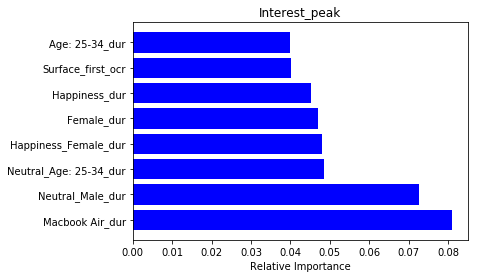

Interest_mean_score
Feature ranking:
Surface_dur
microsoft_first_ocr
Surface_total_ocr
Age: 25-34_dur
Sadness_dur
Neutral_Male_dur
microsoft_last_ocr
Laptop_first_ocr
microsoft_dur
Surface_first_ocr
Laptop_total_ocr
Caucasian_dur
Happiness_dur
Surface Book_dur
Laptop_last_ocr
Surface_last_ocr
Neutral_dur
Laptop_dur
Tablet_dur
Eastasian_dur
Neutral_Age: 25-34_dur
Female_dur
Male_dur
Tablet_first_ocr
Tablet_total_ocr
microsoft_total_ocr
African_dur
length_of_ad_15
Surface Pen_dur
Tablet_last_ocr
Macbook Air_dur
Happiness_length_of_ad_impact
Age: 25-34_Caucasian_dur
Age: 25-34_Eastasian_dur
Age: 35-44_Eastasian_dur
Age: 35-44_dur
Happiness_Eastasian_dur
MacBook Air_dur
Happiness_Female_dur
ad_type_tv
MacBook Pro_dur
Surface Laptop_dur
Windows 10_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
The surface Laptop_dur
Windows_dur
Suface Laptop_dur
ASUS T102_dur
Dell PCs_dur
Dell XPS_dur
Dell XPS 13_dur
HP Spectre x360_dur
HP Spectre x360, 

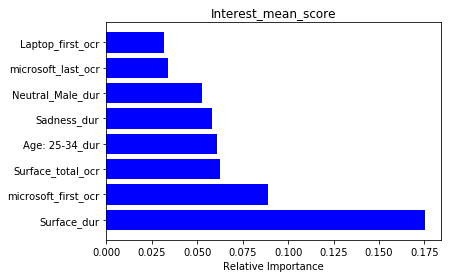

Interest_peak_frames
Feature ranking:
Macbook Air_dur
Neutral_Male_dur
Happiness_Female_dur
Neutral_Age: 25-34_dur
Female_dur
Surface_first_ocr
Age: 25-34_dur
Surface_last_ocr
Happiness_dur
Laptop_last_ocr
Laptop_dur
Laptop_total_ocr
Age: 25-34_Caucasian_dur
Caucasian_dur
microsoft_first_ocr
Tablet_dur
Tablet_last_ocr
Tablet_first_ocr
Surface_dur
microsoft_last_ocr
Male_dur
Tablet_total_ocr
Neutral_dur
African_dur
microsoft_total_ocr
Age: 35-44_dur
Age: 25-34_Eastasian_dur
microsoft_dur
Laptop_first_ocr
Surface_total_ocr
Happiness_Eastasian_dur
Surface Book_dur
Happiness_length_of_ad_impact
Age: 35-44_Eastasian_dur
Eastasian_dur
Sadness_dur
length_of_ad_15
Surface Pen_dur
MacBook Pro_dur
ad_type_tv
MacBook Air_dur
Yoga_dur
Windows 10, Windows_dur
Windows 10, HP_Spectre_dur
Windows 10 PCs_dur
Windows 10 PC_dur
Windows 10_dur
Windows_dur
The surface Laptop_dur
Surface laptop_dur
Surface Laptop_dur
Lenovo Yoga 910_dur
Suface Laptop_dur
Microsoft Surface_dur
ASUS T102_dur
Dell PCs_dur
Dell

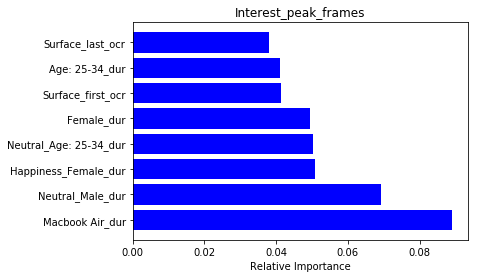

In [28]:
model.plot_feature_importance(models_4,10,y_train_4.columns,X_train_4.columns,savefig=False)

In [23]:
from tqdm import tqdm 
shap.initjs()

In [24]:
explainer=[]
shap_values=[]
for i in tqdm(range(17,26)):
    explainer.append(shap.TreeExplainer(models_17[i]))
    shap_values.append(explainer[-1].shap_values(X_train_17))
    print(i)

 11%|█         | 1/9 [00:19<02:38, 19.82s/it]

17


 22%|██▏       | 2/9 [00:38<02:15, 19.33s/it]

18


 33%|███▎      | 3/9 [00:58<01:57, 19.56s/it]

19


 44%|████▍     | 4/9 [01:18<01:39, 19.92s/it]

20


 56%|█████▌    | 5/9 [01:39<01:19, 19.99s/it]

21


 67%|██████▋   | 6/9 [01:58<00:59, 19.93s/it]

22


 78%|███████▊  | 7/9 [02:19<00:40, 20.28s/it]

23


 89%|████████▉ | 8/9 [02:39<00:20, 20.09s/it]

24


100%|██████████| 9/9 [02:59<00:00, 20.11s/it]

25


In [25]:
import matplotlib.pyplot as plt

In [26]:
len(y_train_17.columns)

26

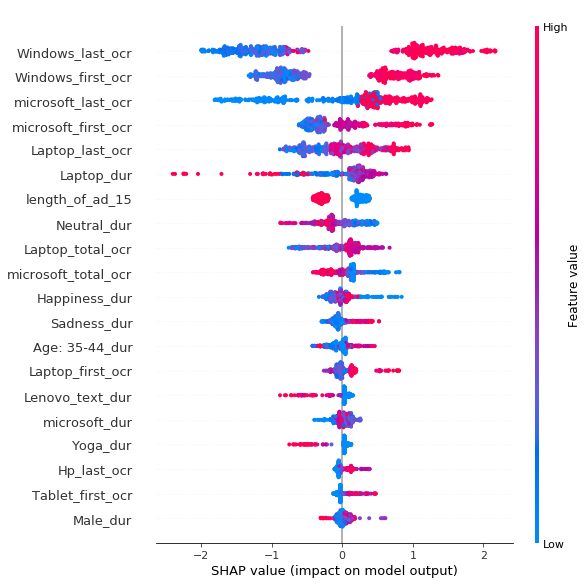

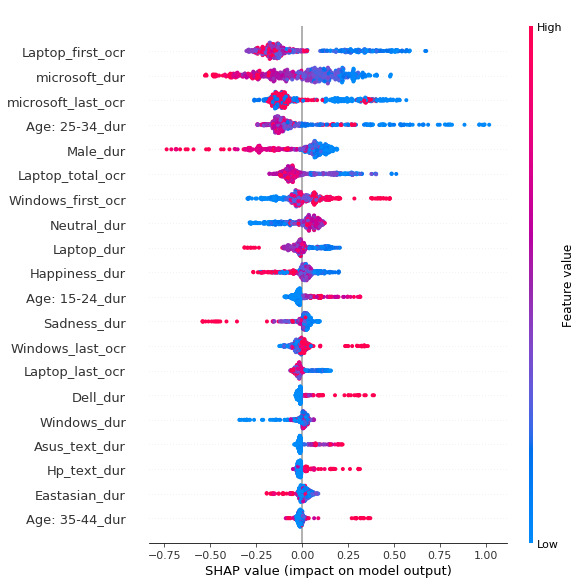

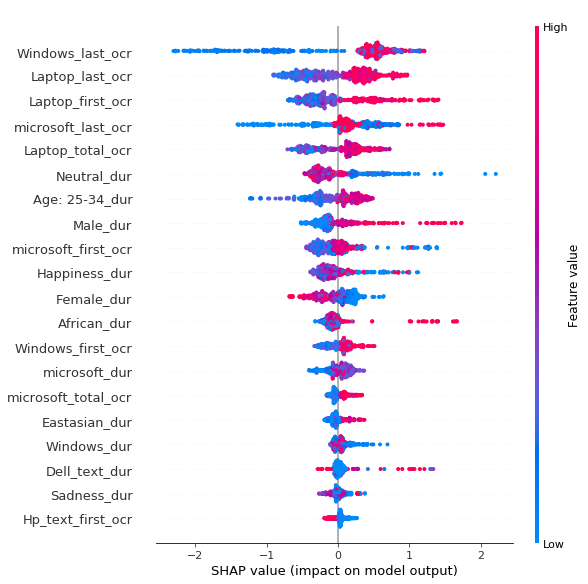

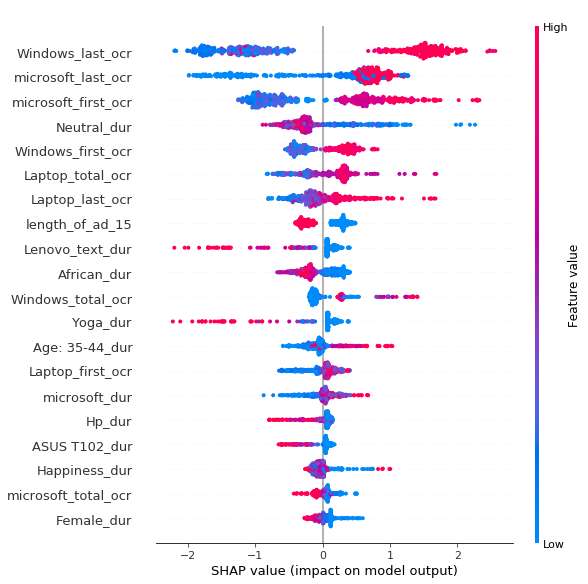

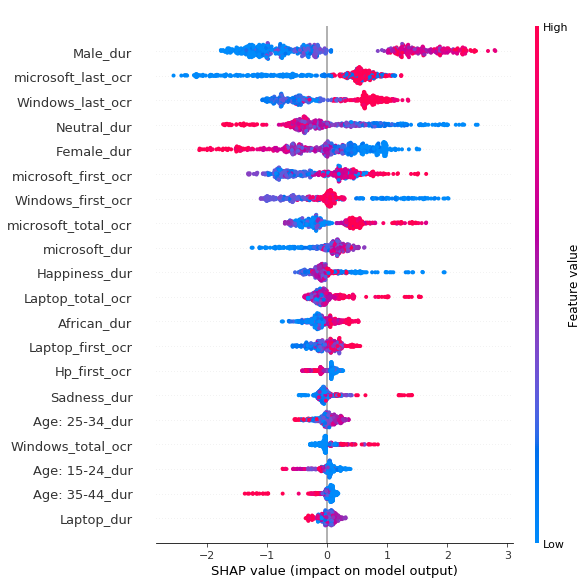

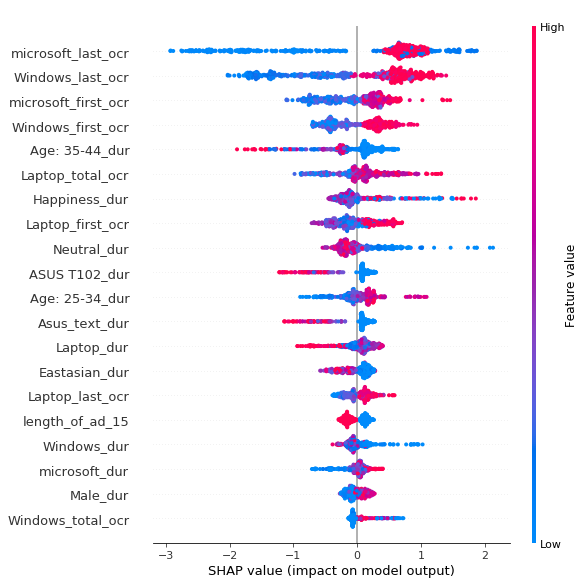

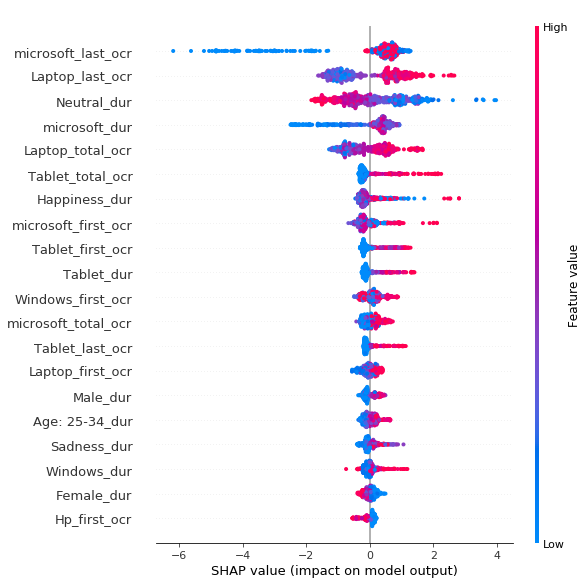

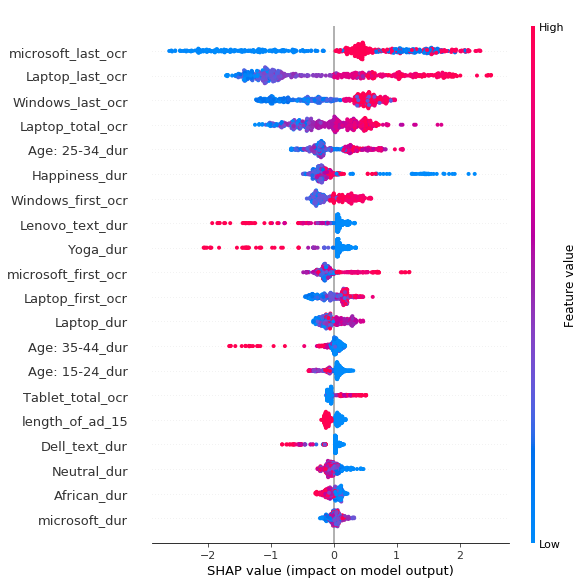

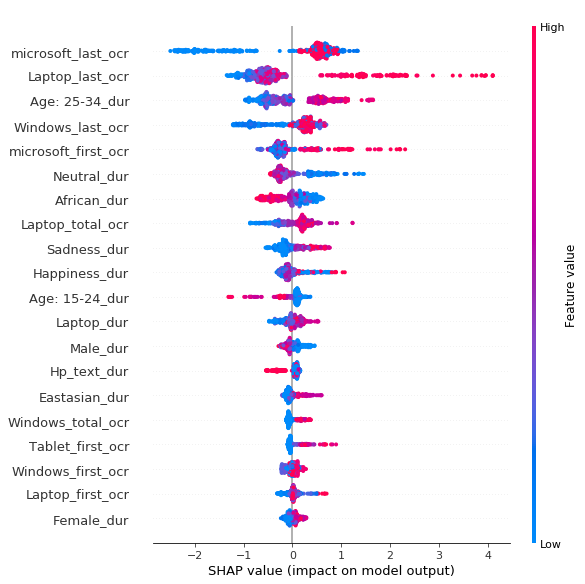

In [27]:
for i in range(9):
    plt.figure()
    shap.summary_plot(shap_values[i],X_train_17,show=False)
    plt.savefig('./WIth_new_target_variables/shap_plots_26_software/'+y_train_17.columns[17+i]+'.png',bbox_inches='tight')

In [28]:
model_xgb = Model('xgb')
print("------------------------ 17 XGB Models Training ----------------------------\n")
models_xgb_17 = model_xgb.train(X_train_17,y_train_17,X_test_17,y_test_17,metrics='r2',plot_error=False)

------------------------ 17 XGB Models Training ----------------------------

Unaided_Branding


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.6s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


For training set
r2_score: 0.982636
For test set
r2_score: 0.986764


Brand_Cues__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


For training set
r2_score: 0.947664
For test set
r2_score: 0.976033


Aided_Branding__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


For training set
r2_score: 0.962411
For test set
r2_score: 0.975872


Active_Involvement__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


For training set
r2_score: 0.956072
For test set
r2_score: 0.955307


New_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


For training set
r2_score: 0.965979
For test set
r2_score: 0.976199


Enjoyment__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


For training set
r2_score: 0.967828
For test set
r2_score: 0.972264


Brand_Appeal__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


For training set
r2_score: 0.974166
For test set
r2_score: 0.974328


Understanding__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


For training set
r2_score: 0.958170
For test set
r2_score: 0.973406


Relevance_of_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


For training set
r2_score: 0.954248
For test set
r2_score: 0.961139


Credibility_of_Information__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


For training set
r2_score: 0.957672
For test set
r2_score: 0.962222


Brand_Difference__Mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


For training set
r2_score: 0.964429
For test set
r2_score: 0.968418


Interest_peak


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.6s finished


For training set
r2_score: 0.928989
For test set
r2_score: 0.839310


Interest_mean_score


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


For training set
r2_score: 0.969428
For test set
r2_score: 0.970540


Purchase_intent


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


For training set
r2_score: 0.934448
For test set
r2_score: 0.934827


Persuasion_mean


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.3s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


For training set
r2_score: 0.905768
For test set
r2_score: 0.843862


Persuasion_very_likely


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


For training set
r2_score: 0.923926
For test set
r2_score: 0.867353


Interest_peak_frames


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


For training set
r2_score: 0.954911
For test set
r2_score: 0.892795


Enjoyment_vey_much


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


For training set
r2_score: 0.983483
For test set
r2_score: 0.981286


Aided_Branding_almost_anything


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


For training set
r2_score: 0.950802
For test set
r2_score: 0.965652


Brand_Cues_very_easily


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


For training set
r2_score: 0.956436
For test set
r2_score: 0.962419


Brand_Appeal_more_appealing


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


For training set
r2_score: 0.977357
For test set
r2_score: 0.981057


Understanding_very_easily


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


For training set
r2_score: 0.955998
For test set
r2_score: 0.972019


Relevance_Information_very_relevant


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


For training set
r2_score: 0.958776
For test set
r2_score: 0.974903


Credibility_Information_agree_strongly


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


For training set
r2_score: 0.952616
For test set
r2_score: 0.962525


New_Information_alot


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


For training set
r2_score: 0.976378
For test set
r2_score: 0.983016


Brand_Difference_strongly


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.6s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.2s finished


For training set
r2_score: 0.969537
For test set
r2_score: 0.960910




Unaided_Branding
Lenovo_text_dur
Hp_text_total_ocr
Windows_total_ocr
Yoga_dur
Hp_text_dur
Asus_text_dur
Lenovo_group_dur
Hp_text_last_ocr
Windows_last_ocr
ASUS T102_dur
Hp_text_first_ocr
Windows_dur
Dell_sub_brand_group_dur
length_of_ad_15
Windows_first_ocr
Laptop_last_ocr
Laptop_first_ocr
Asus_dur
Laptop_dur
Male_dur
Tablet_first_ocr
Dell_dur
Tablet_total_ocr
microsoft_last_ocr
Hp_last_ocr
Female_dur
microsoft_first_ocr
Tablet_dur
Tablet_last_ocr
Age: 15-24_dur
Dell_text_dur
microsoft_total_ocr
Hp_first_ocr
HP_group_dur
Happiness_dur
Laptop_total_ocr
microsoft_dur
Surface_group_dur
Hp_dur
Age: 35-44_dur
Hp_total_ocr
Eastasian_dur
Neutral_dur
Age: 25-34_dur
Sadness_dur
African_dur
Macbook_group_dur
Apple_dur
Currys PCs world_text_dur


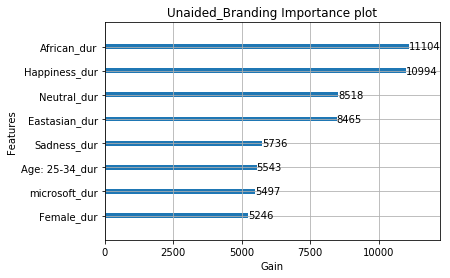

Brand_Cues__Mean
microsoft_total_ocr
Laptop_total_ocr
ASUS T102_dur
Male_dur
Asus_text_dur
Asus_dur
microsoft_last_ocr
length_of_ad_15
Age: 15-24_dur
Dell_text_dur
Windows_last_ocr
Female_dur
Laptop_first_ocr
microsoft_first_ocr
Tablet_total_ocr
Lenovo_text_dur
Tablet_first_ocr
Dell_sub_brand_group_dur
Dell_dur
Tablet_last_ocr
Hp_text_last_ocr
Windows_total_ocr
Tablet_dur
microsoft_dur
Happiness_dur
African_dur
Laptop_last_ocr
Lenovo_group_dur
Hp_dur
Windows_first_ocr
Hp_text_first_ocr
Neutral_dur
Hp_last_ocr
HP_group_dur
Laptop_dur
Hp_text_dur
Hp_first_ocr
Sadness_dur
Yoga_dur
Hp_text_total_ocr
Age: 25-34_dur
Eastasian_dur
Hp_total_ocr
Windows_dur
Age: 35-44_dur
Surface_group_dur
Apple_dur
Macbook_group_dur
Currys PCs world_text_dur


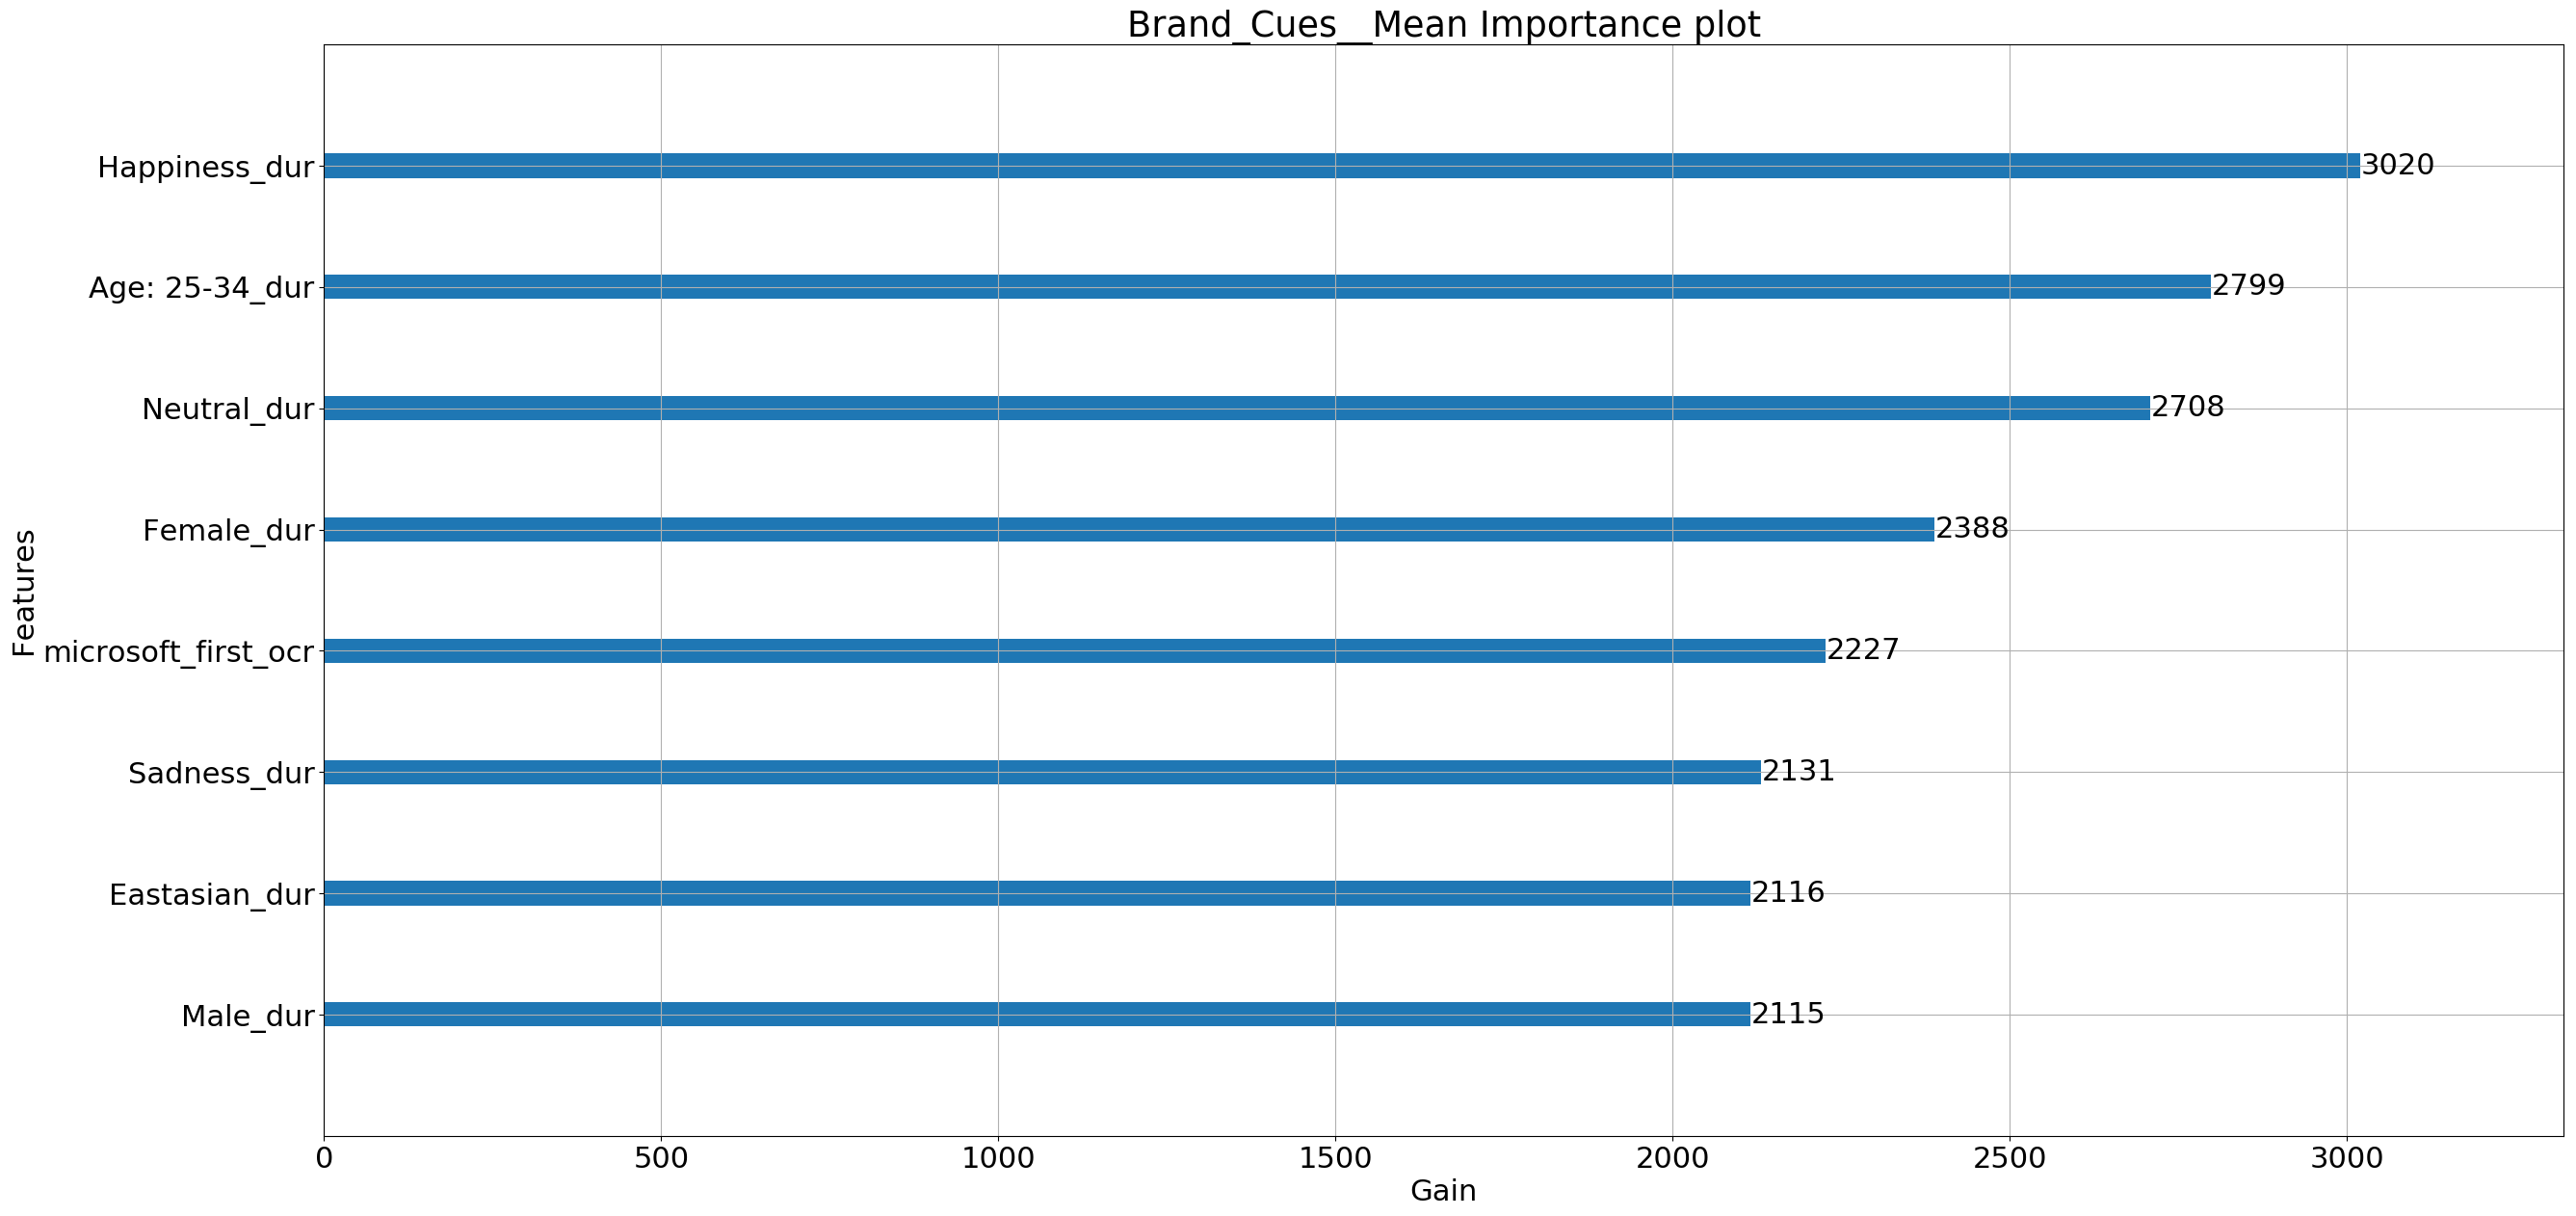

Aided_Branding__Mean
Windows_last_ocr
ASUS T102_dur
Asus_text_dur
microsoft_last_ocr
Hp_text_total_ocr
Lenovo_text_dur
Windows_total_ocr
Hp_text_first_ocr
Hp_text_dur
Hp_text_last_ocr
Tablet_total_ocr
Dell_text_dur
Age: 15-24_dur
Windows_first_ocr
length_of_ad_15
Asus_dur
Age: 35-44_dur
Male_dur
Yoga_dur
Lenovo_group_dur
Dell_dur
Tablet_first_ocr
Windows_dur
Laptop_dur
Happiness_dur
microsoft_first_ocr
Dell_sub_brand_group_dur
Laptop_last_ocr
microsoft_dur
Tablet_last_ocr
Laptop_first_ocr
Tablet_dur
Hp_total_ocr
Hp_last_ocr
Age: 25-34_dur
Laptop_total_ocr
Neutral_dur
Sadness_dur
Female_dur
Hp_first_ocr
Eastasian_dur
Surface_group_dur
microsoft_total_ocr
African_dur
Hp_dur
HP_group_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


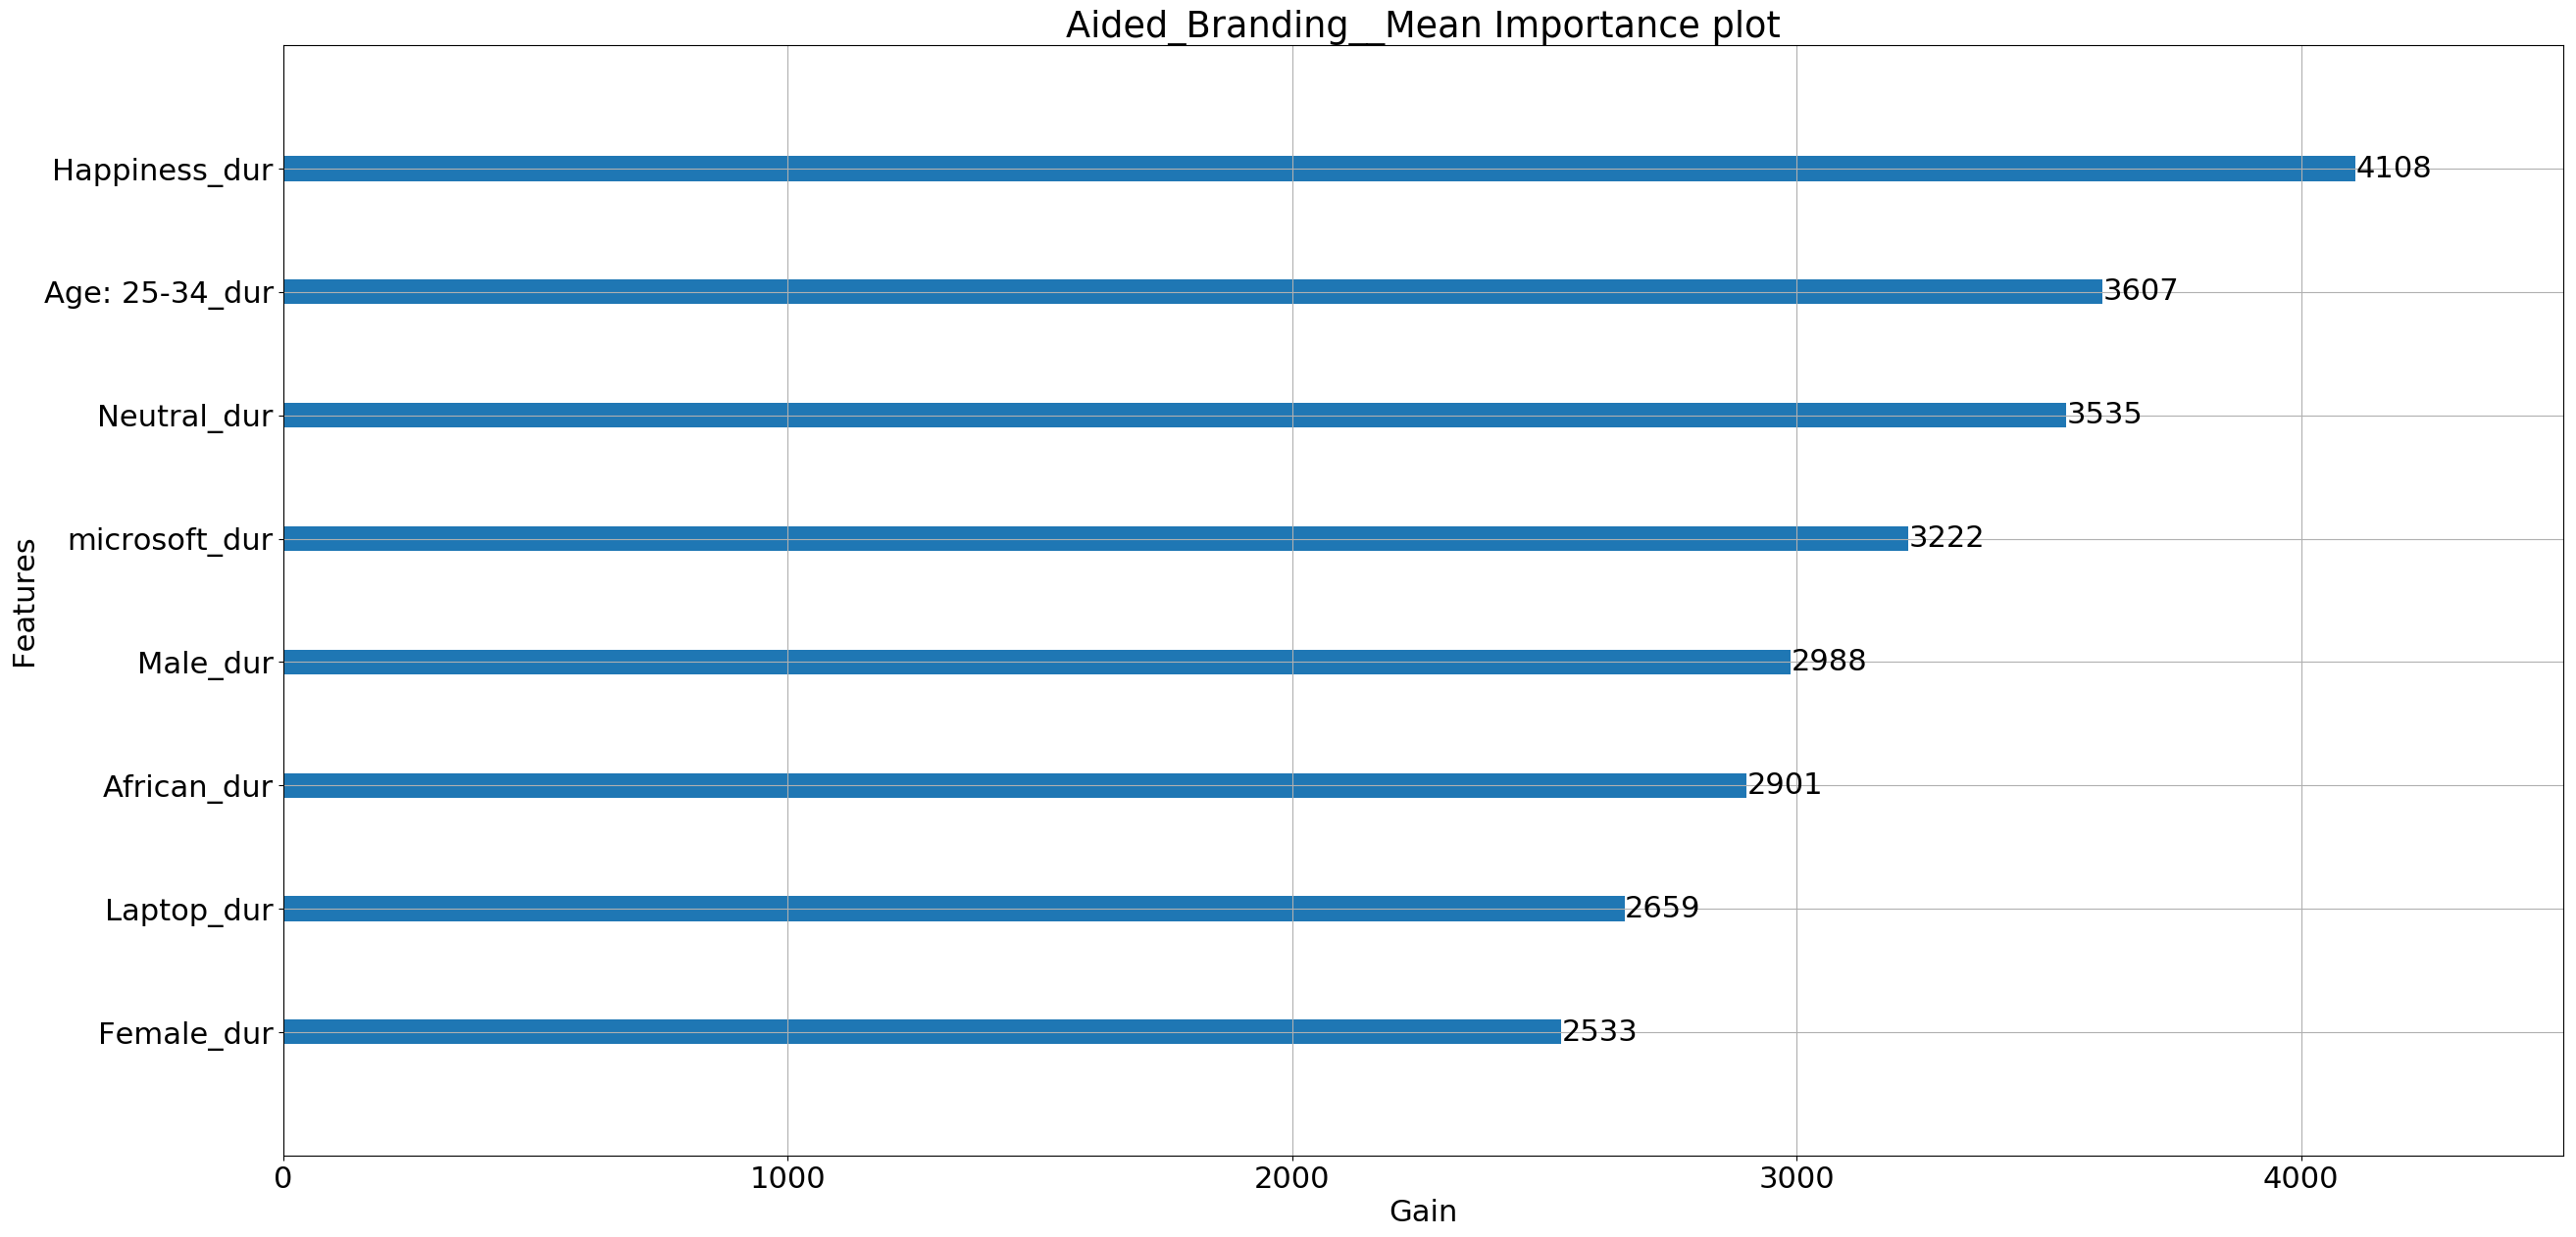

Active_Involvement__Mean
Tablet_dur
Hp_first_ocr
Laptop_total_ocr
microsoft_first_ocr
microsoft_dur
Dell_text_dur
Laptop_last_ocr
microsoft_total_ocr
microsoft_last_ocr
African_dur
Dell_sub_brand_group_dur
Windows_last_ocr
Lenovo_text_dur
Hp_text_dur
Neutral_dur
Laptop_dur
Surface_group_dur
Age: 25-34_dur
ASUS T102_dur
Laptop_first_ocr
Sadness_dur
Asus_dur
length_of_ad_15
Windows_dur
Age: 35-44_dur
Windows_first_ocr
Hp_text_first_ocr
Hp_text_last_ocr
Hp_dur
Female_dur
Age: 15-24_dur
Hp_text_total_ocr
Male_dur
Lenovo_group_dur
Dell_dur
Tablet_total_ocr
Happiness_dur
Asus_text_dur
Windows_total_ocr
Hp_total_ocr
Tablet_first_ocr
Hp_last_ocr
Eastasian_dur
Tablet_last_ocr
Yoga_dur
HP_group_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


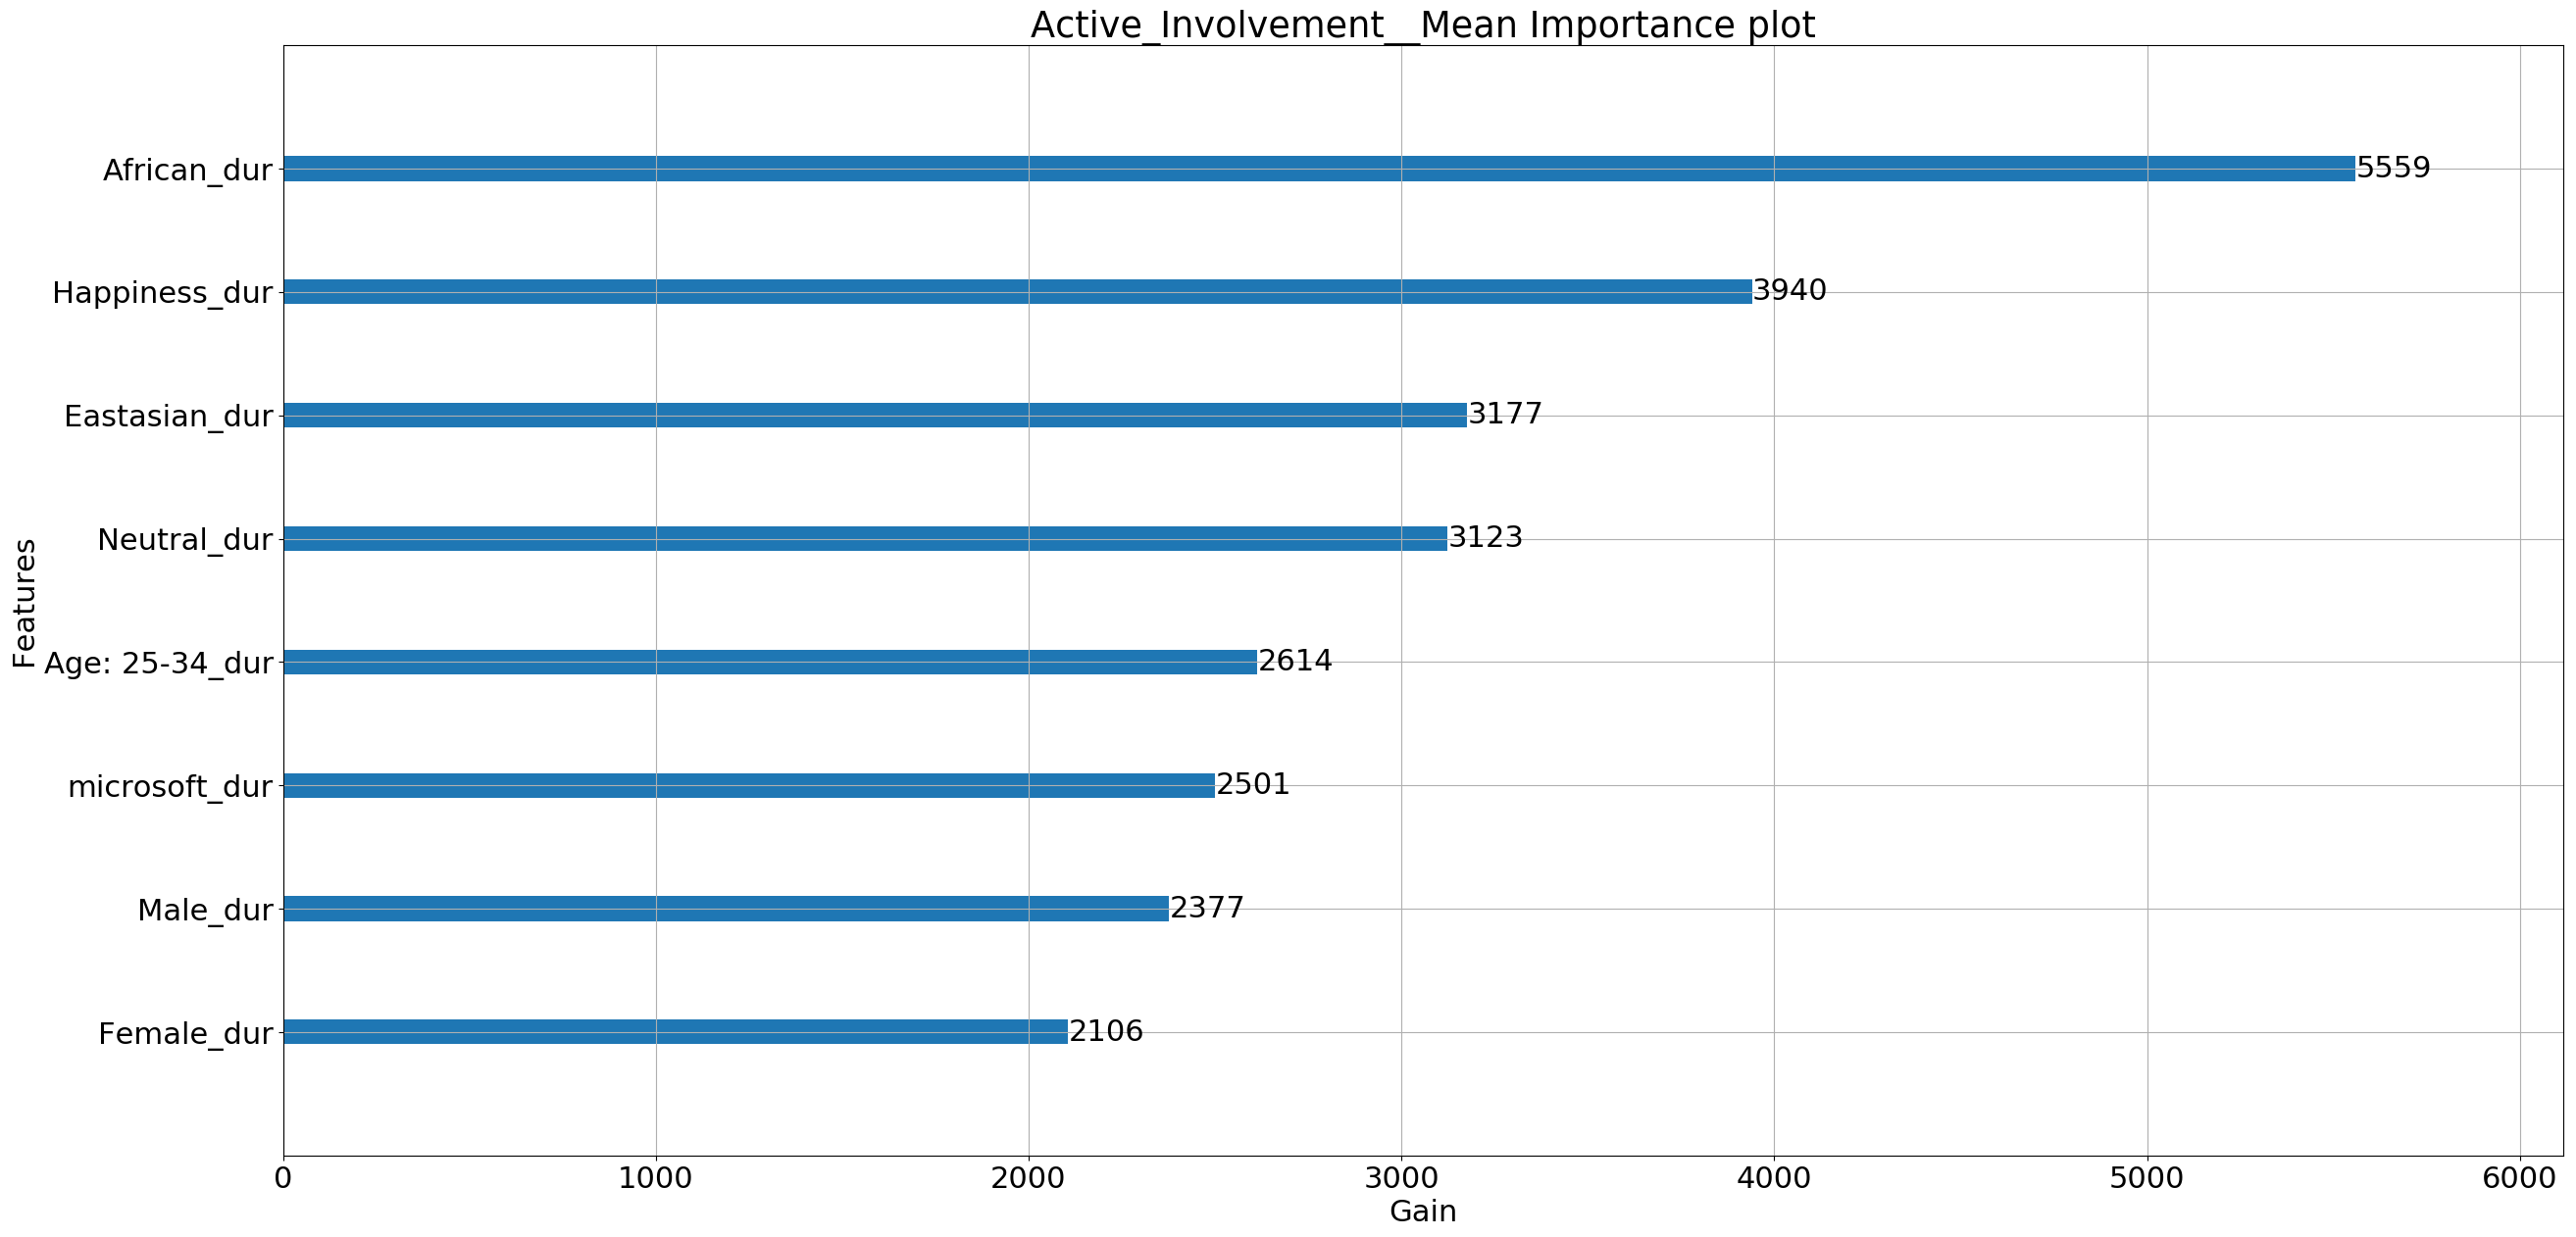

New_Information__Mean
Lenovo_text_dur
microsoft_last_ocr
Laptop_first_ocr
Yoga_dur
Laptop_last_ocr
Laptop_total_ocr
Hp_text_dur
length_of_ad_15
Lenovo_group_dur
Windows_last_ocr
microsoft_total_ocr
Laptop_dur
Happiness_dur
Dell_text_dur
Neutral_dur
Tablet_total_ocr
microsoft_first_ocr
Age: 35-44_dur
Hp_last_ocr
Tablet_dur
Tablet_first_ocr
ASUS T102_dur
Asus_text_dur
Asus_dur
Dell_sub_brand_group_dur
Hp_text_first_ocr
Surface_group_dur
Hp_total_ocr
Hp_text_last_ocr
Hp_dur
Tablet_last_ocr
Windows_first_ocr
Dell_dur
Hp_text_total_ocr
microsoft_dur
Female_dur
Age: 25-34_dur
Sadness_dur
Male_dur
Windows_dur
Eastasian_dur
Age: 15-24_dur
Hp_first_ocr
Windows_total_ocr
African_dur
HP_group_dur
Apple_dur
Currys PCs world_text_dur
Macbook_group_dur


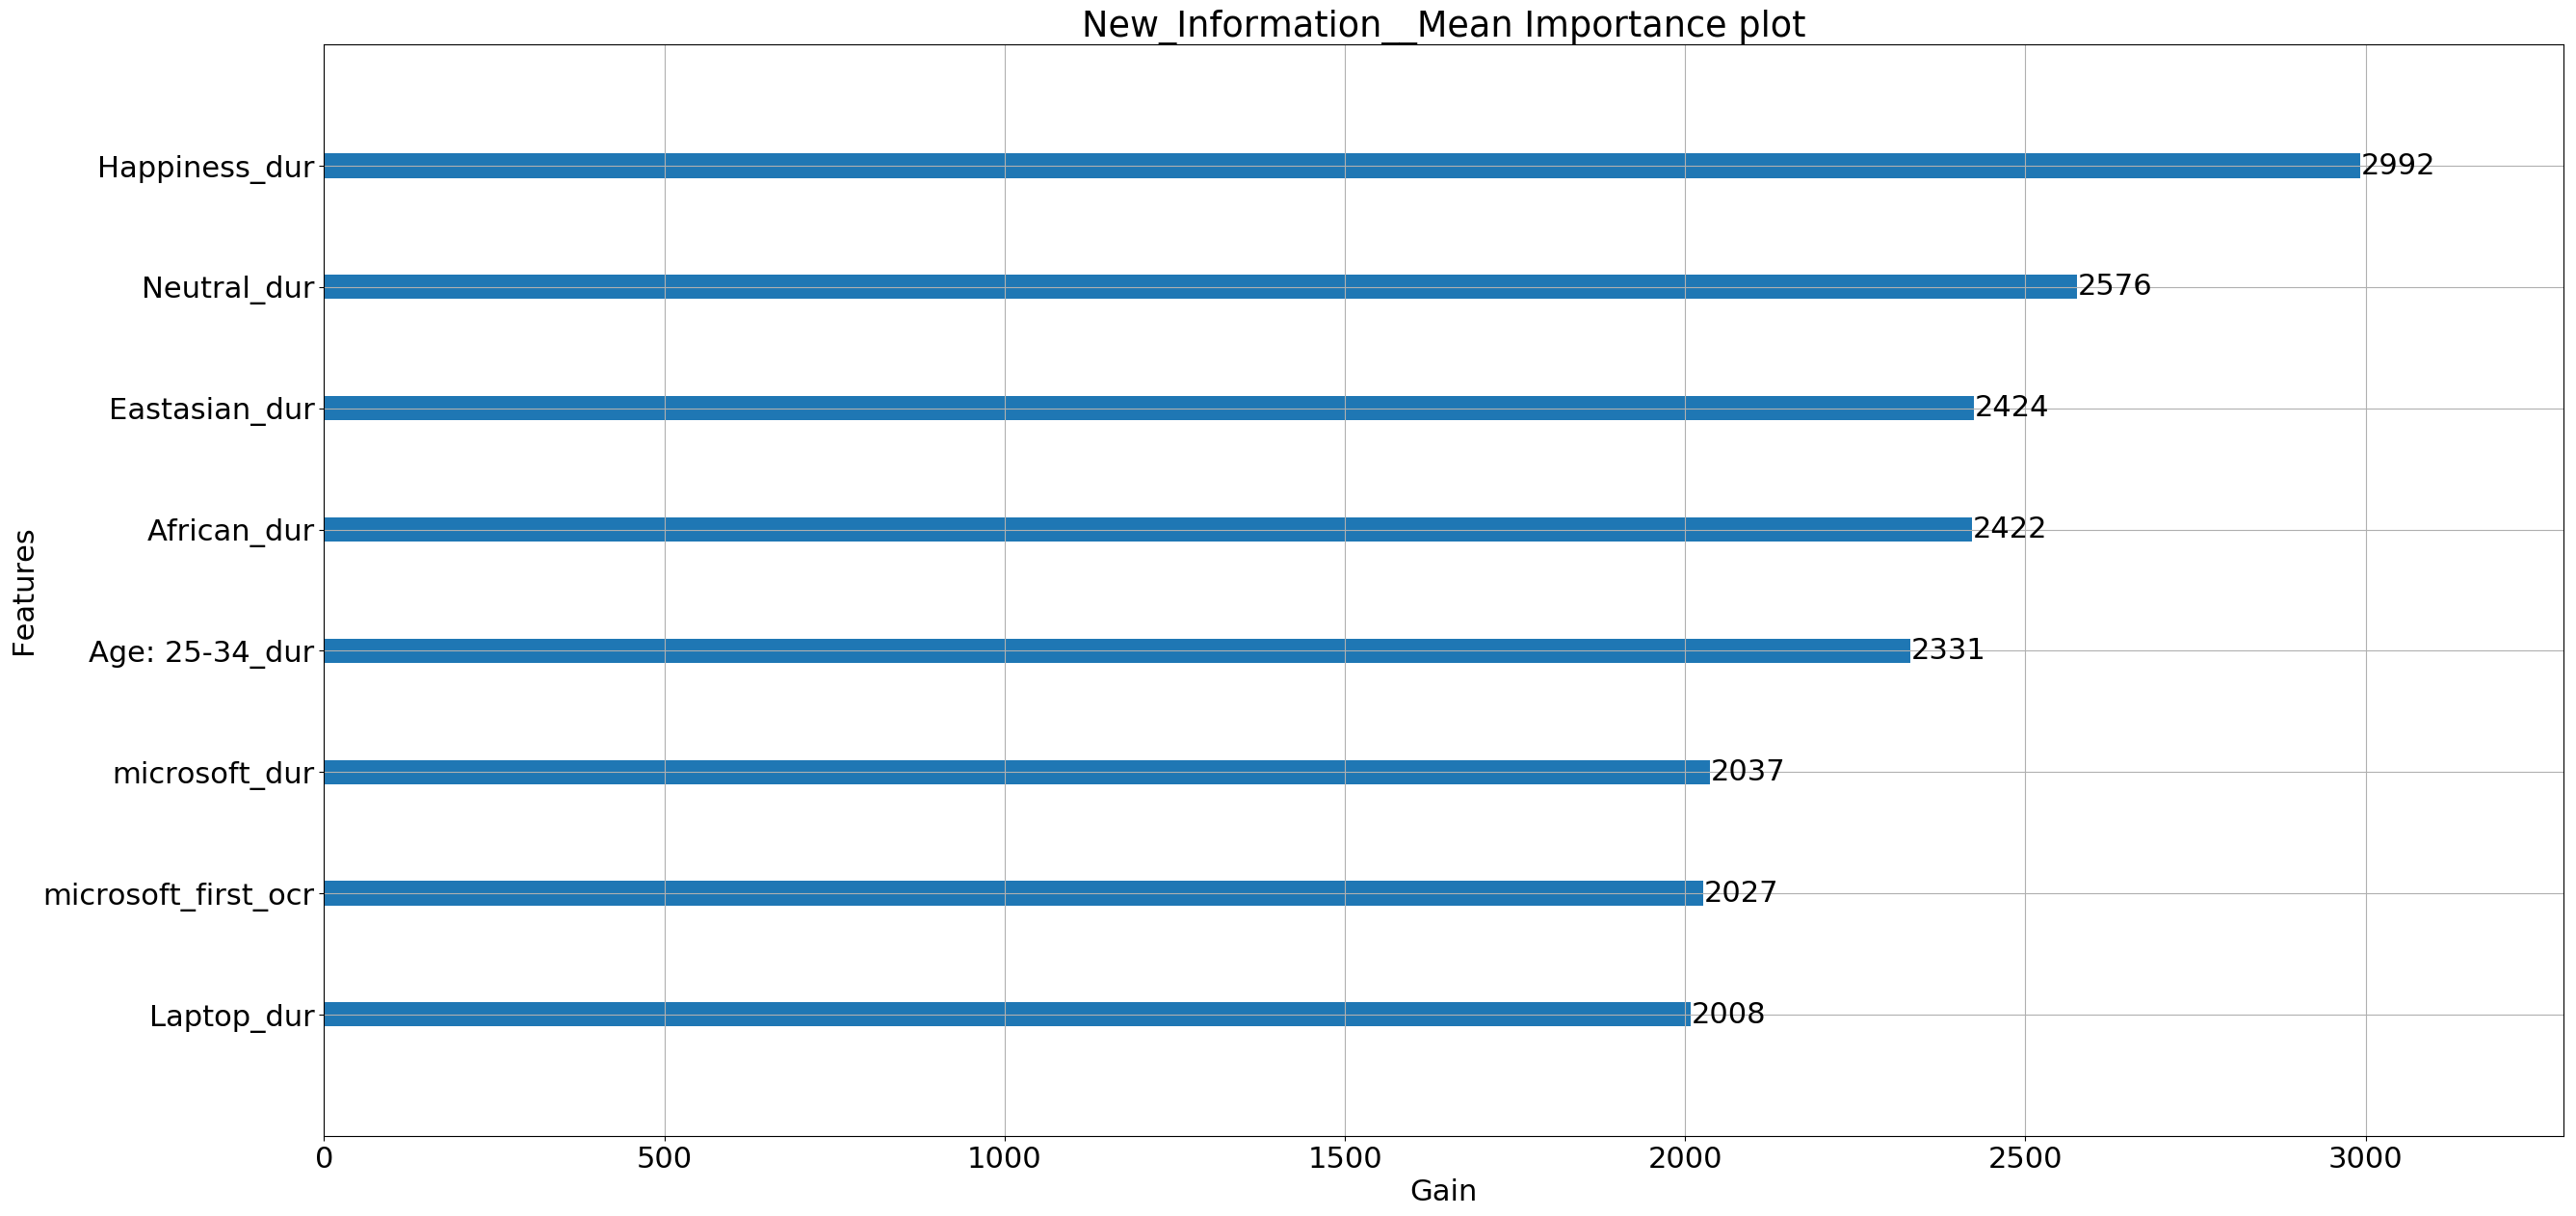

Enjoyment__Mean
length_of_ad_15
Windows_last_ocr
Lenovo_text_dur
Laptop_last_ocr
microsoft_last_ocr
Laptop_dur
Hp_first_ocr
microsoft_dur
Tablet_first_ocr
Tablet_total_ocr
Happiness_dur
Asus_dur
microsoft_first_ocr
ASUS T102_dur
Dell_sub_brand_group_dur
Hp_text_dur
microsoft_total_ocr
Hp_text_first_ocr
Laptop_first_ocr
Age: 15-24_dur
Windows_total_ocr
Sadness_dur
Hp_dur
Asus_text_dur
Neutral_dur
Windows_first_ocr
Age: 35-44_dur
Lenovo_group_dur
Male_dur
Dell_text_dur
Tablet_last_ocr
HP_group_dur
Hp_total_ocr
Windows_dur
Surface_group_dur
Yoga_dur
Dell_dur
Tablet_dur
Laptop_total_ocr
Age: 25-34_dur
Female_dur
Eastasian_dur
Hp_text_total_ocr
Hp_text_last_ocr
Hp_last_ocr
African_dur
Currys PCs world_text_dur
Apple_dur
Macbook_group_dur


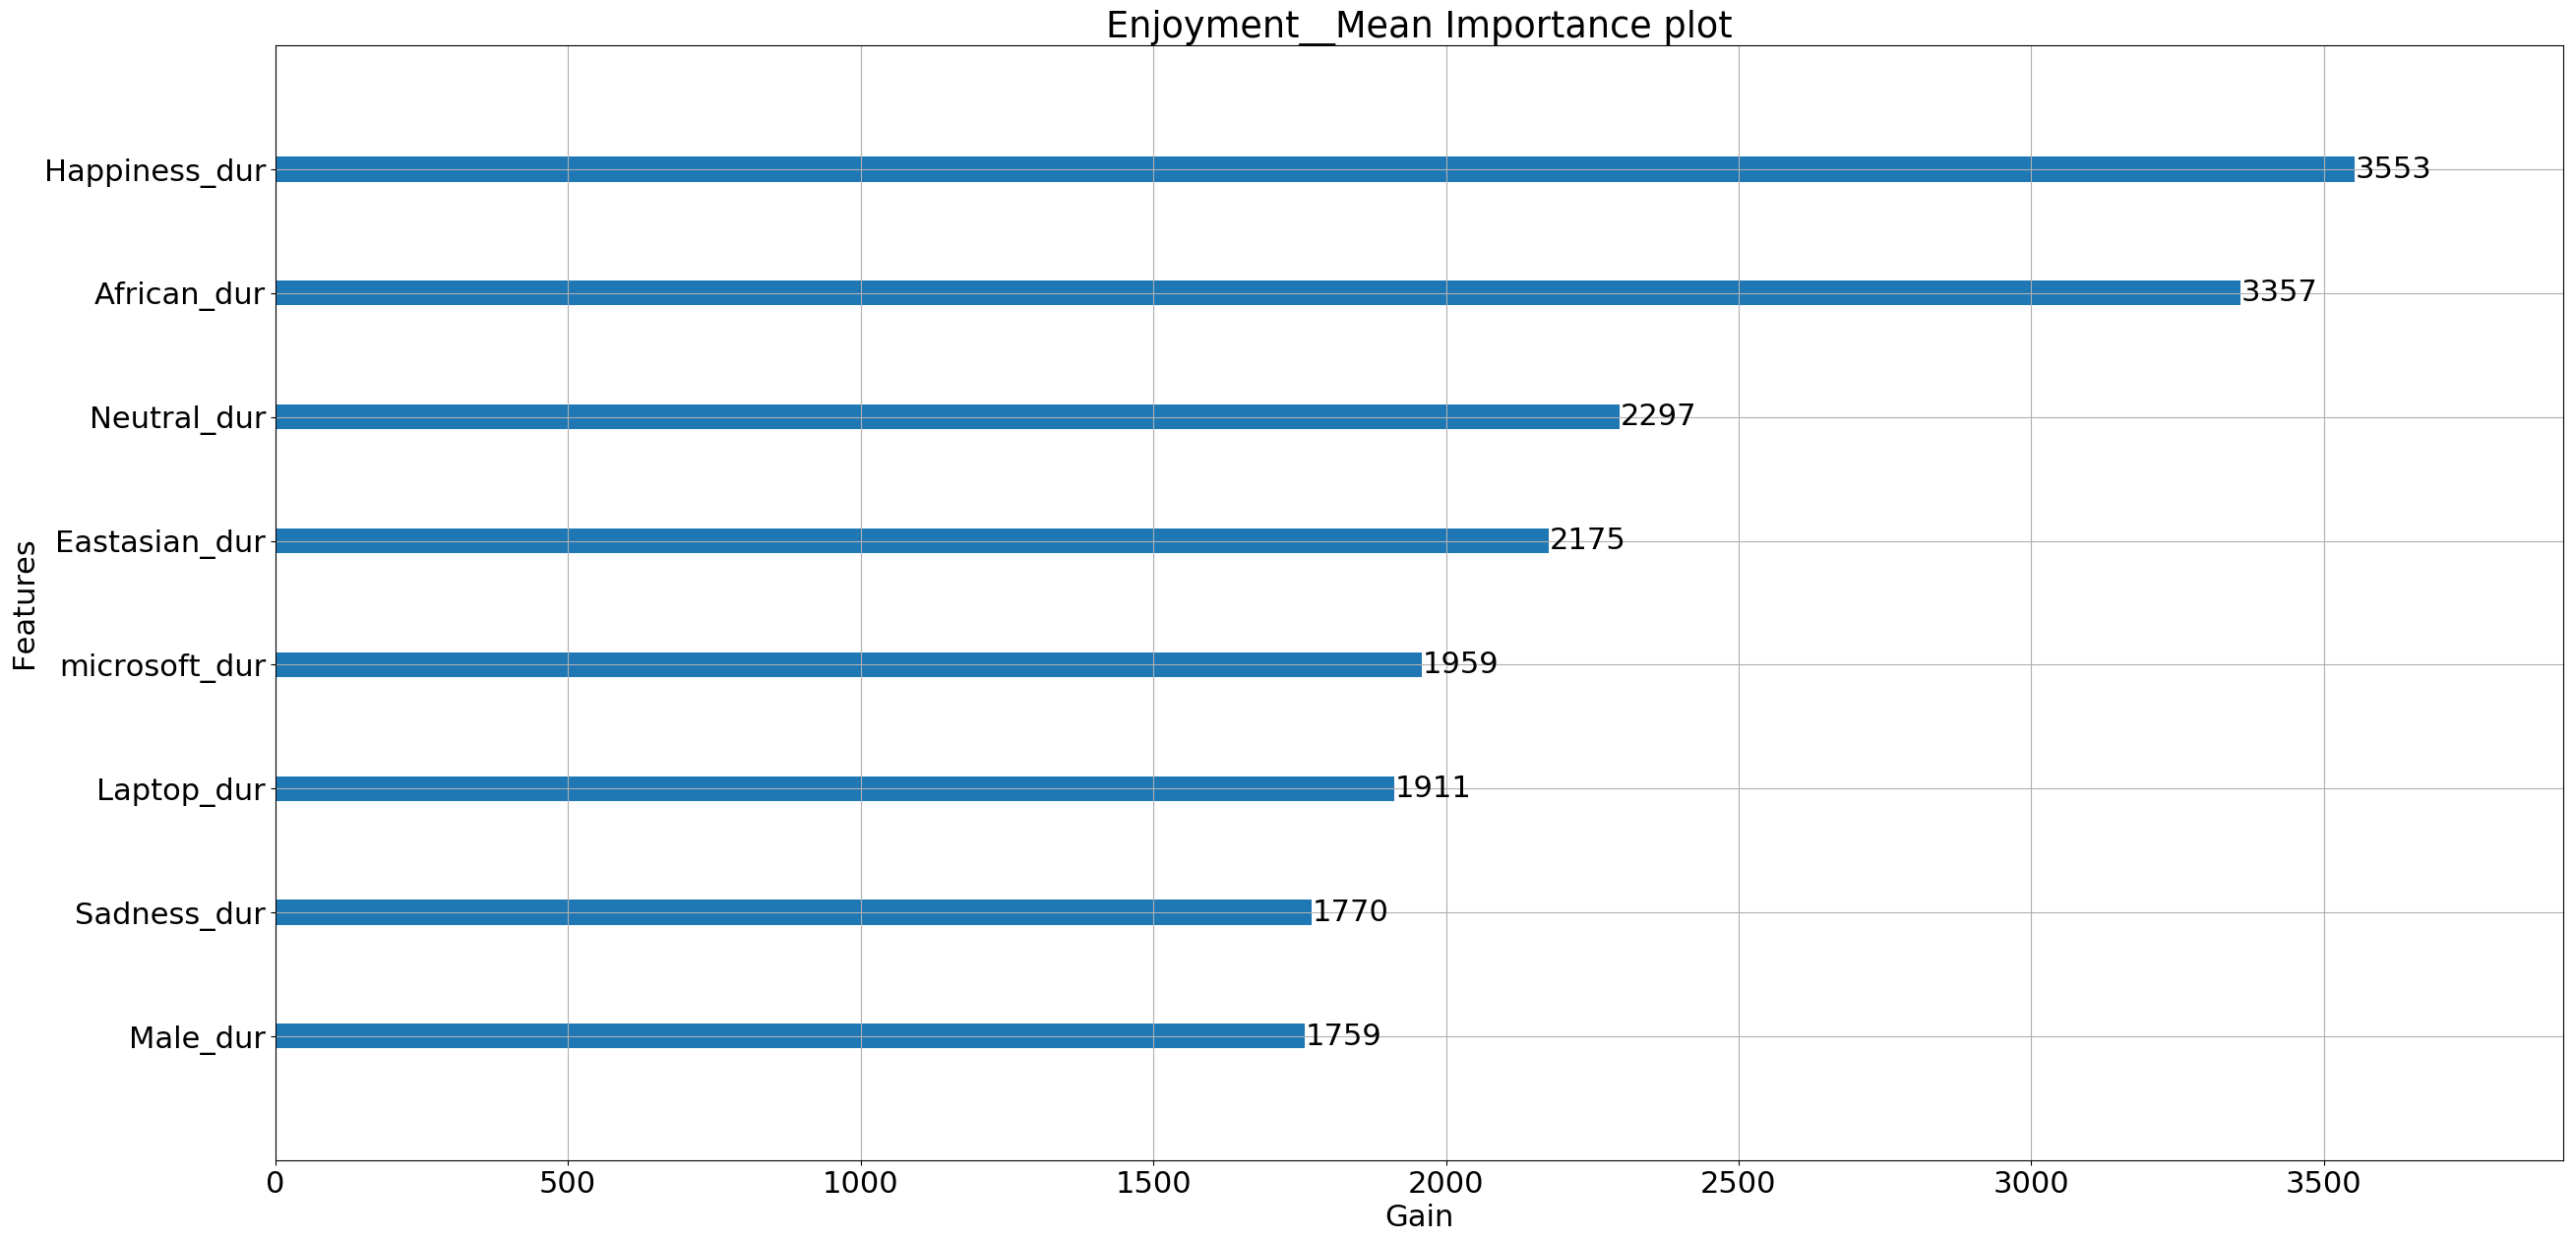

Brand_Appeal__Mean
Lenovo_text_dur
Windows_last_ocr
Laptop_last_ocr
Yoga_dur
Laptop_total_ocr
Asus_text_dur
microsoft_last_ocr
ASUS T102_dur
length_of_ad_15
Hp_text_dur
Laptop_first_ocr
Tablet_first_ocr
microsoft_first_ocr
Windows_total_ocr
microsoft_total_ocr
Hp_dur
Asus_dur
Neutral_dur
Windows_dur
Windows_first_ocr
Lenovo_group_dur
Tablet_last_ocr
Age: 15-24_dur
microsoft_dur
Female_dur
Dell_sub_brand_group_dur
Happiness_dur
Age: 35-44_dur
Hp_total_ocr
Age: 25-34_dur
Laptop_dur
Hp_text_total_ocr
Sadness_dur
Dell_dur
Hp_text_first_ocr
Male_dur
Tablet_dur
Dell_text_dur
Hp_text_last_ocr
Hp_last_ocr
African_dur
Surface_group_dur
Hp_first_ocr
Tablet_total_ocr
Eastasian_dur
HP_group_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


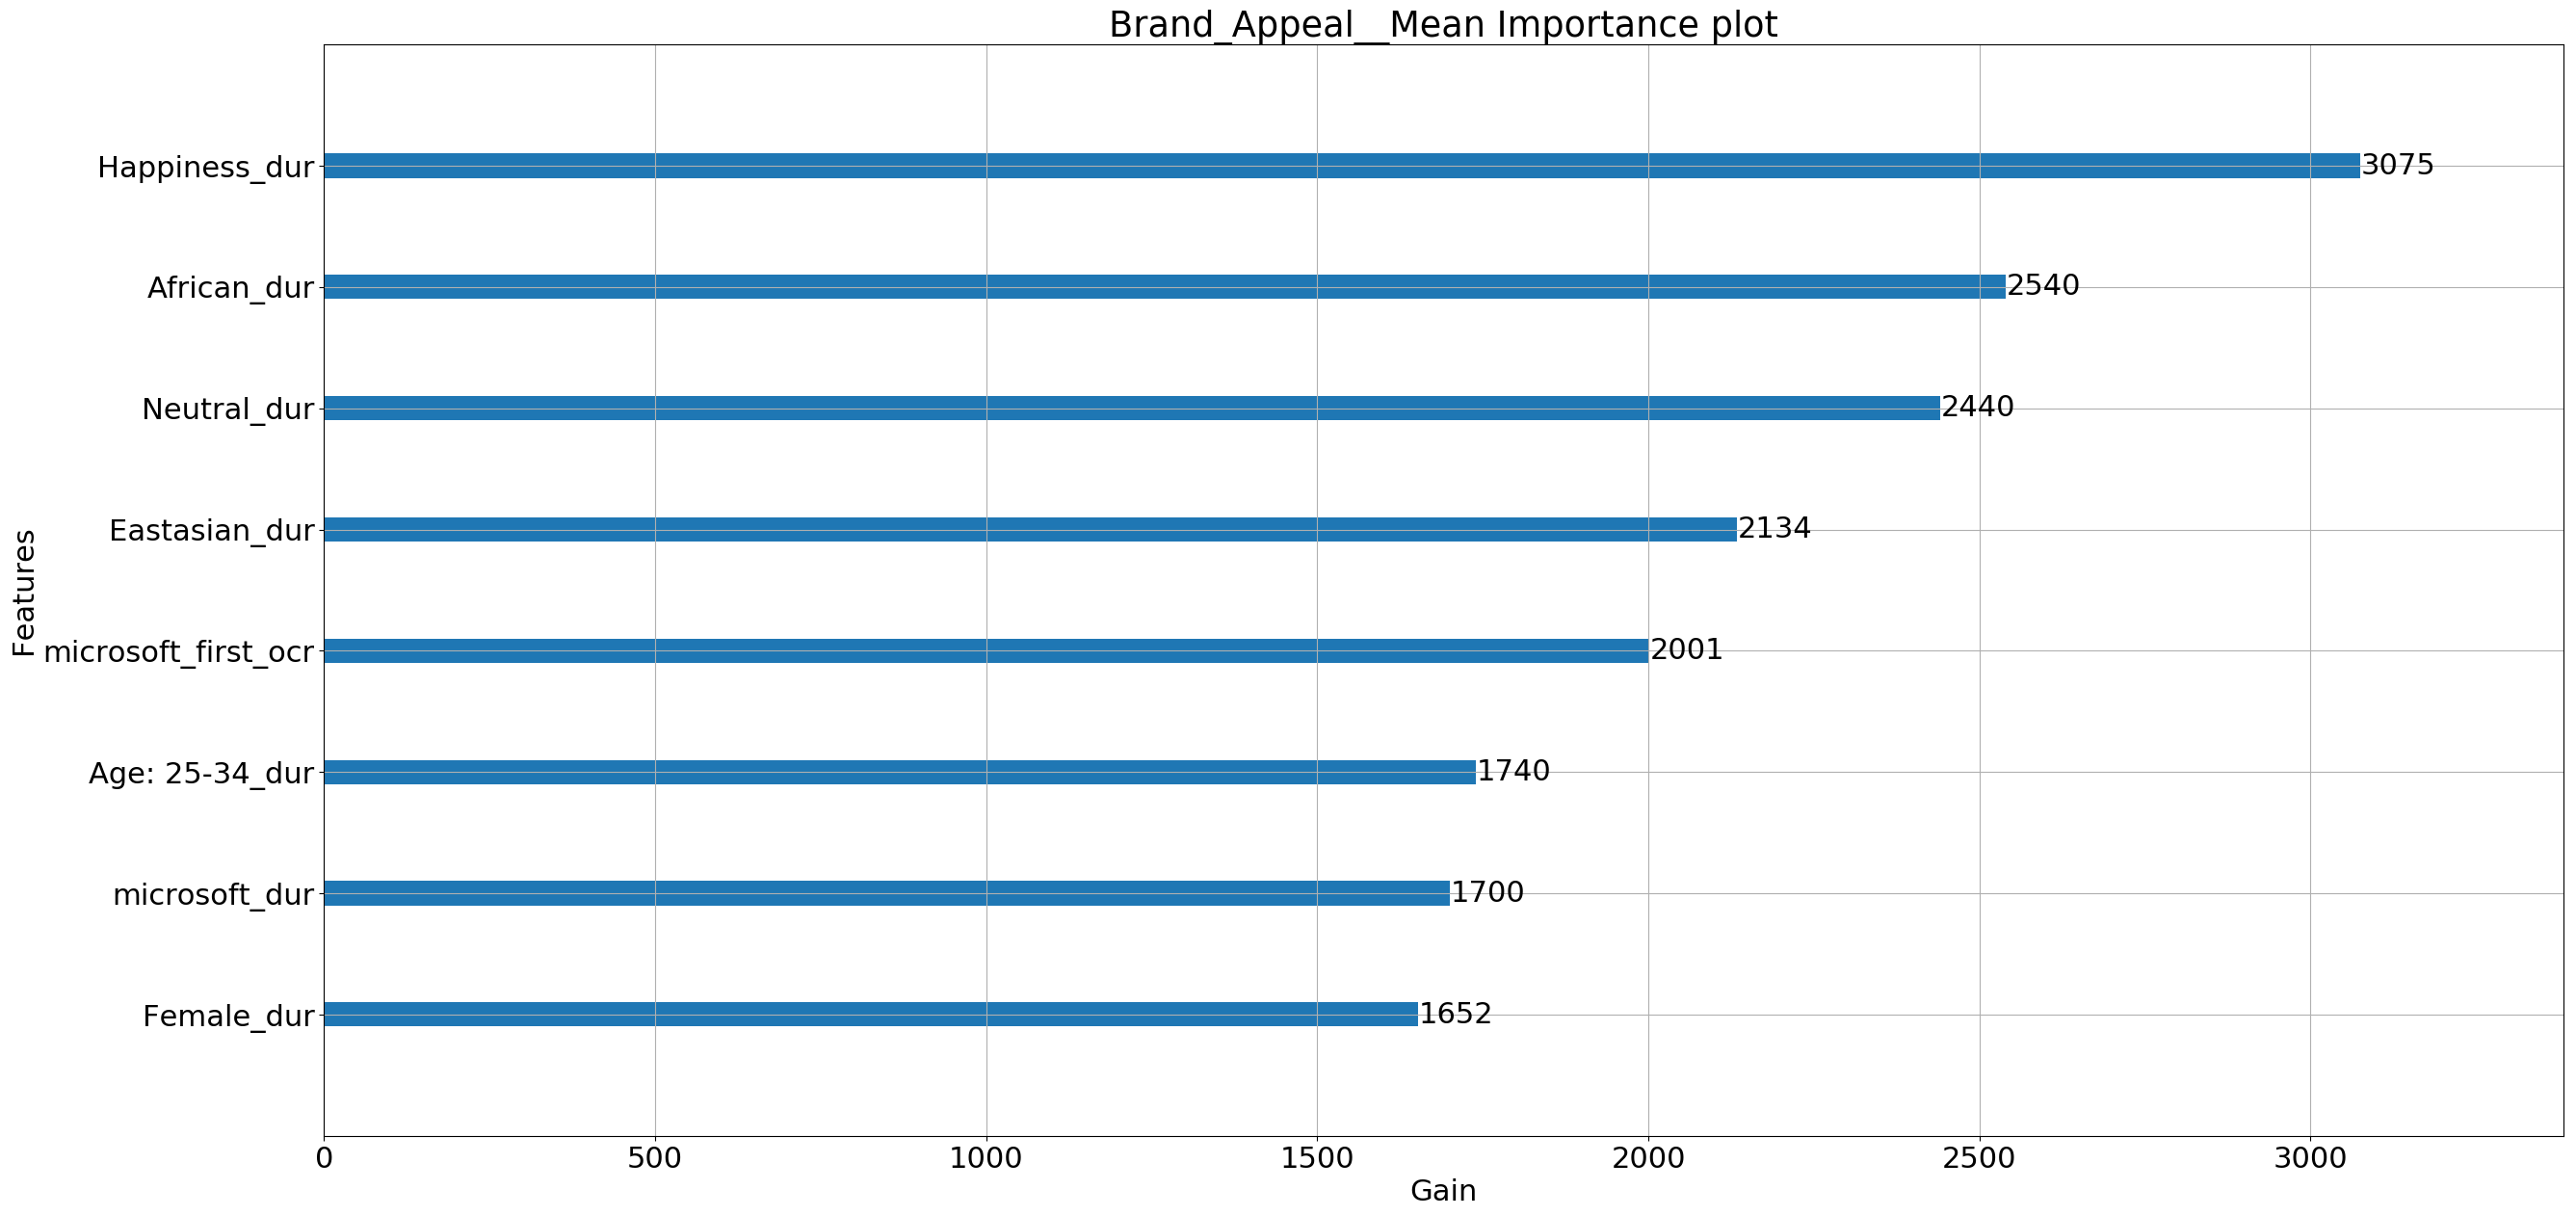

Understanding__Mean
Hp_text_total_ocr
Hp_text_last_ocr
Hp_text_dur
microsoft_last_ocr
Lenovo_text_dur
Male_dur
Female_dur
microsoft_total_ocr
Hp_text_first_ocr
microsoft_dur
Neutral_dur
length_of_ad_15
Hp_first_ocr
ASUS T102_dur
Asus_text_dur
microsoft_first_ocr
Windows_dur
Hp_total_ocr
Hp_dur
Windows_last_ocr
Laptop_total_ocr
Laptop_dur
Windows_total_ocr
Tablet_dur
Age: 35-44_dur
Tablet_last_ocr
Age: 15-24_dur
Laptop_first_ocr
Dell_dur
Windows_first_ocr
Tablet_total_ocr
Laptop_last_ocr
Tablet_first_ocr
Sadness_dur
Hp_last_ocr
Happiness_dur
Eastasian_dur
Age: 25-34_dur
Lenovo_group_dur
Dell_text_dur
Asus_dur
HP_group_dur
Dell_sub_brand_group_dur
Yoga_dur
African_dur
Surface_group_dur
Currys PCs world_text_dur
Macbook_group_dur
Apple_dur


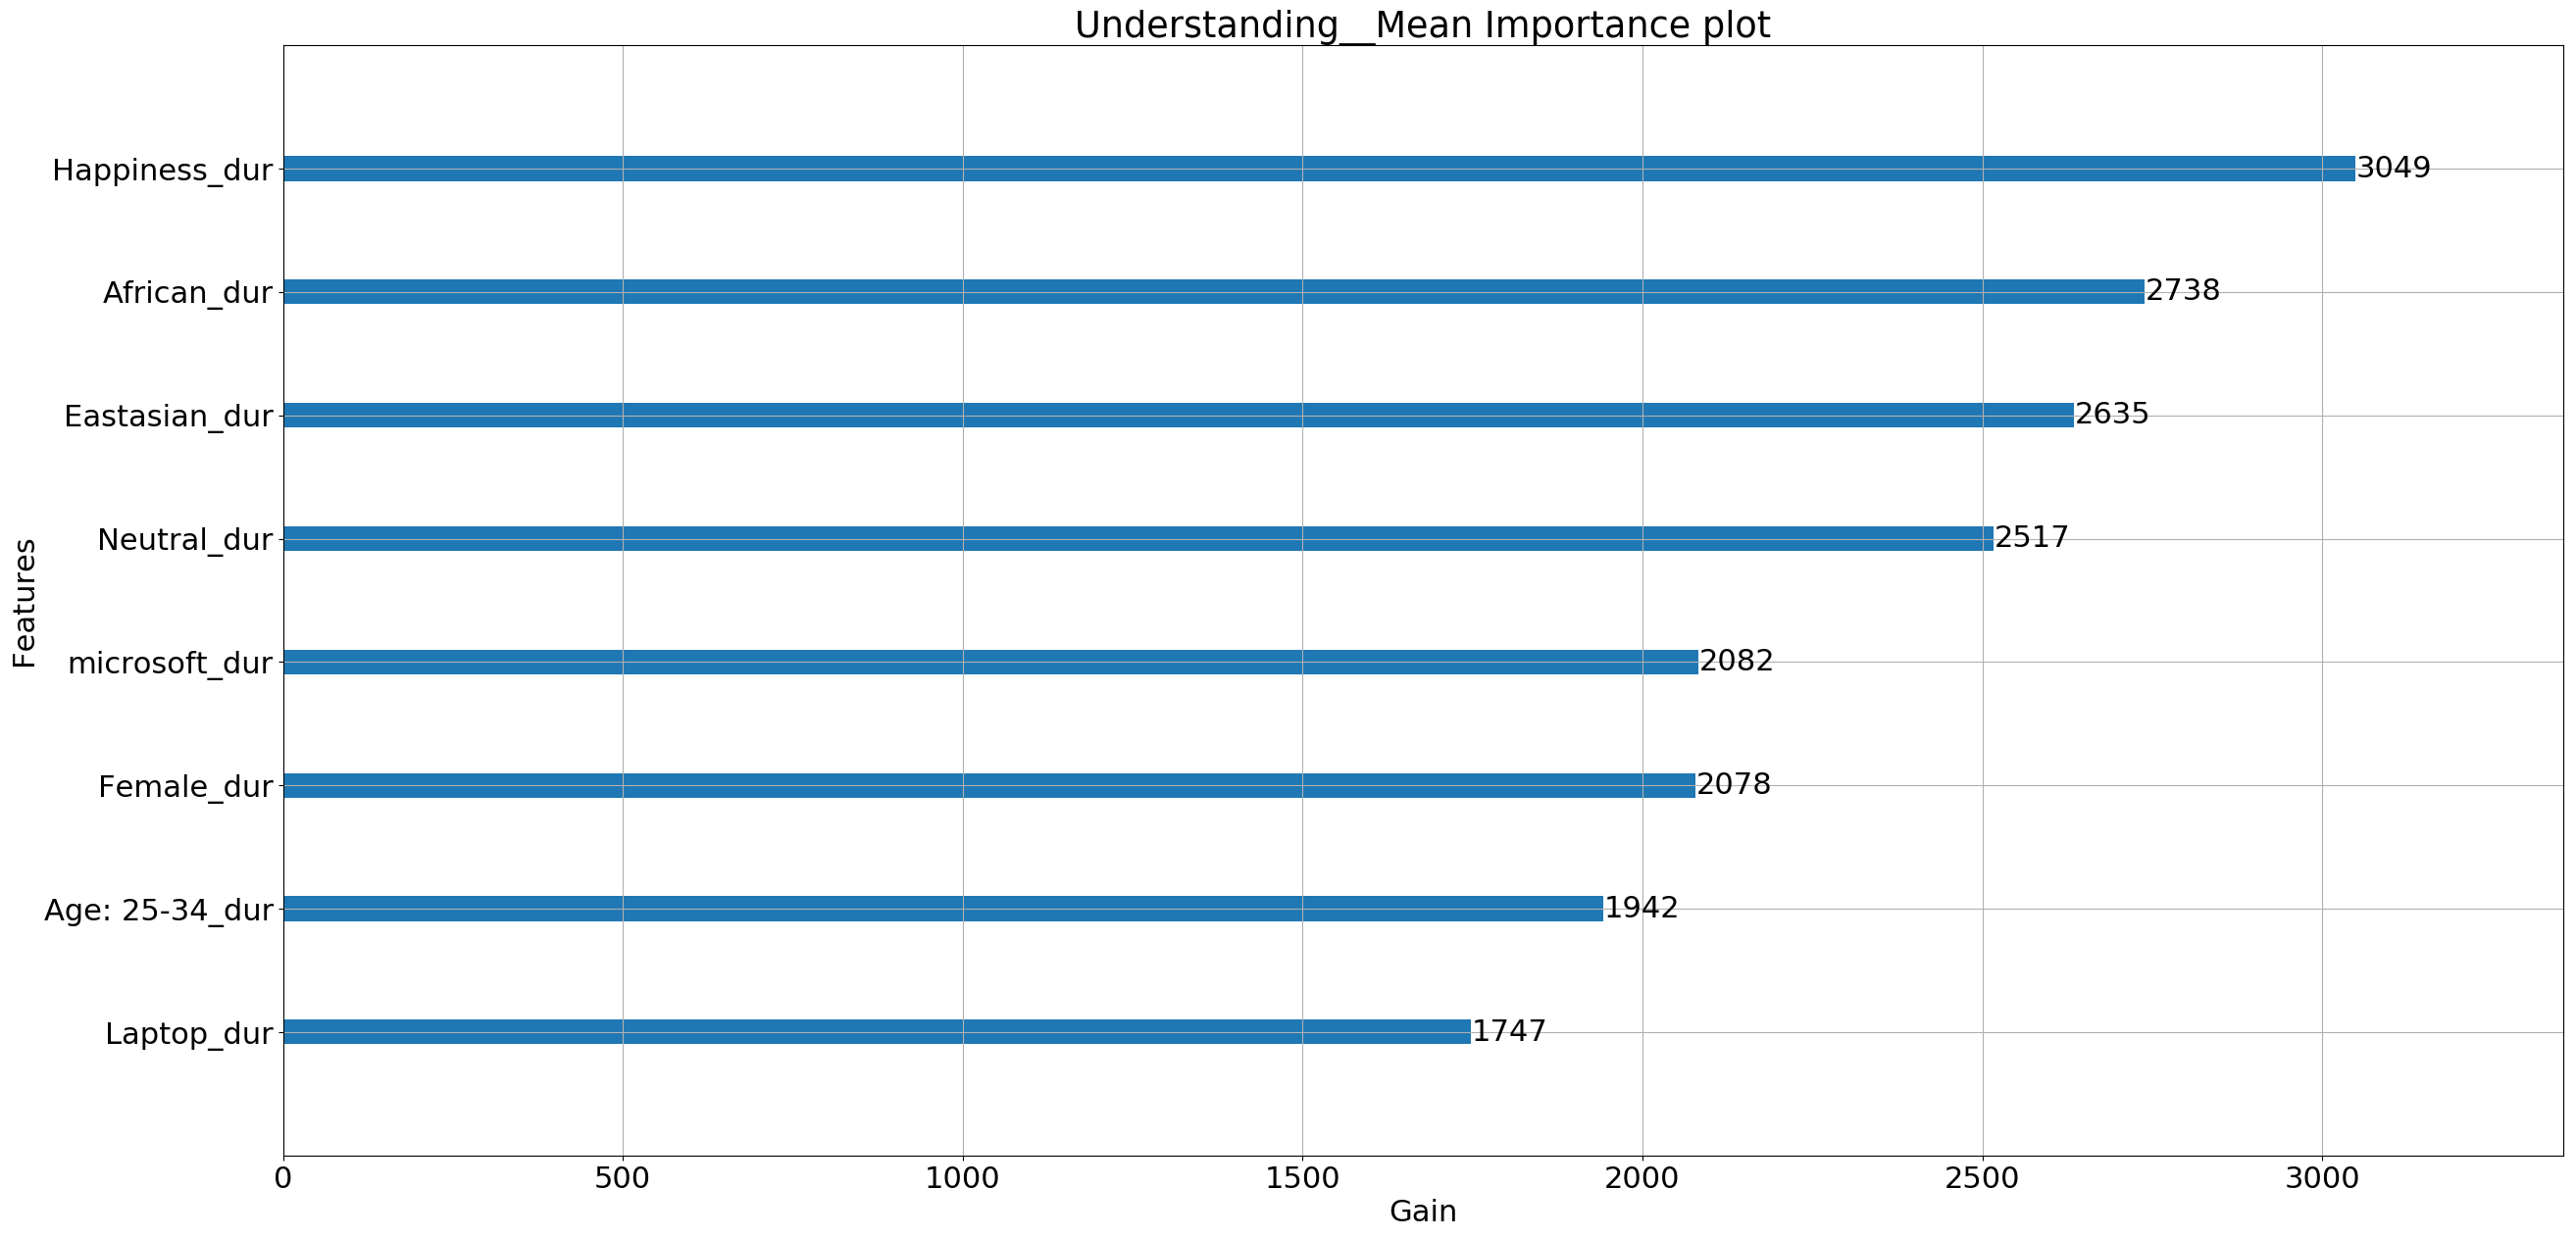

Relevance_of_Information__Mean
length_of_ad_15
microsoft_last_ocr
Windows_last_ocr
Asus_dur
Asus_text_dur
ASUS T102_dur
Laptop_first_ocr
Laptop_last_ocr
Age: 15-24_dur
microsoft_dur
Hp_text_total_ocr
microsoft_first_ocr
Windows_total_ocr
Laptop_total_ocr
Age: 35-44_dur
Windows_first_ocr
Tablet_total_ocr
Happiness_dur
Surface_group_dur
Hp_text_dur
Laptop_dur
Hp_first_ocr
Tablet_dur
Eastasian_dur
Hp_text_last_ocr
Tablet_first_ocr
Windows_dur
microsoft_total_ocr
Lenovo_group_dur
Hp_last_ocr
Neutral_dur
Hp_text_first_ocr
Lenovo_text_dur
Hp_total_ocr
Age: 25-34_dur
Sadness_dur
Tablet_last_ocr
Dell_sub_brand_group_dur
Female_dur
Hp_dur
Dell_text_dur
HP_group_dur
Male_dur
Dell_dur
Yoga_dur
African_dur
Macbook_group_dur
Apple_dur
Currys PCs world_text_dur


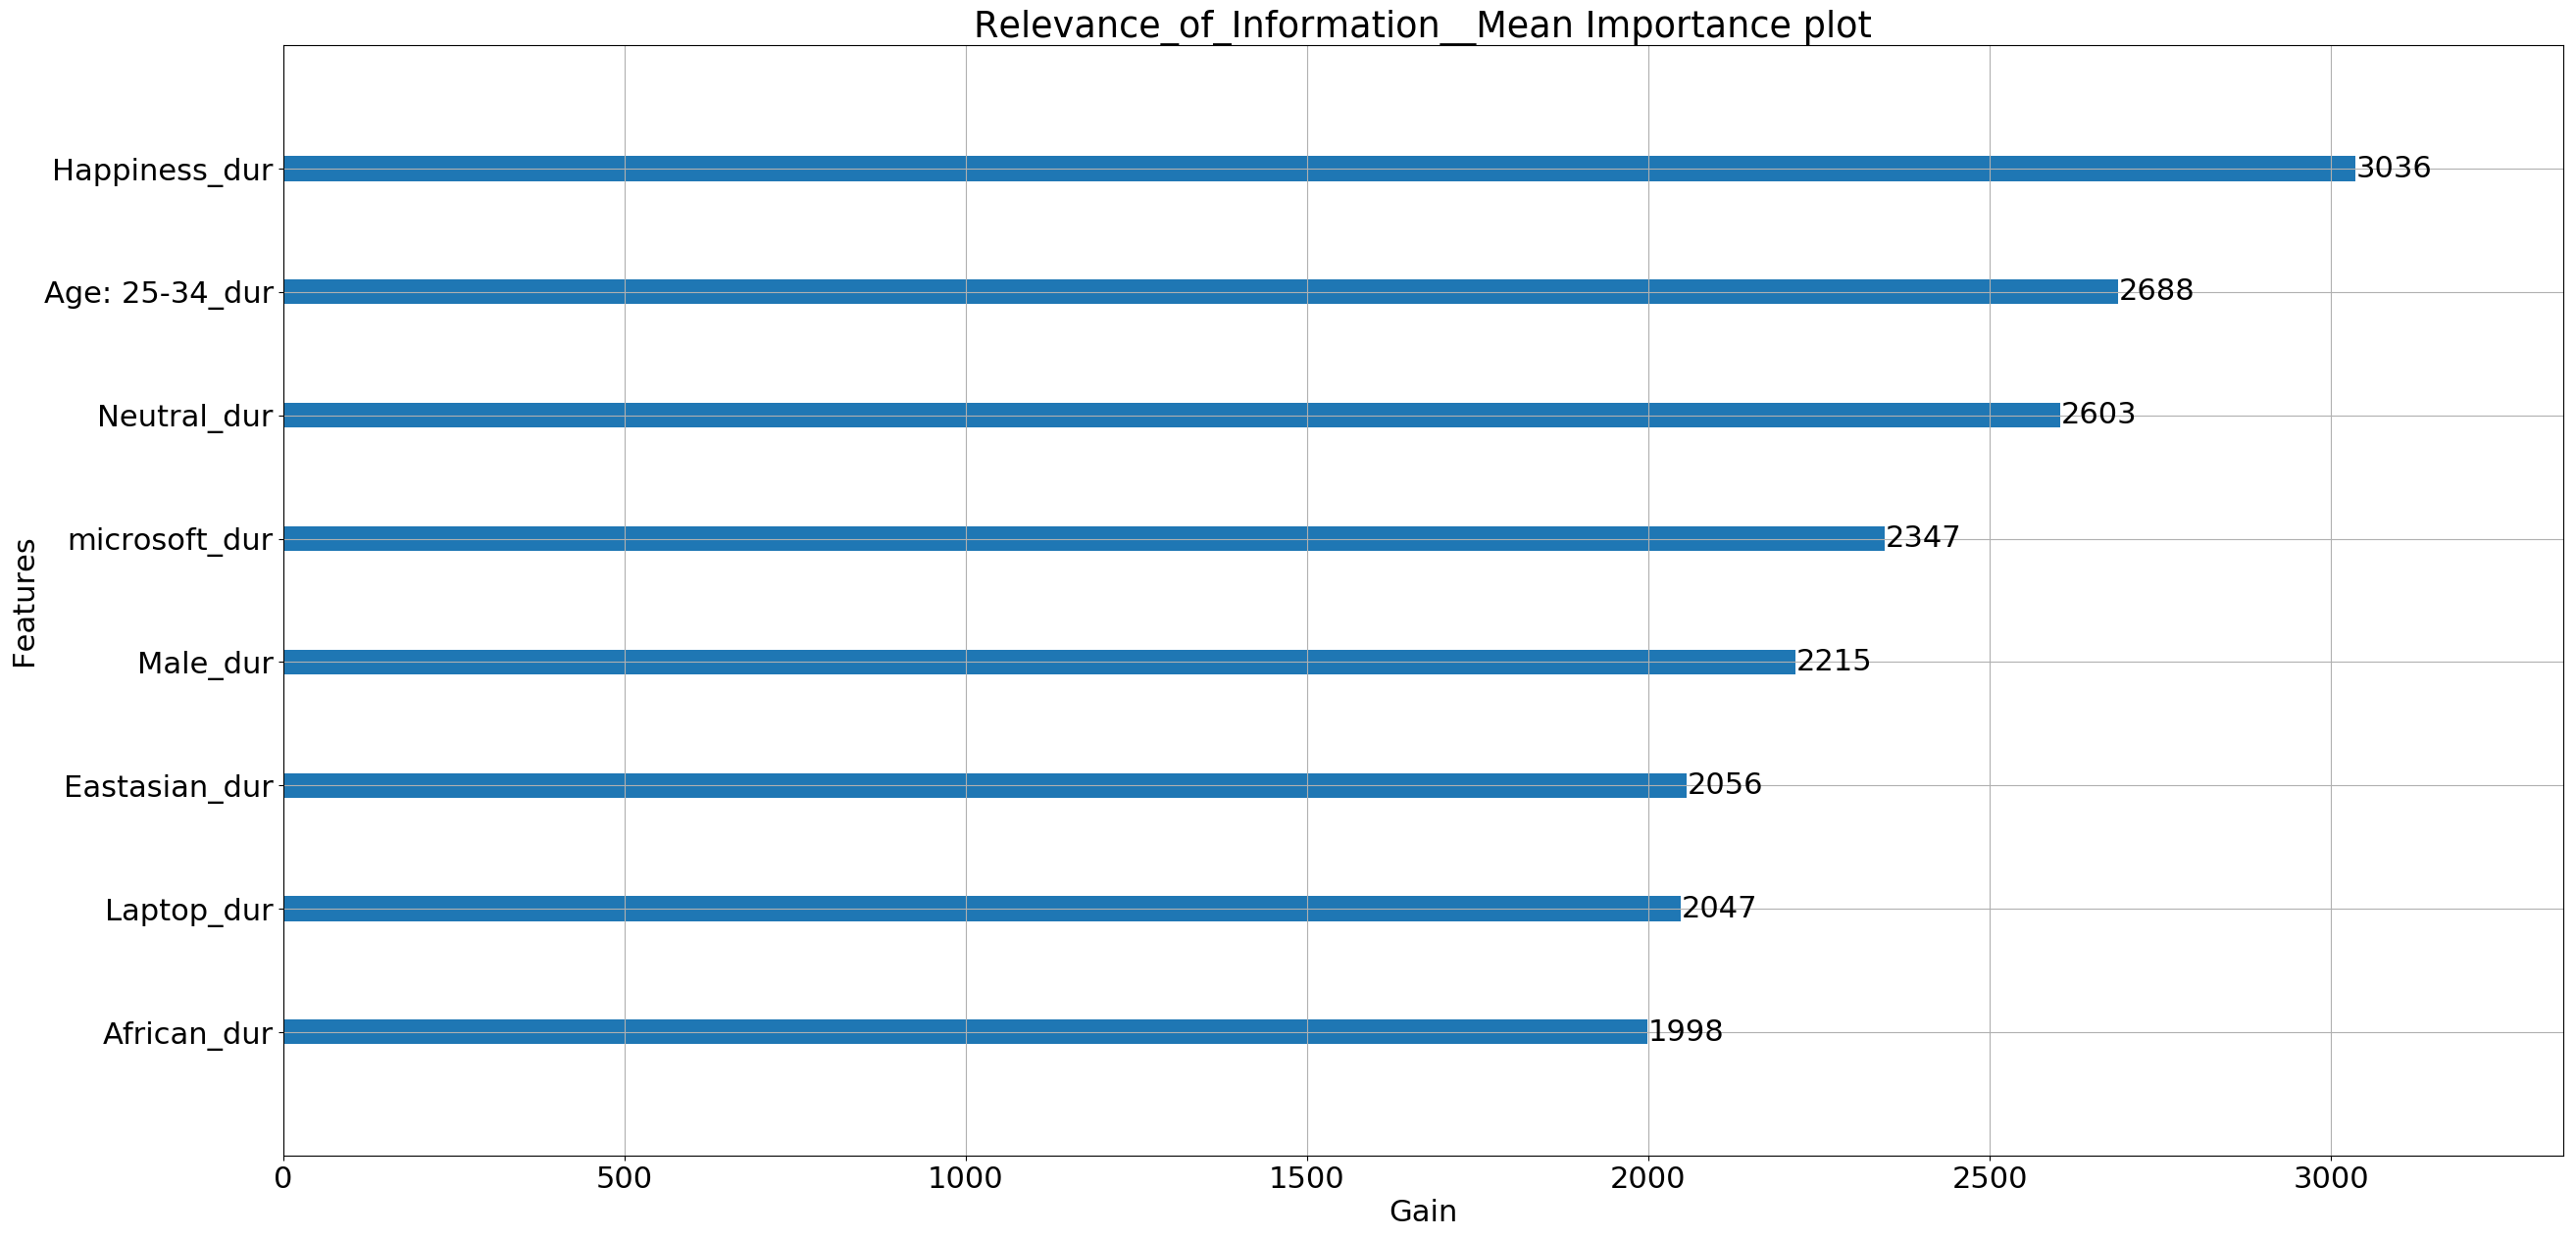

Credibility_of_Information__Mean
Laptop_last_ocr
Laptop_first_ocr
Yoga_dur
Tablet_total_ocr
Laptop_total_ocr
Hp_text_dur
microsoft_last_ocr
Lenovo_text_dur
Tablet_first_ocr
Hp_text_last_ocr
microsoft_dur
Asus_dur
Dell_text_dur
Neutral_dur
Tablet_dur
Dell_dur
Windows_dur
Happiness_dur
Hp_text_first_ocr
microsoft_first_ocr
Tablet_last_ocr
Hp_text_total_ocr
Lenovo_group_dur
Windows_first_ocr
ASUS T102_dur
microsoft_total_ocr
Dell_sub_brand_group_dur
length_of_ad_15
Asus_text_dur
Female_dur
Hp_first_ocr
Hp_dur
Laptop_dur
Windows_total_ocr
Hp_total_ocr
Age: 25-34_dur
Windows_last_ocr
Surface_group_dur
Sadness_dur
Eastasian_dur
Hp_last_ocr
Male_dur
Age: 35-44_dur
African_dur
Age: 15-24_dur
HP_group_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


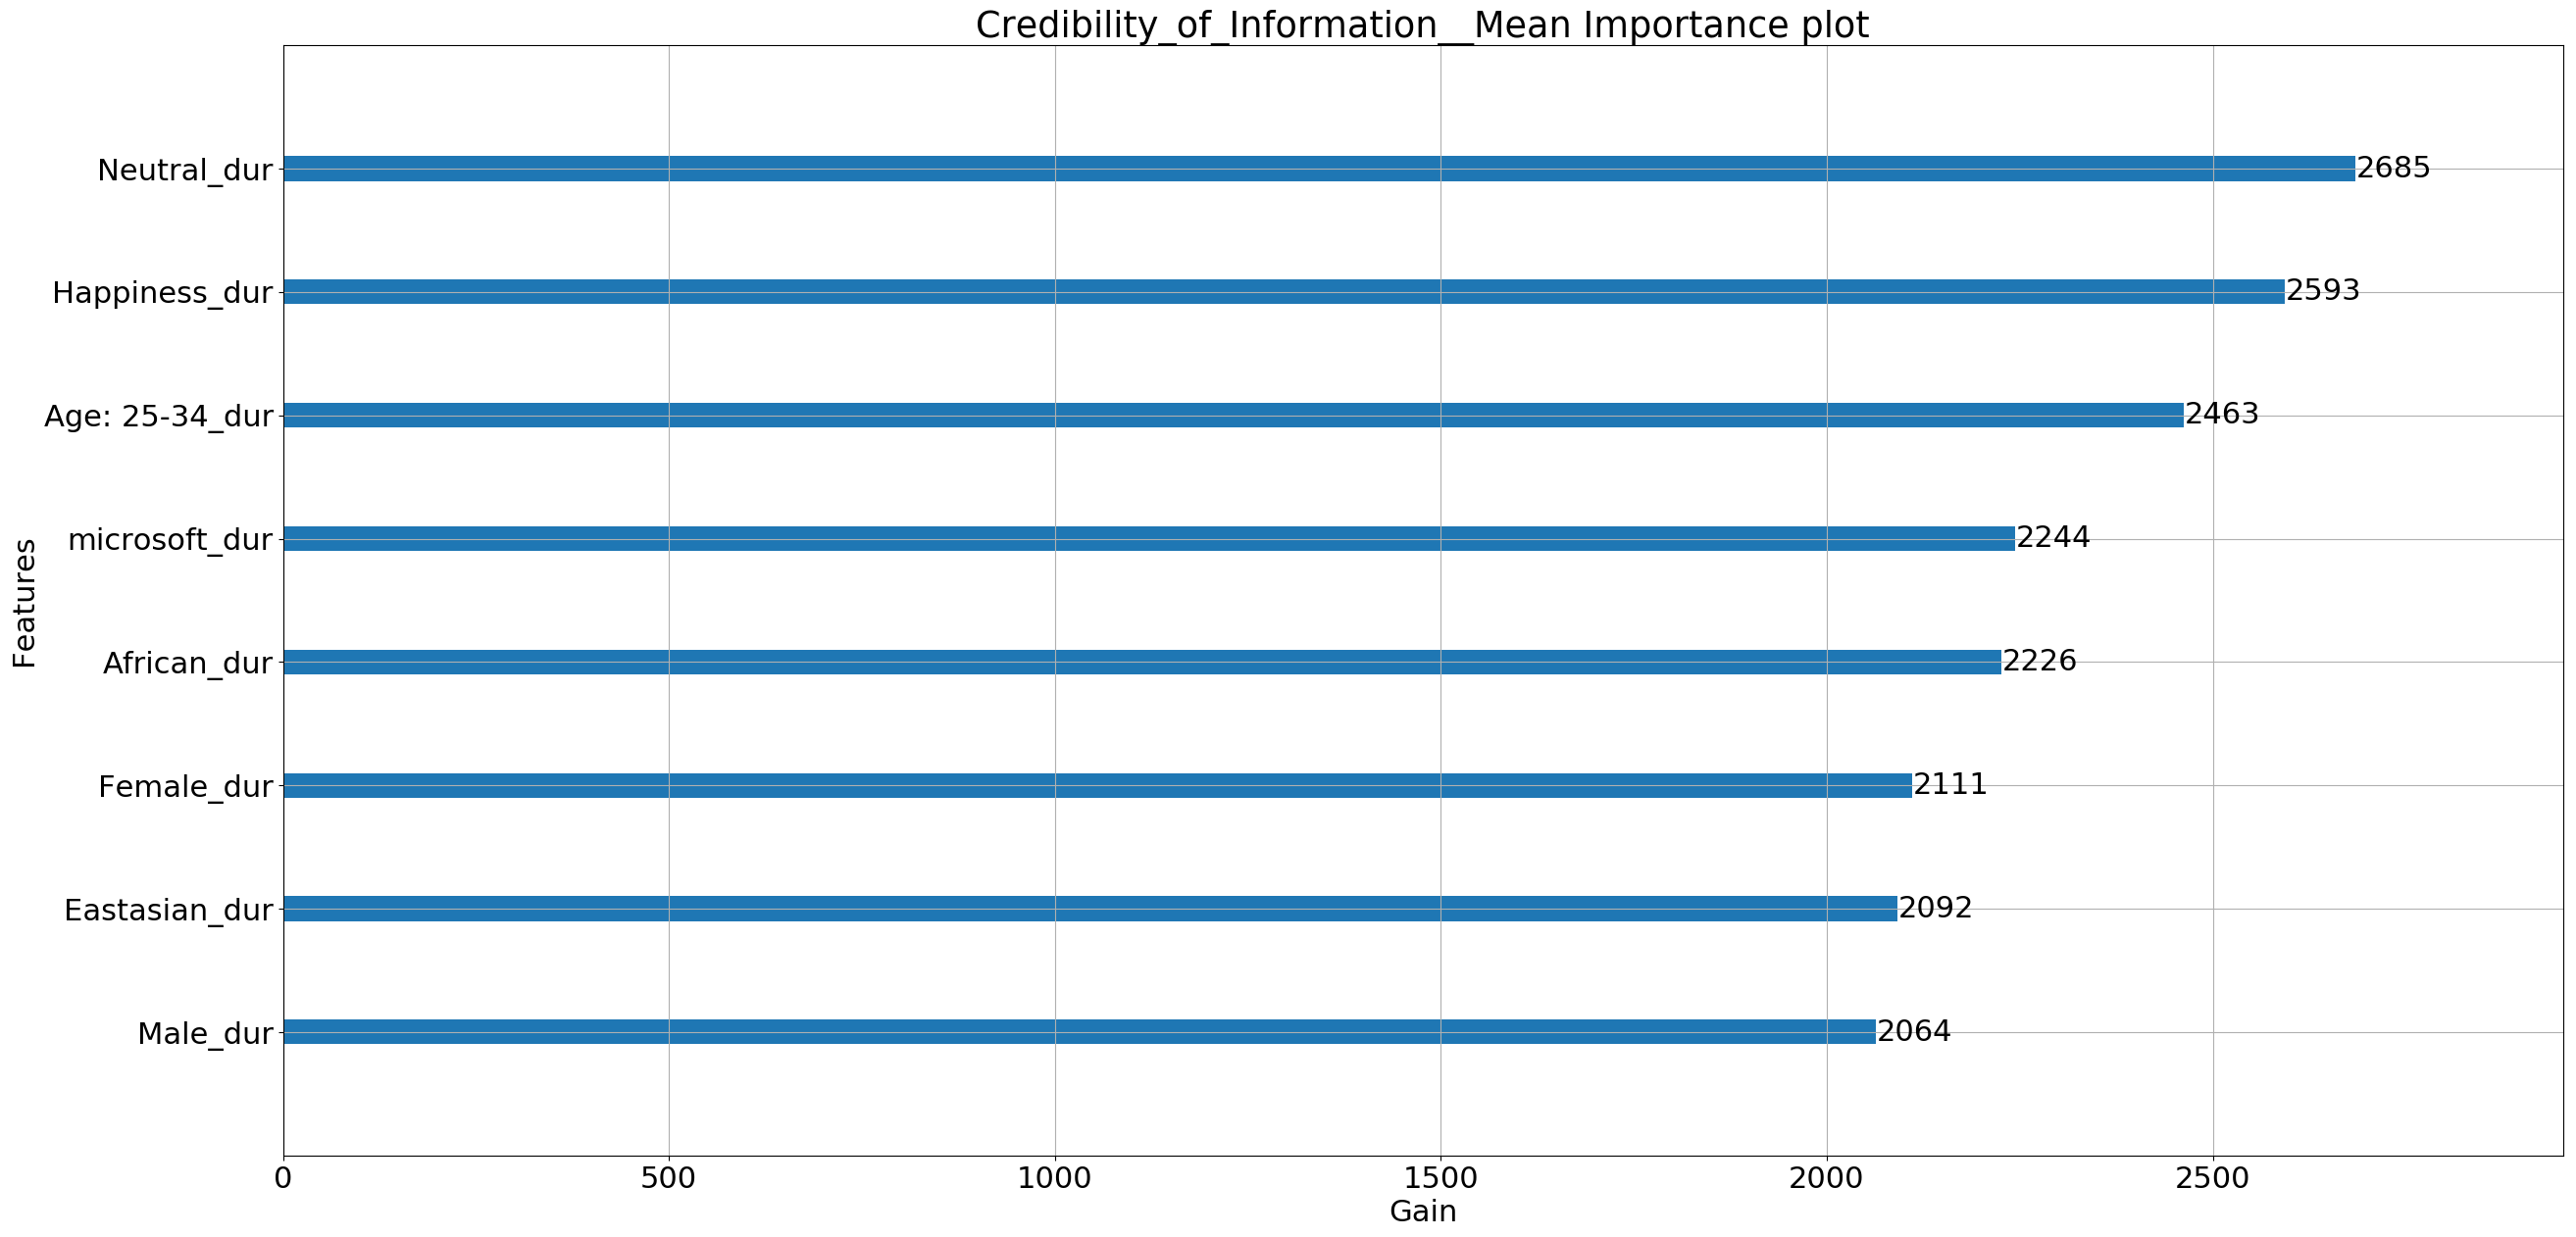

Brand_Difference__Mean
microsoft_last_ocr
Laptop_last_ocr
length_of_ad_15
Dell_text_dur
Laptop_first_ocr
Windows_last_ocr
microsoft_first_ocr
Hp_text_dur
Tablet_total_ocr
Asus_dur
Happiness_dur
Tablet_first_ocr
Dell_dur
Tablet_last_ocr
ASUS T102_dur
Dell_sub_brand_group_dur
Asus_text_dur
Windows_first_ocr
Lenovo_text_dur
Laptop_dur
Laptop_total_ocr
Tablet_dur
Age: 15-24_dur
microsoft_total_ocr
Hp_text_total_ocr
Lenovo_group_dur
Neutral_dur
Hp_text_last_ocr
Hp_text_first_ocr
microsoft_dur
HP_group_dur
Windows_dur
Sadness_dur
Windows_total_ocr
Hp_dur
Age: 25-34_dur
Hp_total_ocr
Yoga_dur
Eastasian_dur
Hp_first_ocr
Hp_last_ocr
Female_dur
African_dur
Age: 35-44_dur
Surface_group_dur
Male_dur
Currys PCs world_text_dur
Apple_dur
Macbook_group_dur


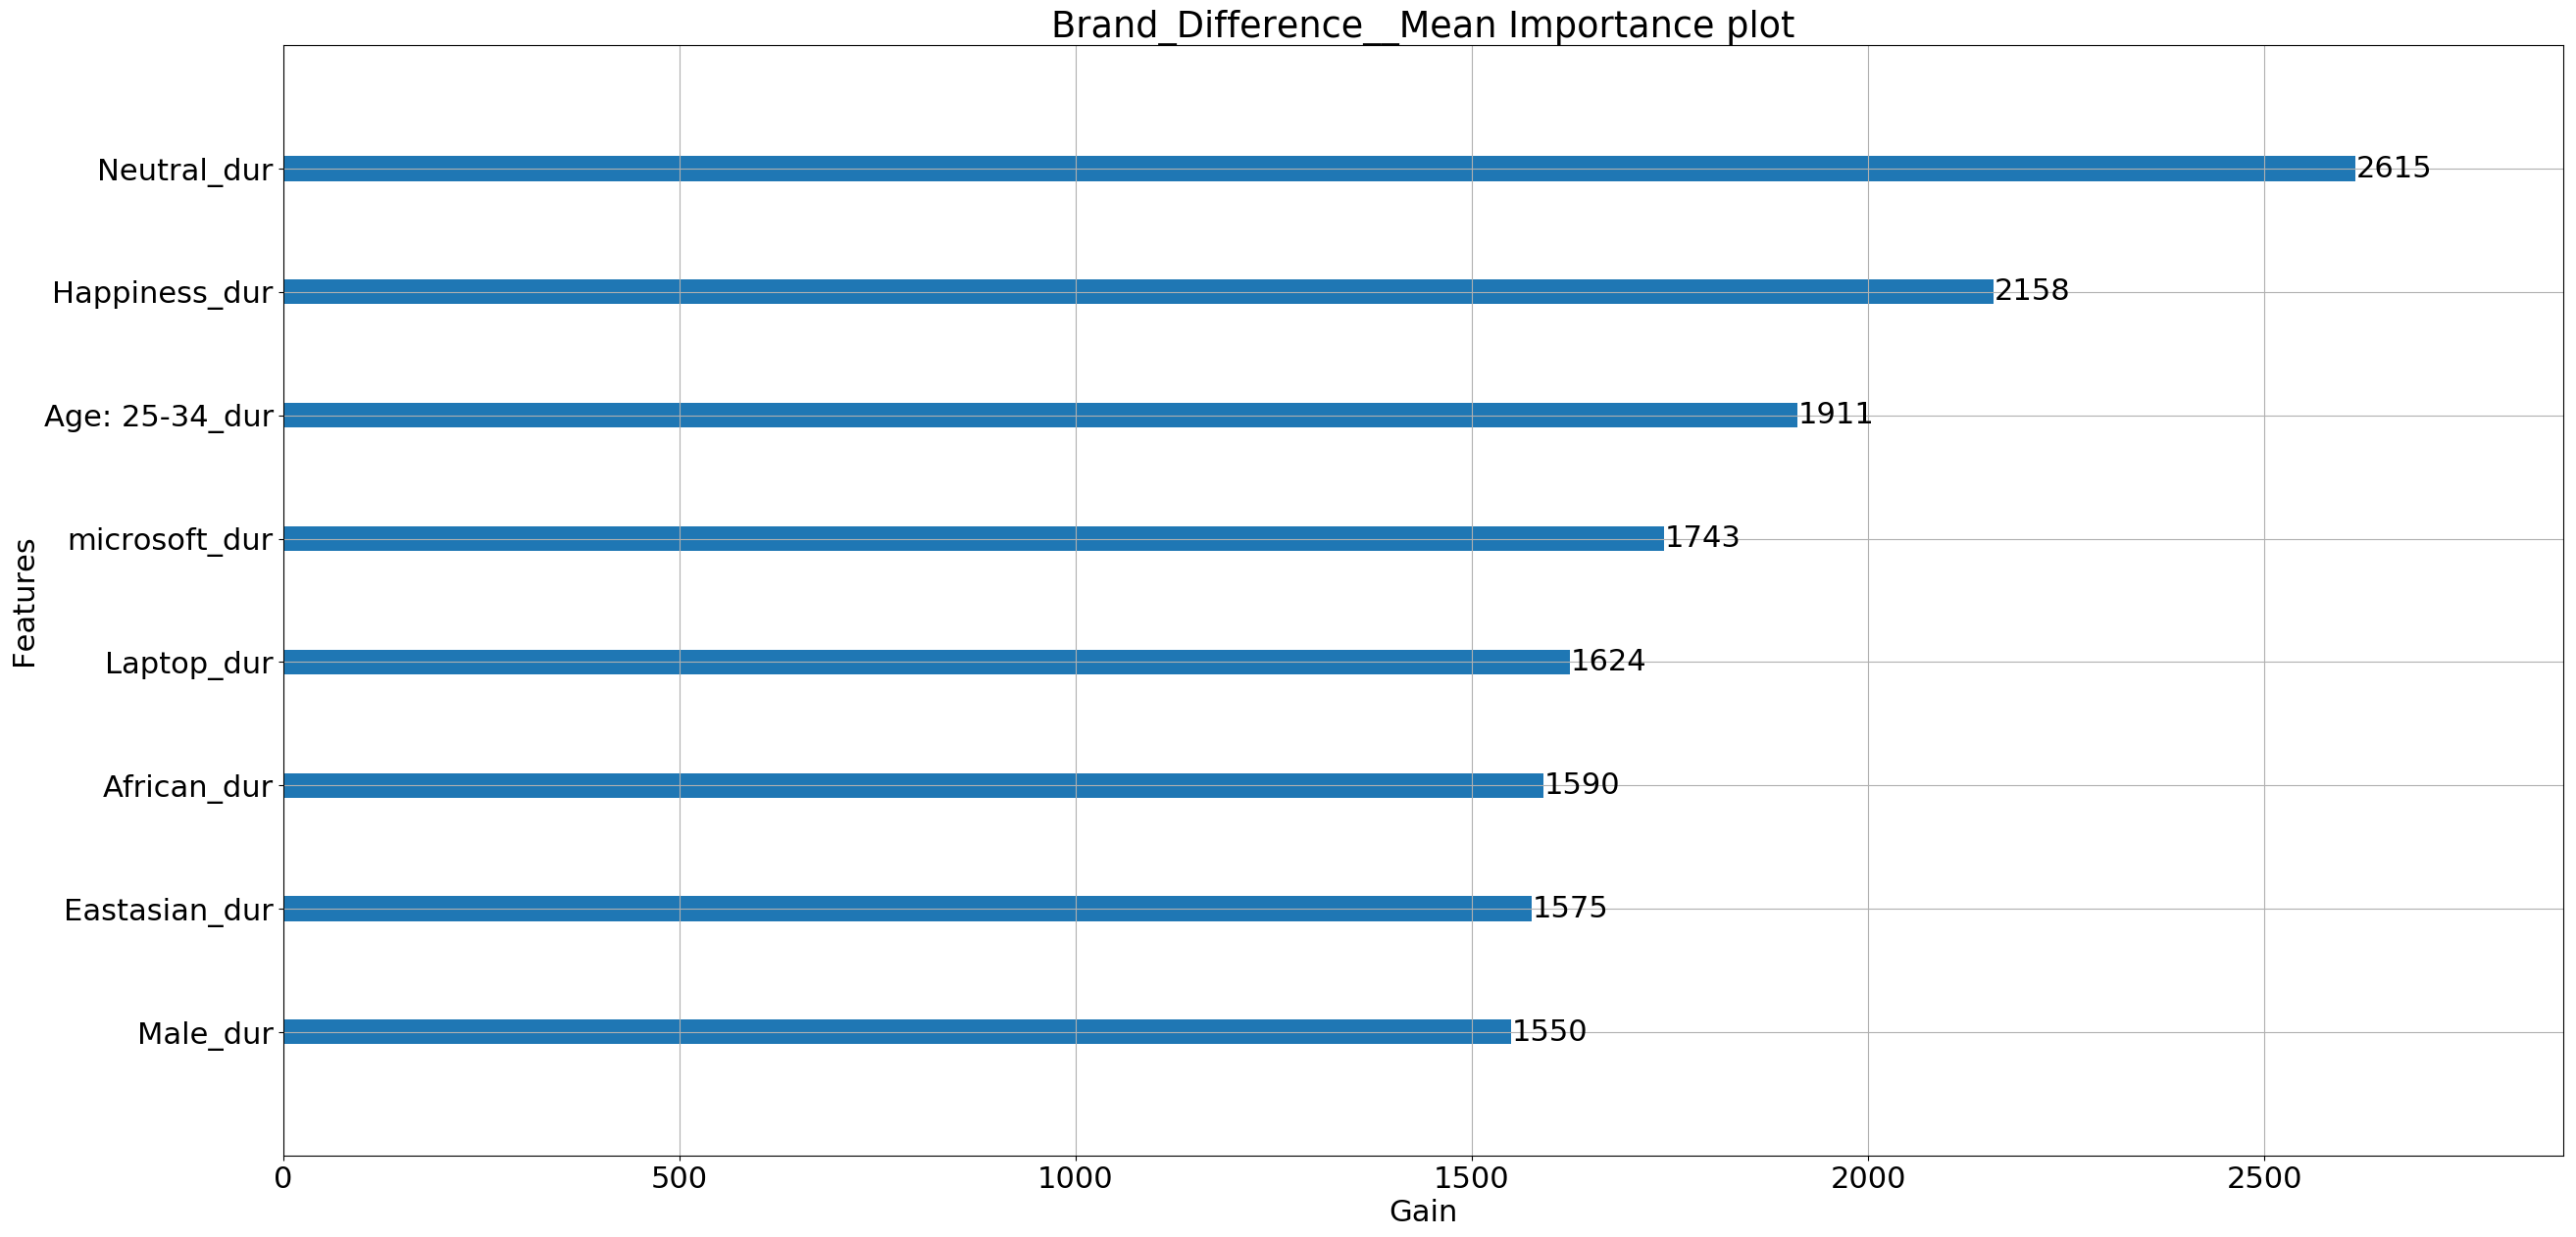

Interest_peak
Dell_text_dur
length_of_ad_15
Windows_first_ocr
Windows_last_ocr
Dell_dur
microsoft_first_ocr
microsoft_dur
Laptop_last_ocr
Asus_dur
ASUS T102_dur
Laptop_dur
microsoft_total_ocr
Laptop_total_ocr
Tablet_total_ocr
Tablet_first_ocr
microsoft_last_ocr
Happiness_dur
Lenovo_text_dur
Windows_dur
Laptop_first_ocr
Male_dur
Age: 15-24_dur
Hp_last_ocr
Tablet_last_ocr
Yoga_dur
Asus_text_dur
Female_dur
Hp_total_ocr
Lenovo_group_dur
Hp_dur
Hp_text_total_ocr
Windows_total_ocr
Neutral_dur
Hp_first_ocr
Eastasian_dur
Tablet_dur
African_dur
Hp_text_first_ocr
Hp_text_dur
Age: 25-34_dur
Sadness_dur
Hp_text_last_ocr
Age: 35-44_dur
HP_group_dur
Dell_sub_brand_group_dur
Surface_group_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


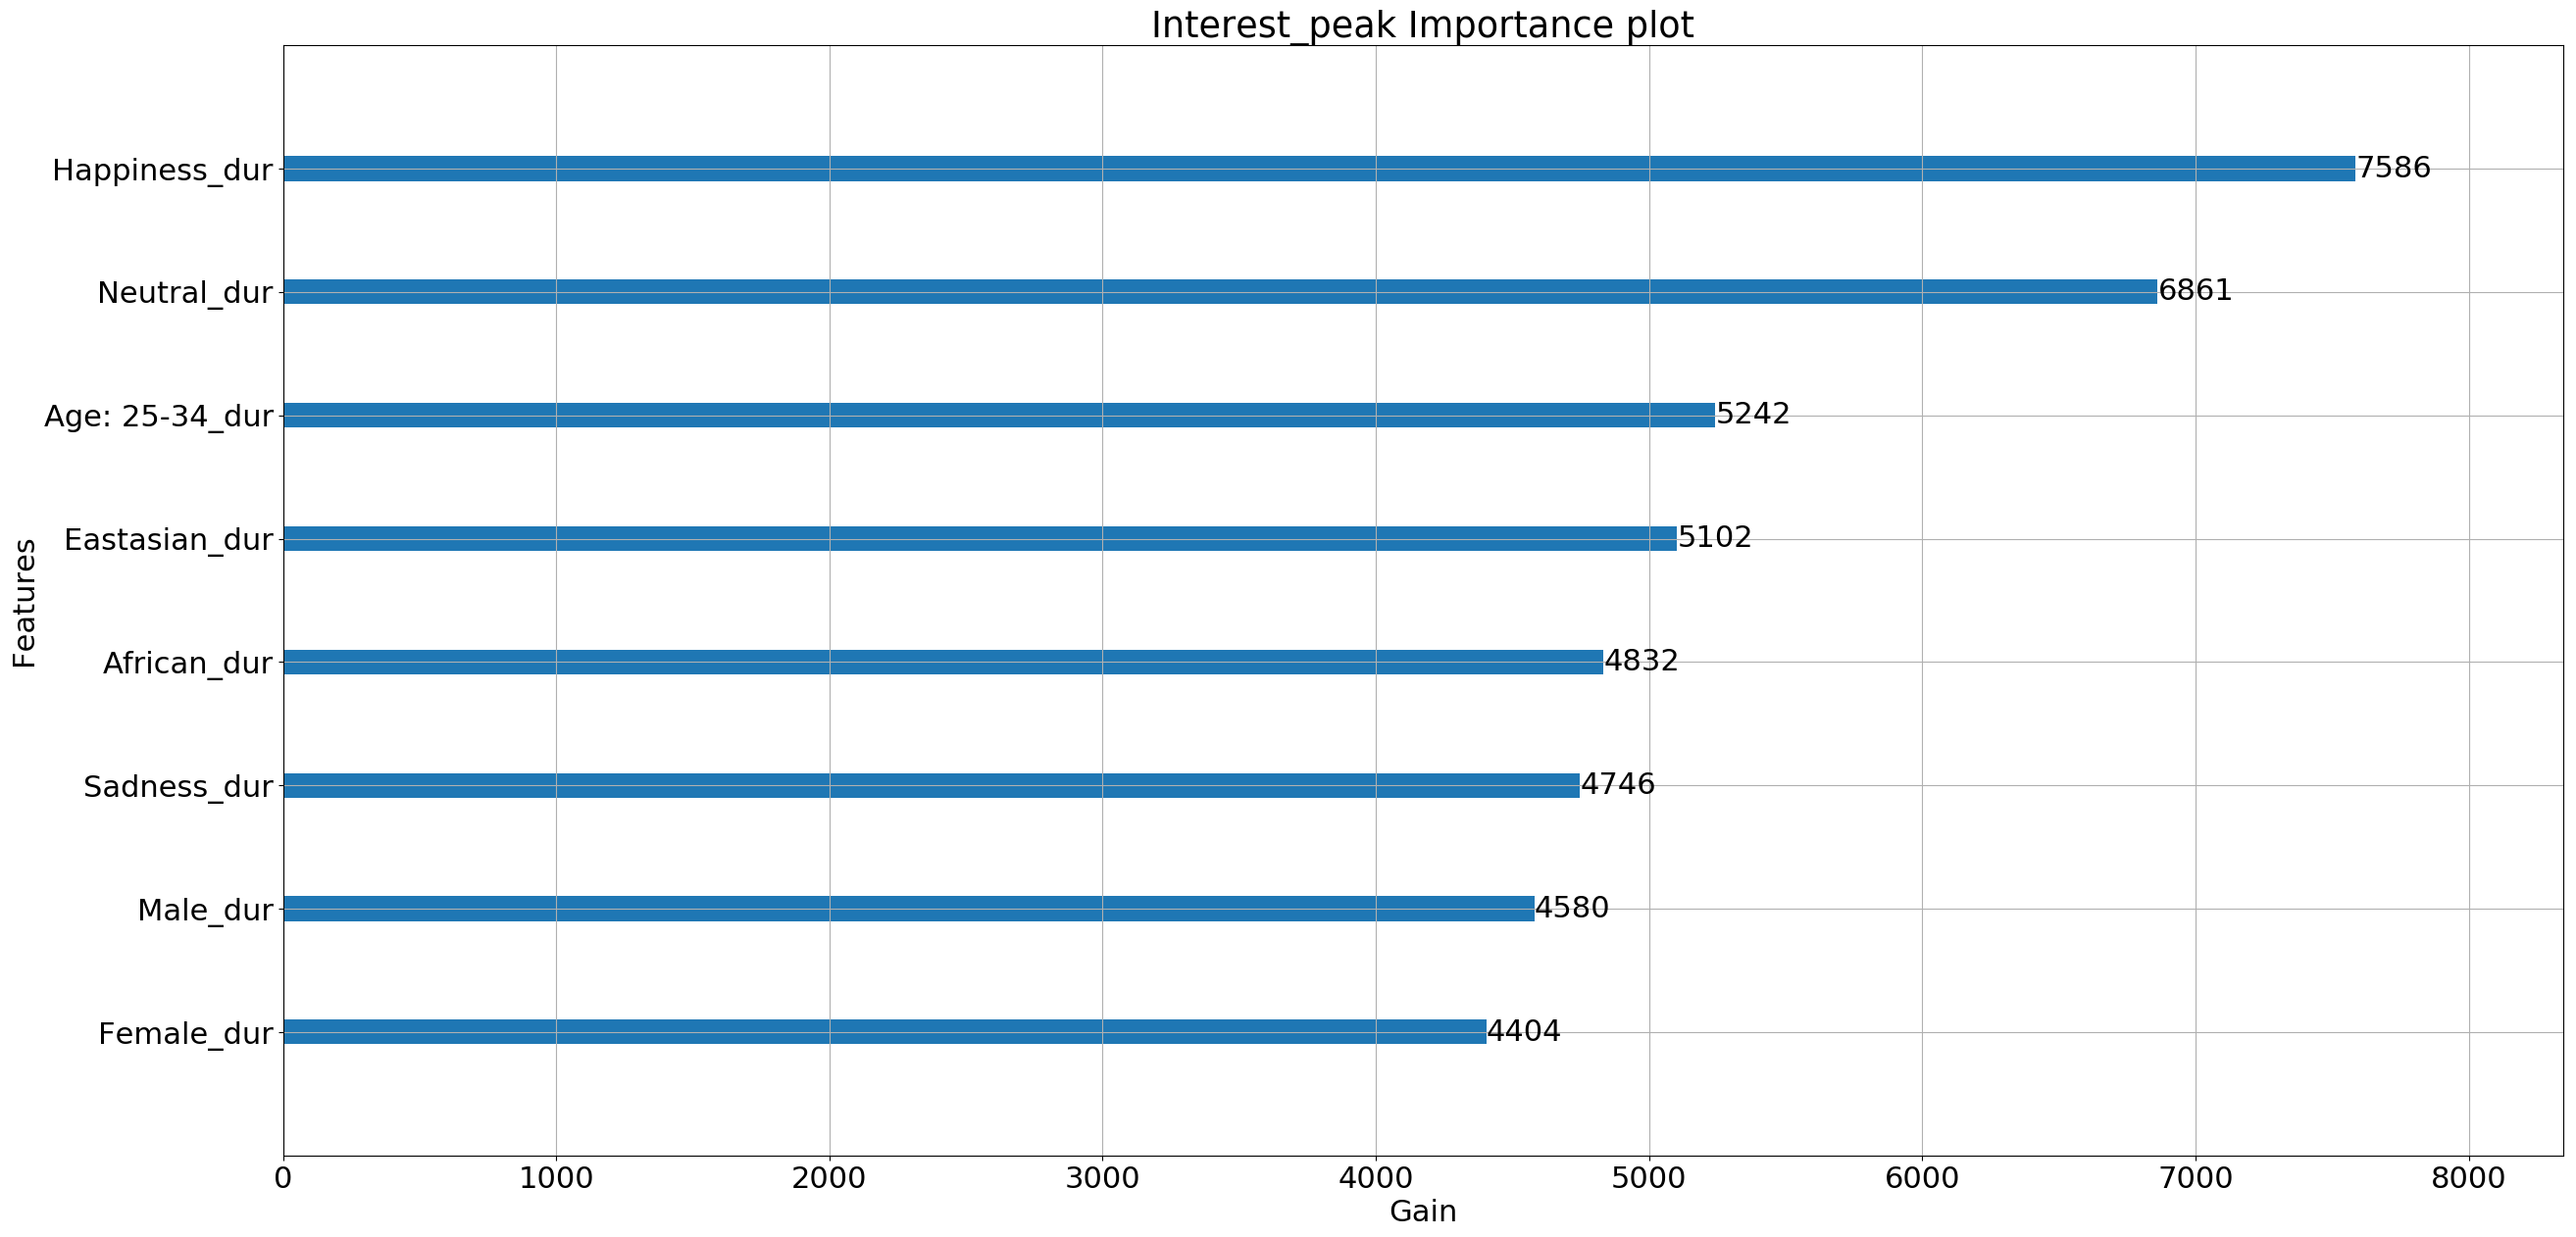

Interest_mean_score
length_of_ad_15
Windows_last_ocr
Windows_first_ocr
Hp_text_dur
Laptop_last_ocr
microsoft_last_ocr
Hp_text_total_ocr
Windows_dur
Hp_text_last_ocr
microsoft_first_ocr
Laptop_total_ocr
Hp_text_first_ocr
Dell_text_dur
Laptop_first_ocr
Laptop_dur
Hp_total_ocr
microsoft_dur
Hp_dur
microsoft_total_ocr
Happiness_dur
Eastasian_dur
Hp_first_ocr
Dell_sub_brand_group_dur
Lenovo_text_dur
Tablet_first_ocr
Hp_last_ocr
Tablet_dur
Lenovo_group_dur
Asus_text_dur
Windows_total_ocr
Dell_dur
Tablet_total_ocr
Asus_dur
ASUS T102_dur
Female_dur
Surface_group_dur
Age: 25-34_dur
Yoga_dur
Tablet_last_ocr
Male_dur
African_dur
Neutral_dur
Age: 15-24_dur
Sadness_dur
Age: 35-44_dur
HP_group_dur
Currys PCs world_text_dur
Apple_dur
Macbook_group_dur


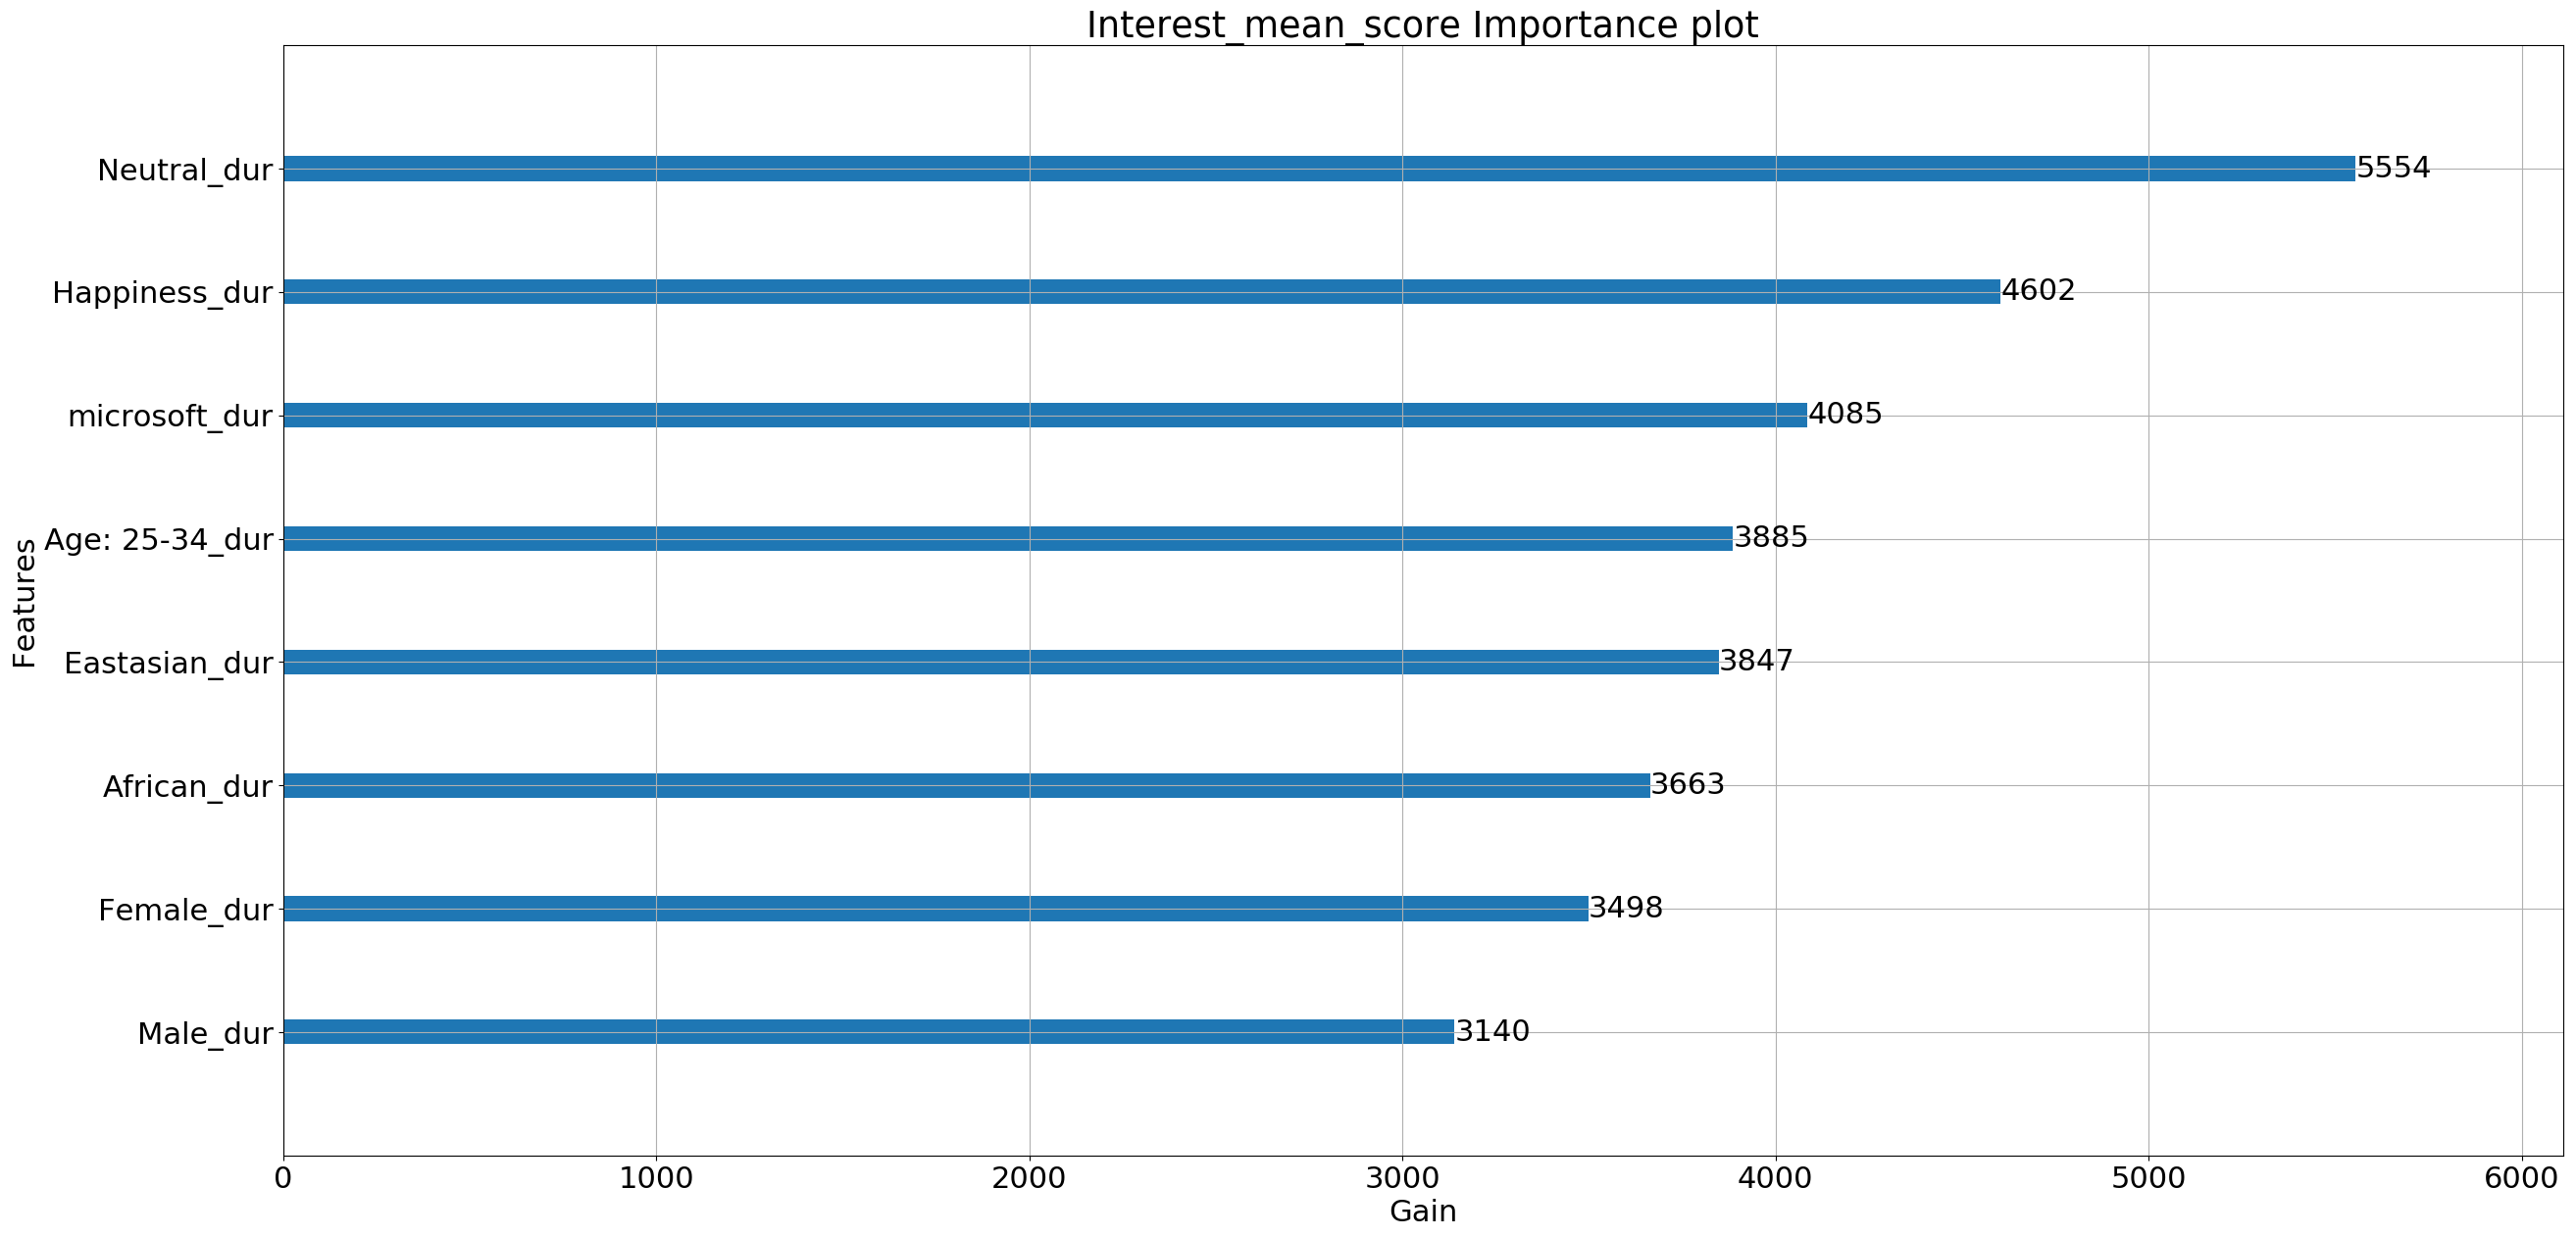

Purchase_intent
Dell_text_dur
Dell_sub_brand_group_dur
length_of_ad_15
Dell_dur
Windows_last_ocr
microsoft_last_ocr
Hp_text_first_ocr
Hp_text_last_ocr
Laptop_last_ocr
microsoft_total_ocr
microsoft_first_ocr
Hp_last_ocr
Laptop_dur
microsoft_dur
Laptop_first_ocr
Windows_first_ocr
Laptop_total_ocr
Hp_text_total_ocr
Tablet_total_ocr
Hp_first_ocr
Windows_dur
Tablet_dur
Asus_text_dur
Hp_text_dur
Happiness_dur
Windows_total_ocr
ASUS T102_dur
Tablet_first_ocr
Male_dur
Neutral_dur
Hp_dur
Hp_total_ocr
Eastasian_dur
Age: 25-34_dur
Sadness_dur
Lenovo_text_dur
Lenovo_group_dur
Asus_dur
Tablet_last_ocr
Yoga_dur
Female_dur
Age: 15-24_dur
African_dur
Surface_group_dur
HP_group_dur
Age: 35-44_dur
Apple_dur
Currys PCs world_text_dur
Macbook_group_dur


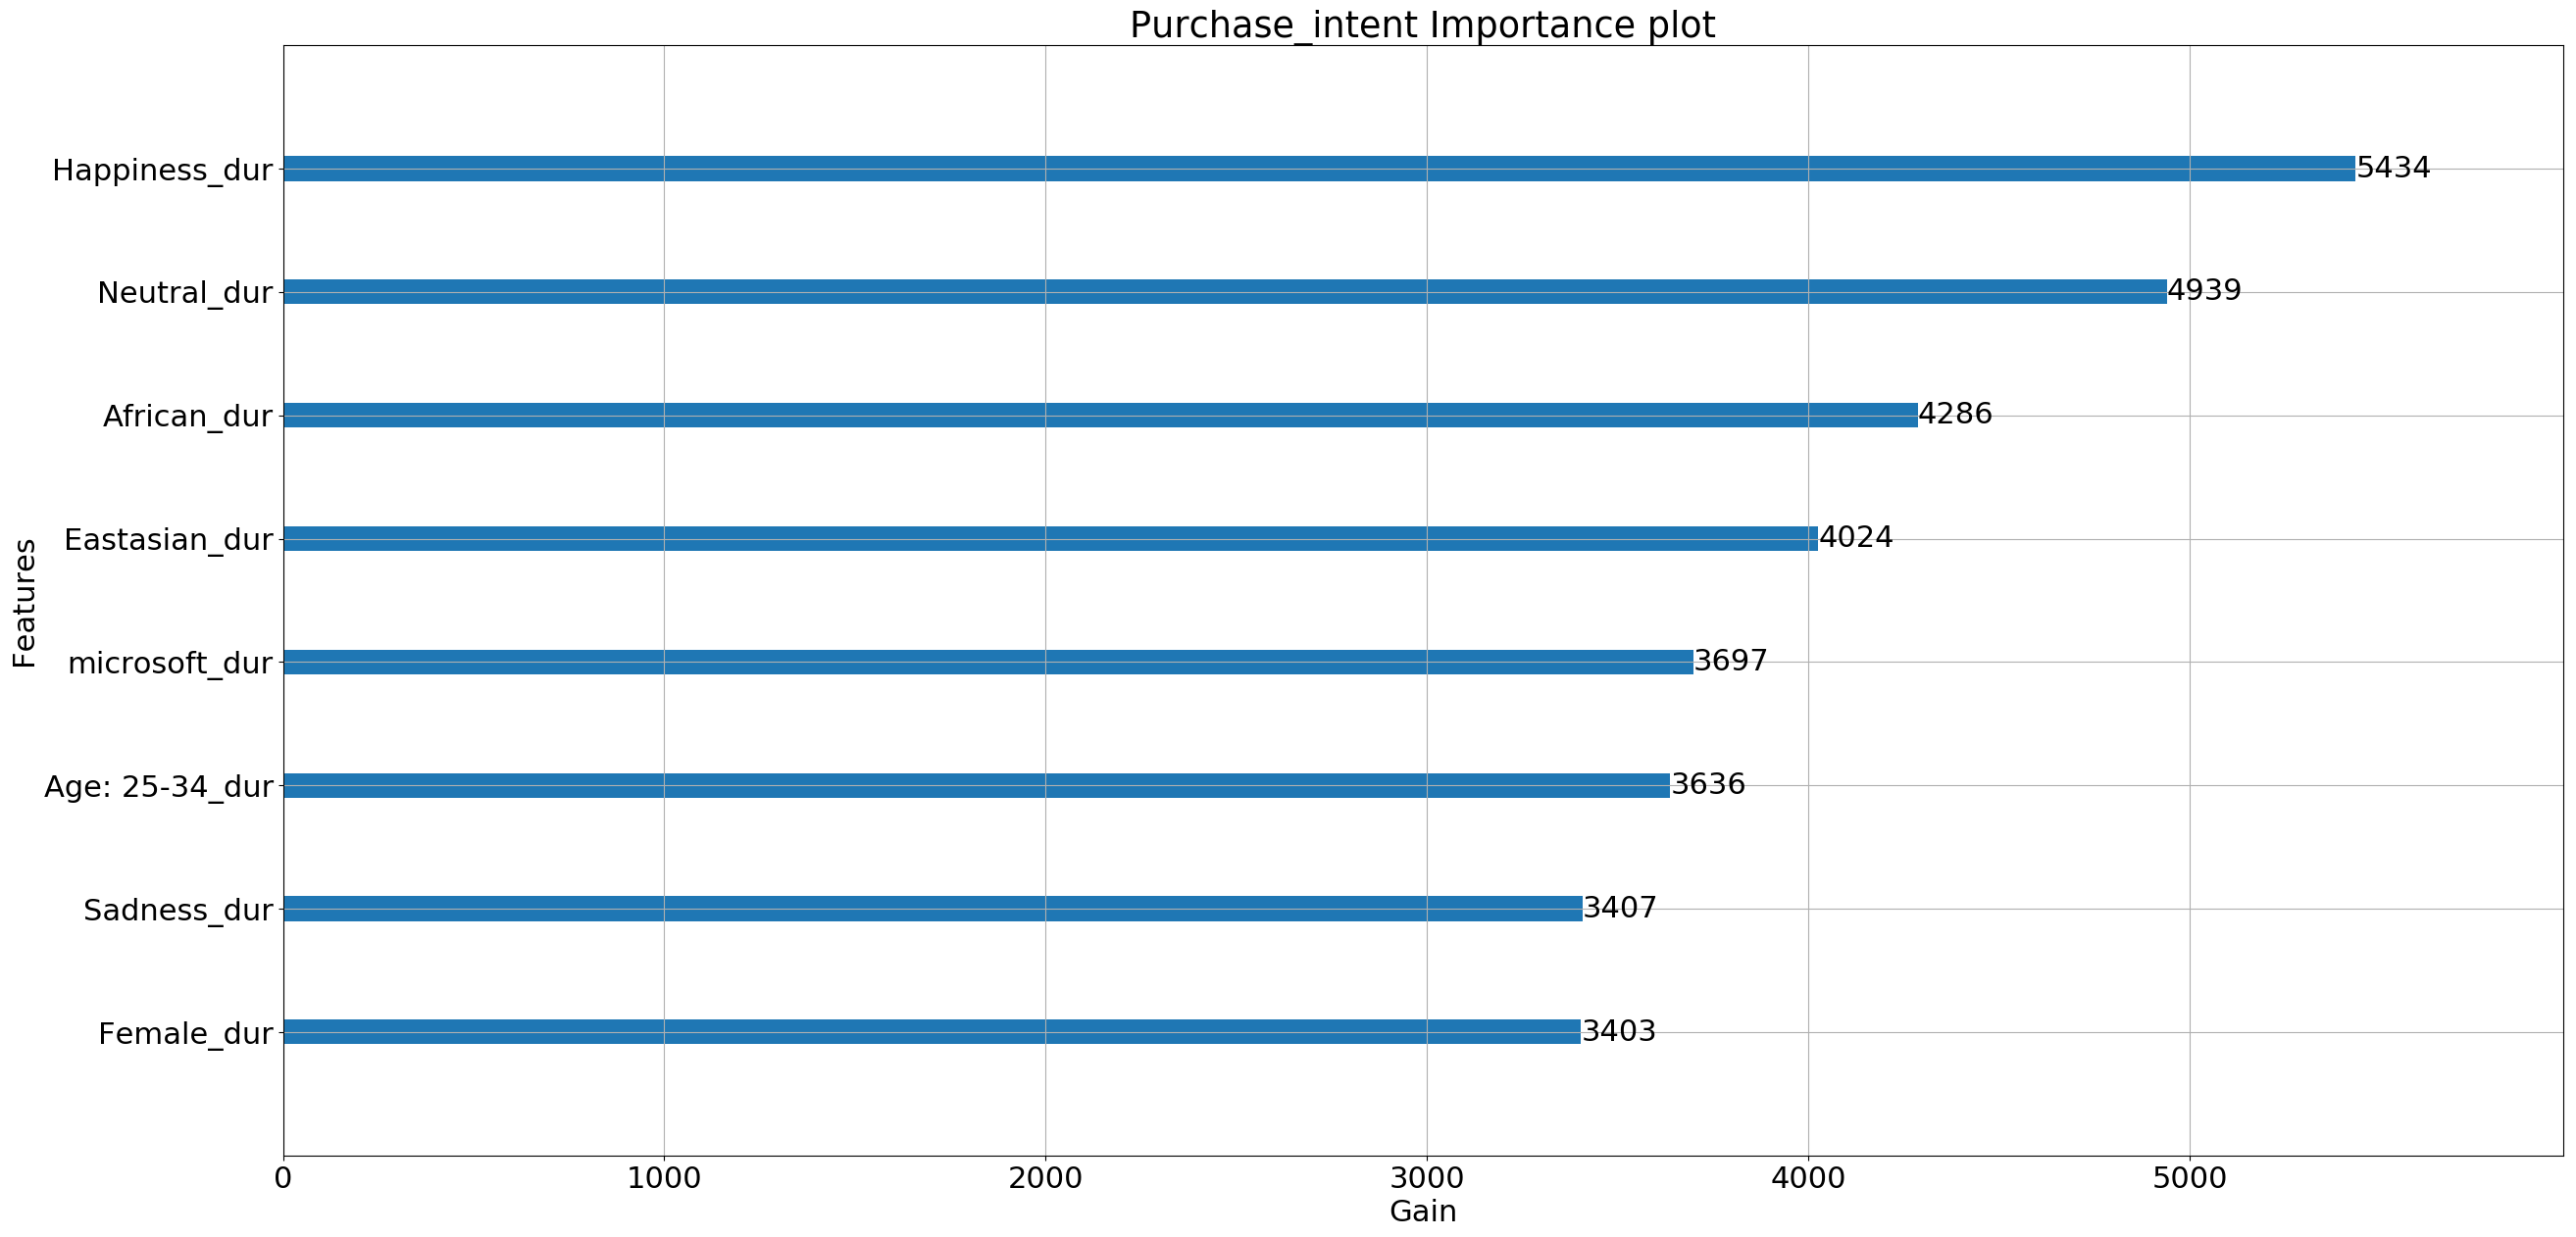

Persuasion_mean
length_of_ad_15
Dell_text_dur
Dell_dur
Lenovo_group_dur
Lenovo_text_dur
microsoft_first_ocr
Laptop_last_ocr
Yoga_dur
Neutral_dur
Laptop_first_ocr
Sadness_dur
microsoft_dur
Happiness_dur
microsoft_last_ocr
Male_dur
Hp_first_ocr
Eastasian_dur
Age: 25-34_dur
Windows_last_ocr
Laptop_total_ocr
Hp_last_ocr
African_dur
Asus_dur
ASUS T102_dur
Laptop_dur
Windows_first_ocr
Female_dur
microsoft_total_ocr
Dell_sub_brand_group_dur
Hp_dur
Age: 35-44_dur
HP_group_dur
Asus_text_dur
Tablet_dur
Hp_total_ocr
Windows_dur
Hp_text_dur
Age: 15-24_dur
Tablet_last_ocr
Tablet_total_ocr
Tablet_first_ocr
Hp_text_last_ocr
Hp_text_first_ocr
Windows_total_ocr
Surface_group_dur
Hp_text_total_ocr
Apple_dur
Macbook_group_dur
Currys PCs world_text_dur


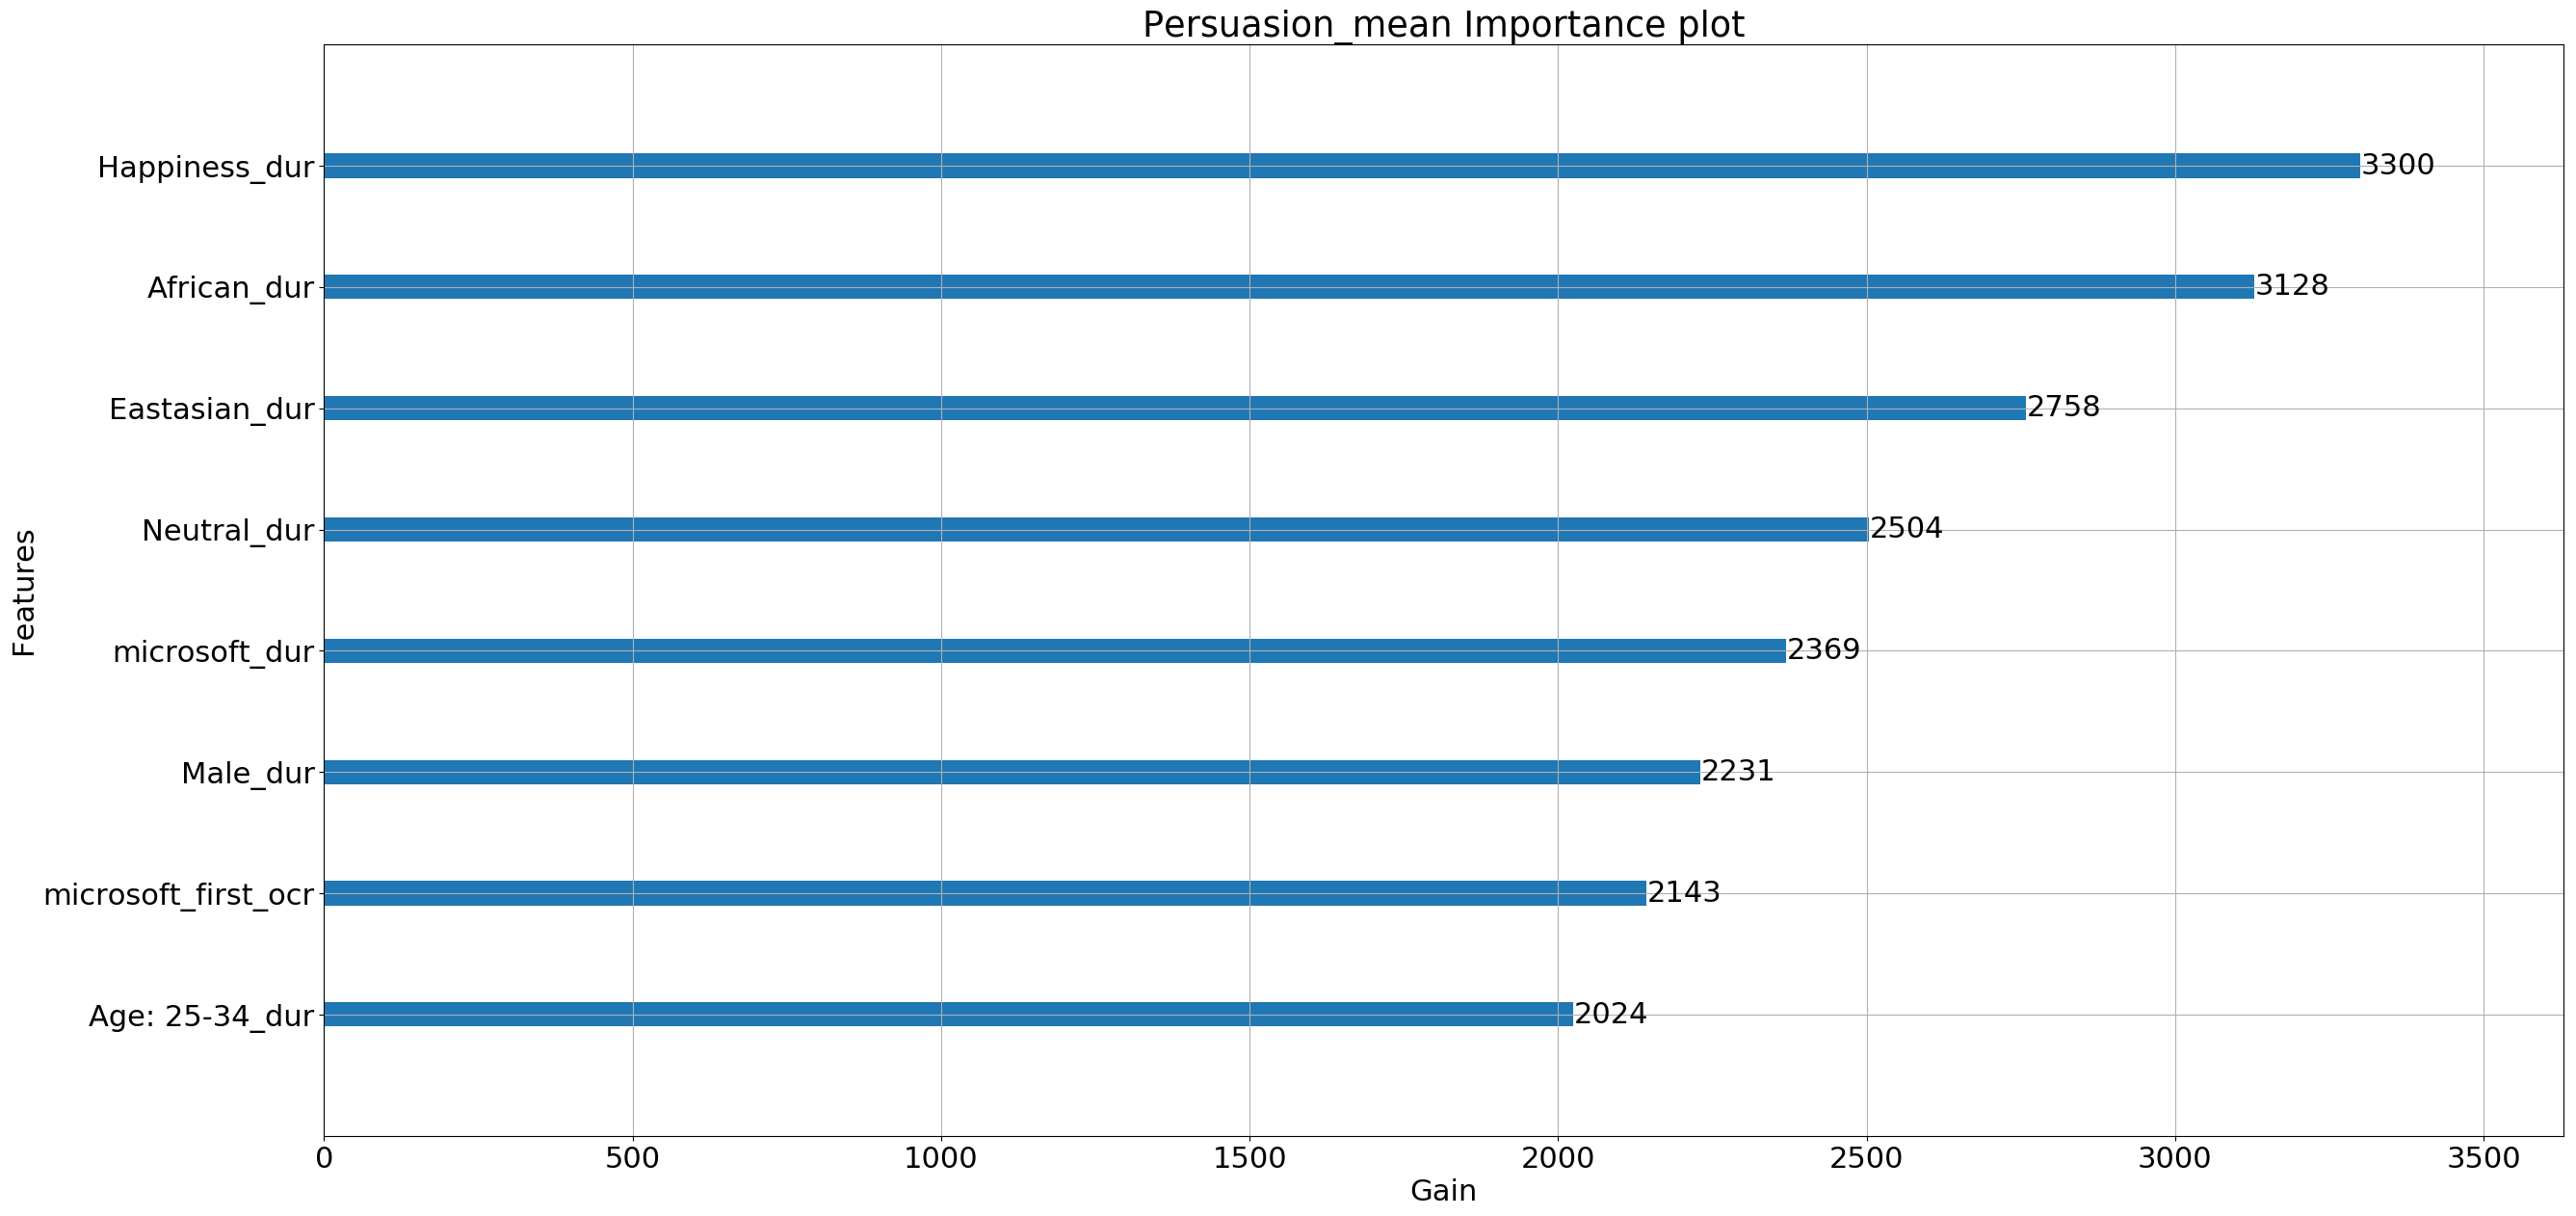

Persuasion_very_likely
Dell_text_dur
Dell_dur
Laptop_last_ocr
Lenovo_text_dur
ASUS T102_dur
Lenovo_group_dur
microsoft_first_ocr
Neutral_dur
Hp_text_total_ocr
Laptop_first_ocr
microsoft_last_ocr
Age: 35-44_dur
Dell_sub_brand_group_dur
Happiness_dur
Sadness_dur
Windows_first_ocr
Hp_last_ocr
Female_dur
Tablet_first_ocr
microsoft_total_ocr
Laptop_dur
Hp_first_ocr
Age: 25-34_dur
Laptop_total_ocr
Hp_text_first_ocr
Hp_total_ocr
Hp_text_dur
Male_dur
microsoft_dur
Tablet_dur
Eastasian_dur
Windows_total_ocr
Windows_dur
African_dur
Windows_last_ocr
length_of_ad_15
Hp_dur
Asus_dur
Age: 15-24_dur
Asus_text_dur
Tablet_last_ocr
Hp_text_last_ocr
Tablet_total_ocr
HP_group_dur
Yoga_dur
Surface_group_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


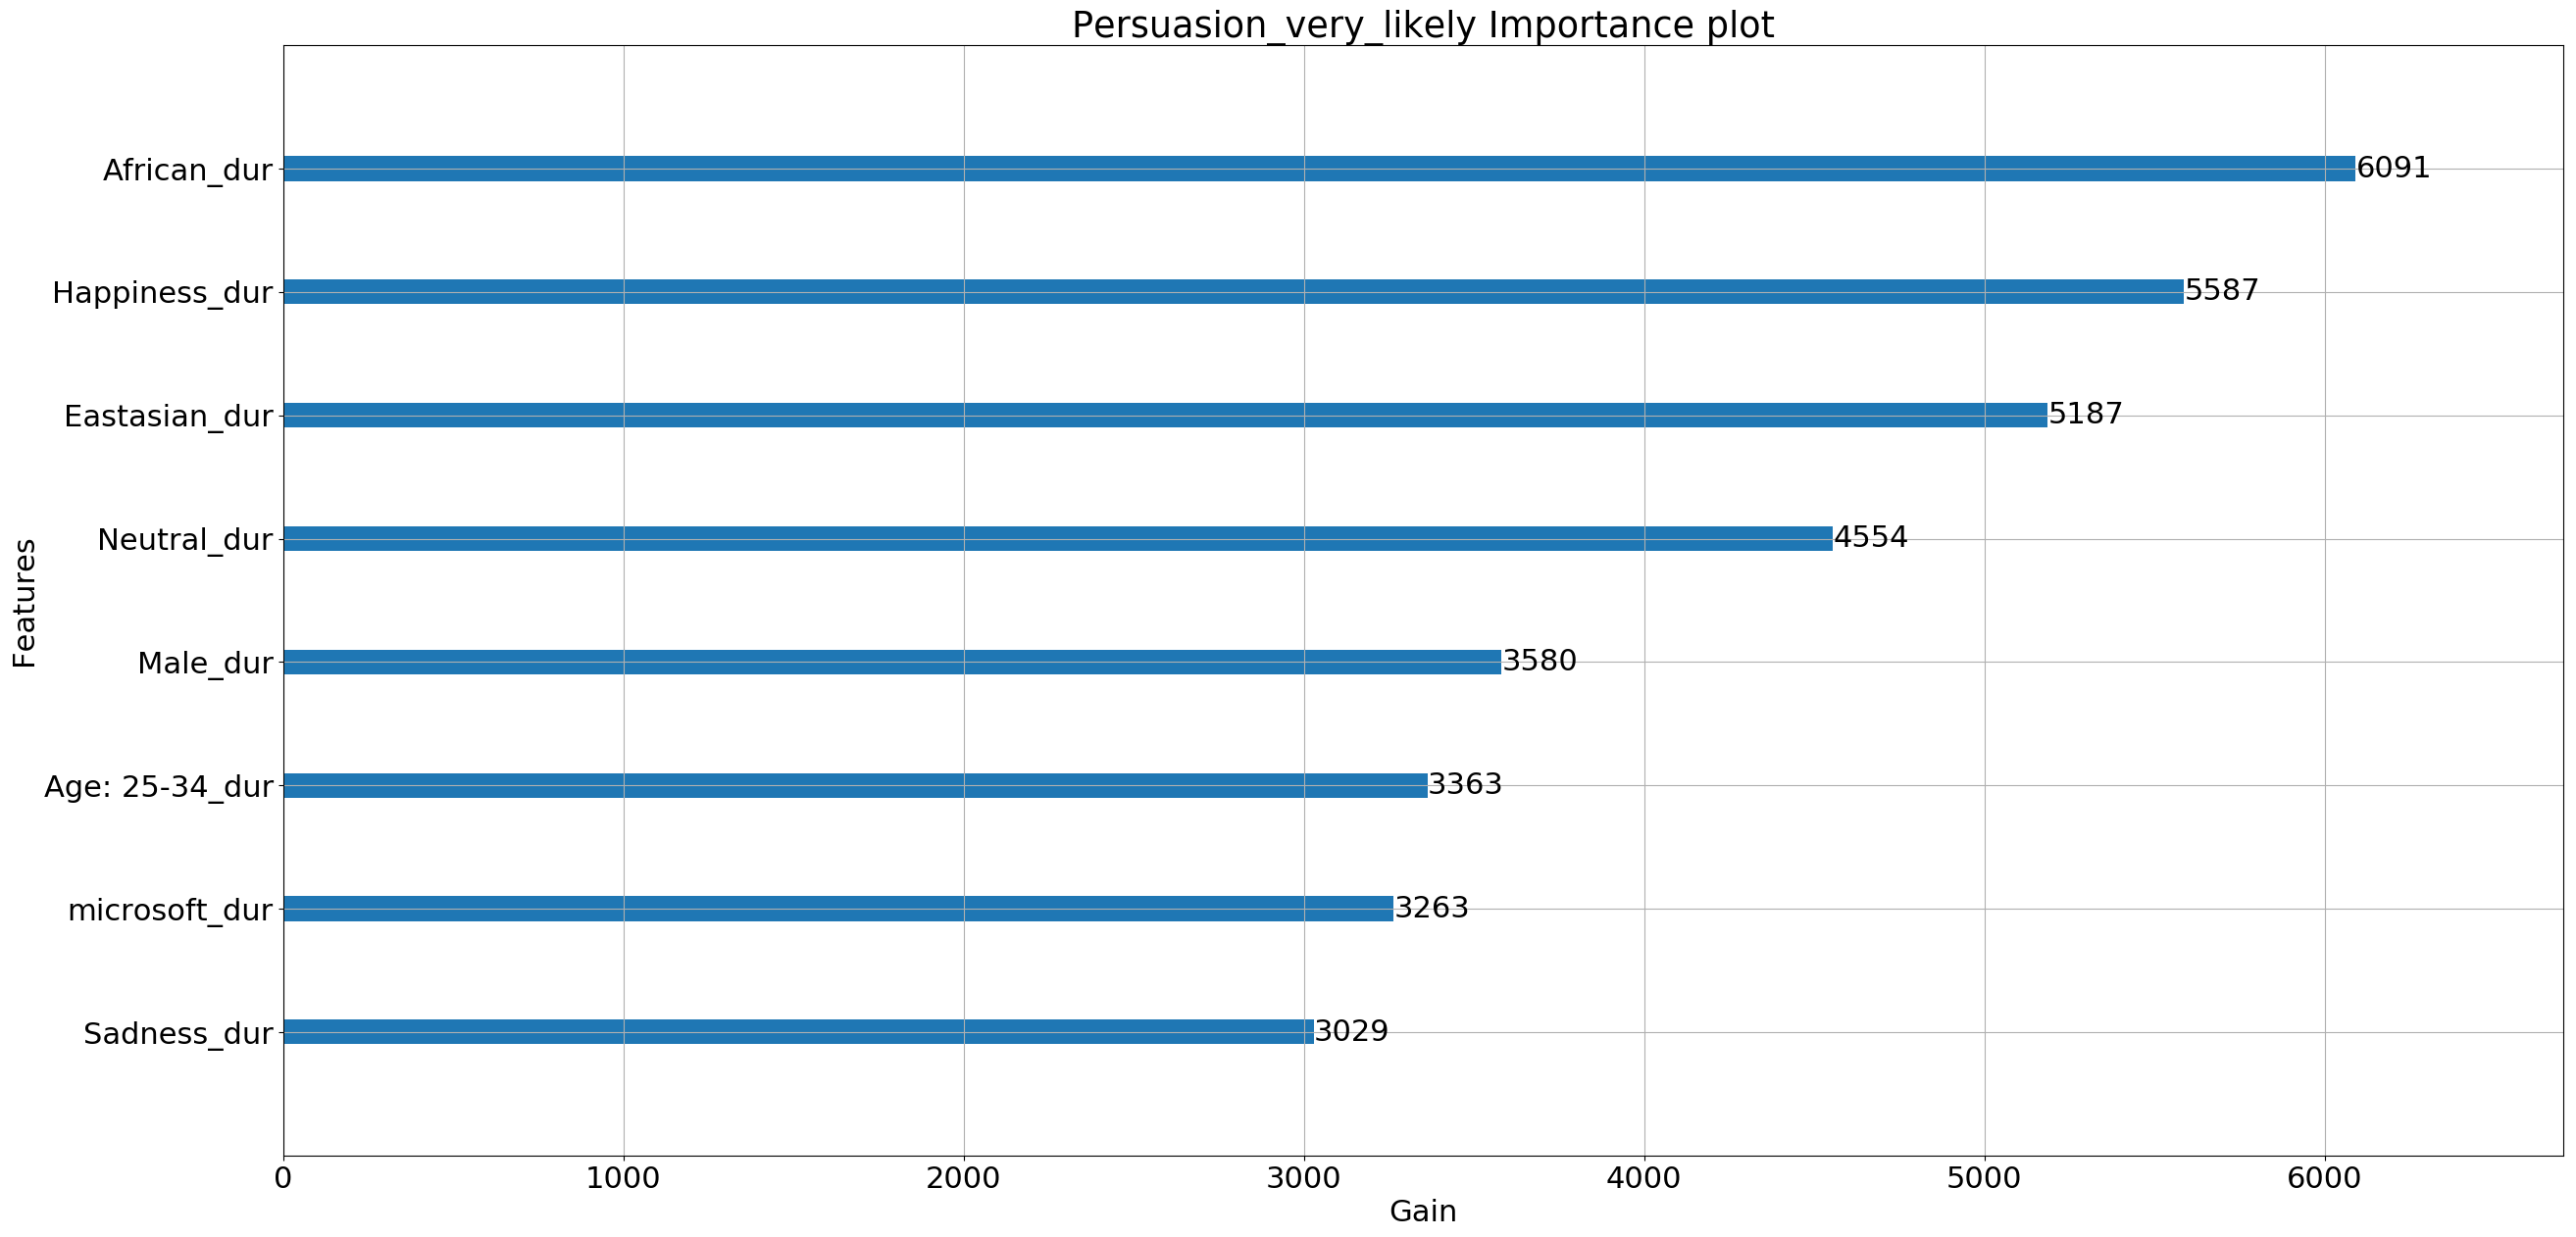

Interest_peak_frames
Dell_text_dur
length_of_ad_15
Windows_last_ocr
Dell_dur
Windows_first_ocr
microsoft_first_ocr
microsoft_last_ocr
Tablet_total_ocr
Laptop_dur
Laptop_total_ocr
Laptop_first_ocr
microsoft_dur
ASUS T102_dur
Asus_text_dur
microsoft_total_ocr
Female_dur
Age: 15-24_dur
Laptop_last_ocr
Lenovo_text_dur
Tablet_dur
Hp_total_ocr
Neutral_dur
Windows_total_ocr
Yoga_dur
Male_dur
Happiness_dur
Age: 25-34_dur
Hp_text_total_ocr
Hp_first_ocr
Hp_last_ocr
Hp_text_dur
Hp_dur
Tablet_last_ocr
Tablet_first_ocr
HP_group_dur
Eastasian_dur
Hp_text_last_ocr
Windows_dur
Sadness_dur
African_dur
Hp_text_first_ocr
Lenovo_group_dur
Dell_sub_brand_group_dur
Age: 35-44_dur
Asus_dur
Surface_group_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


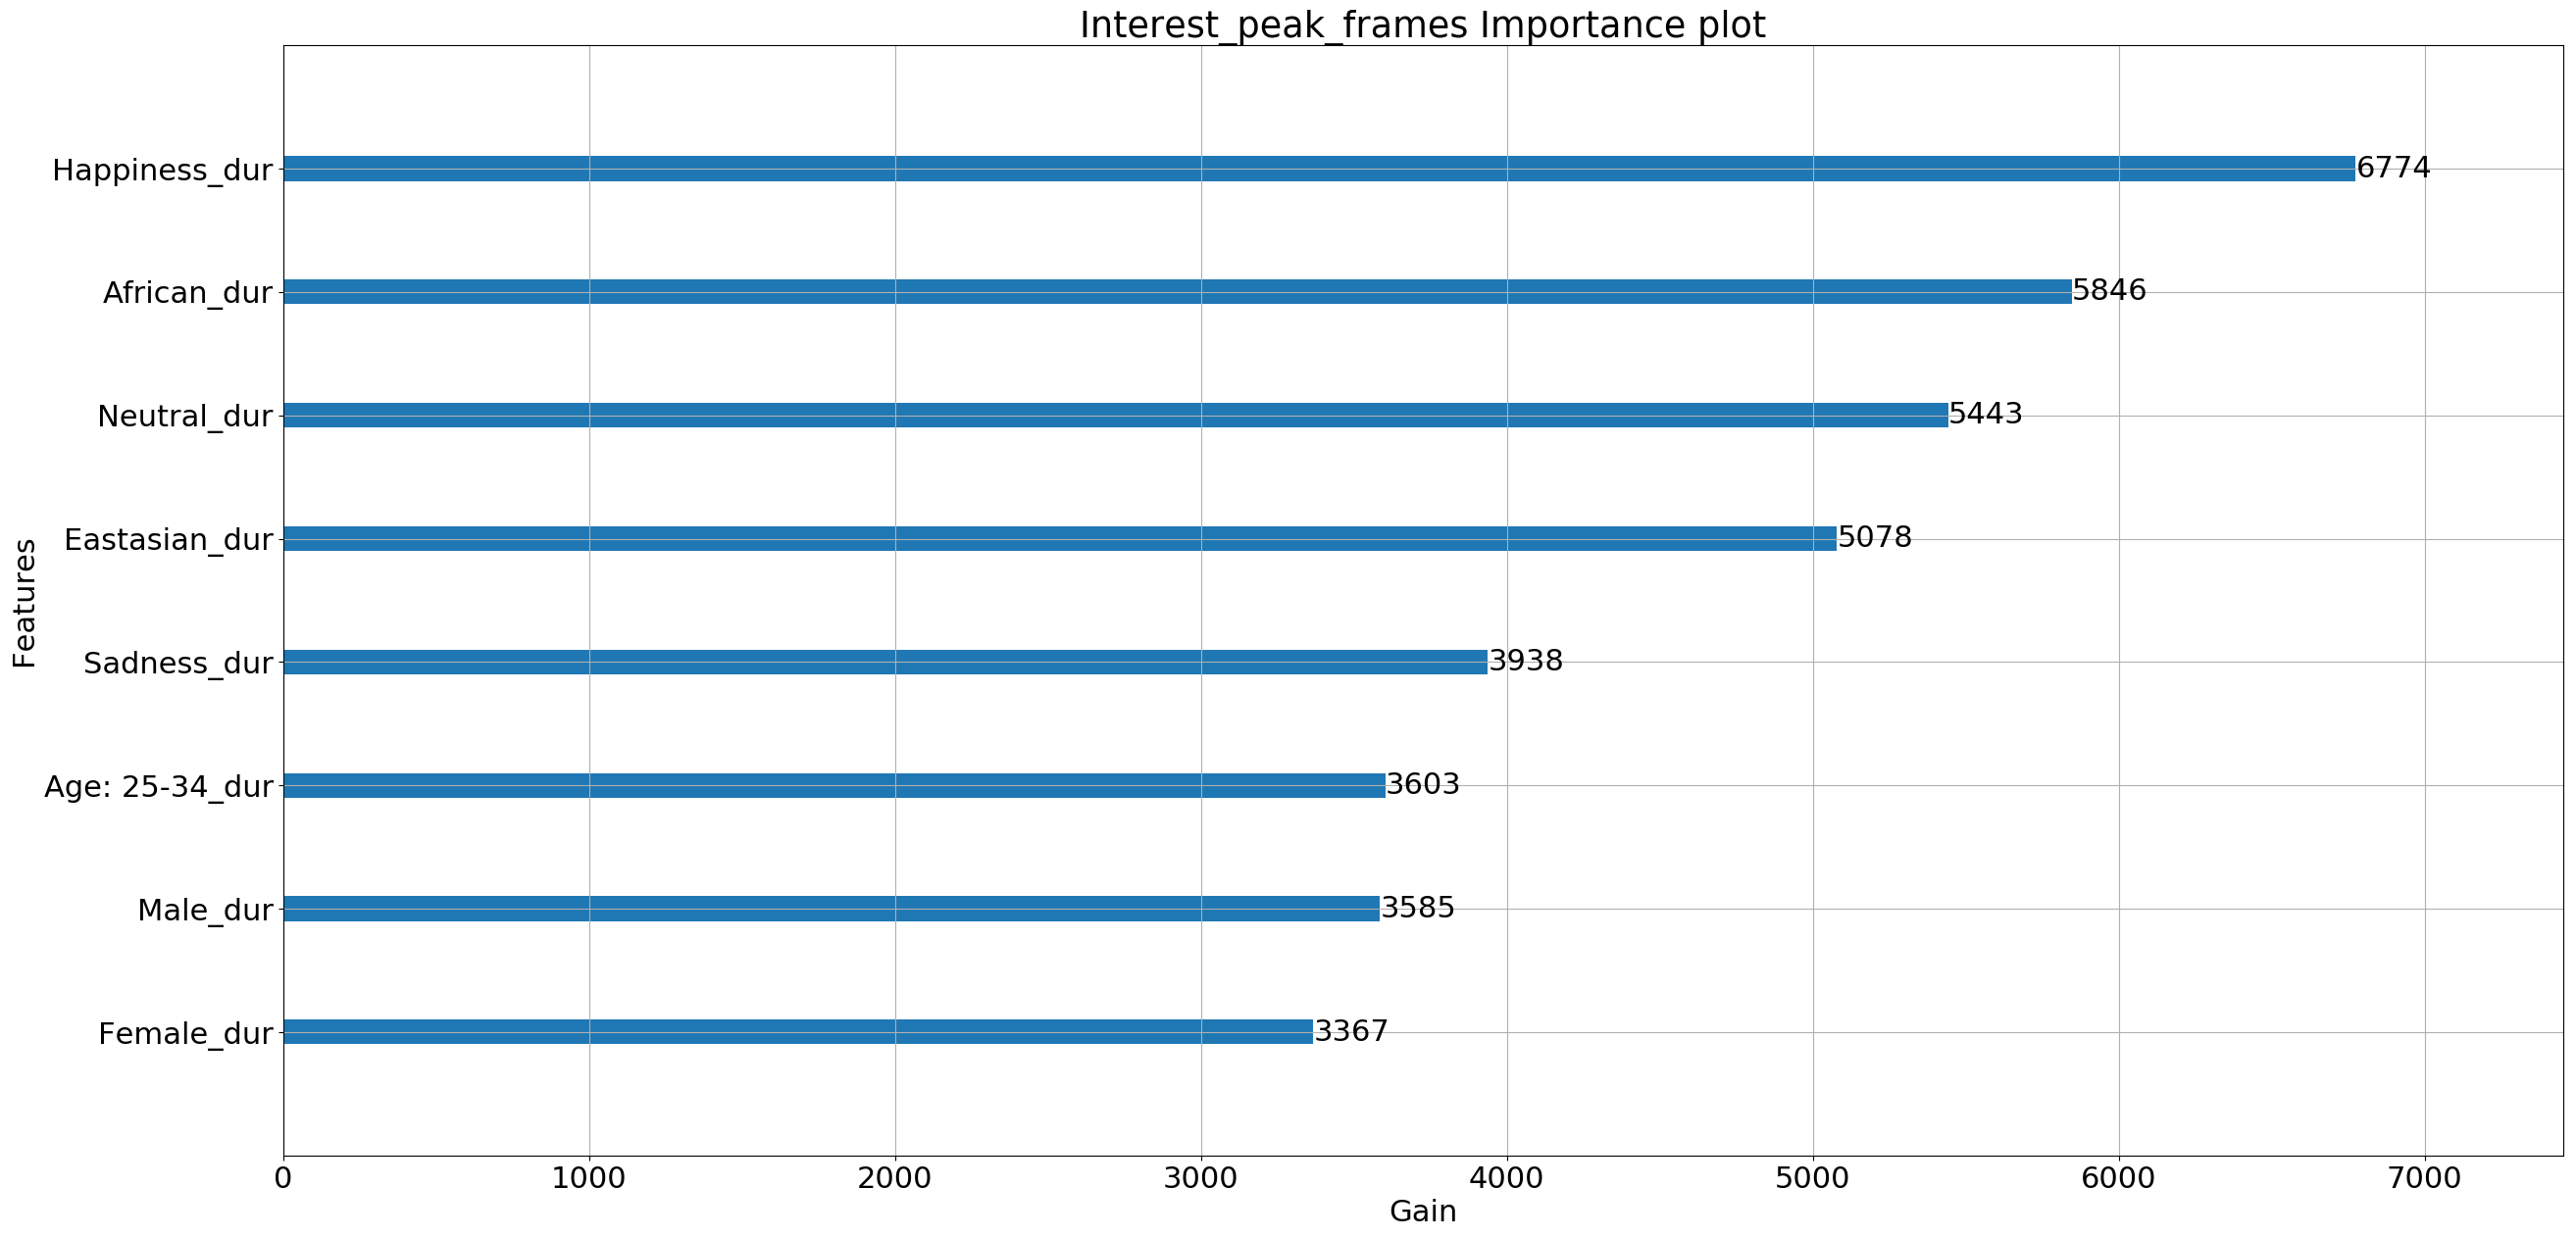

Enjoyment_vey_much
length_of_ad_15
Windows_last_ocr
microsoft_last_ocr
Windows_first_ocr
Dell_text_dur
microsoft_first_ocr
Laptop_last_ocr
Yoga_dur
Laptop_dur
Lenovo_text_dur
Asus_dur
microsoft_total_ocr
Laptop_total_ocr
Tablet_first_ocr
Age: 35-44_dur
Windows_total_ocr
Dell_dur
Hp_first_ocr
Dell_sub_brand_group_dur
Lenovo_group_dur
microsoft_dur
Neutral_dur
ASUS T102_dur
Age: 15-24_dur
Windows_dur
Happiness_dur
Sadness_dur
Hp_last_ocr
Eastasian_dur
Age: 25-34_dur
Tablet_total_ocr
Male_dur
Tablet_last_ocr
Hp_text_dur
Asus_text_dur
HP_group_dur
Tablet_dur
Laptop_first_ocr
Hp_text_first_ocr
Female_dur
Hp_total_ocr
African_dur
Surface_group_dur
Hp_text_total_ocr
Hp_dur
Hp_text_last_ocr
Macbook_group_dur
Apple_dur
Currys PCs world_text_dur


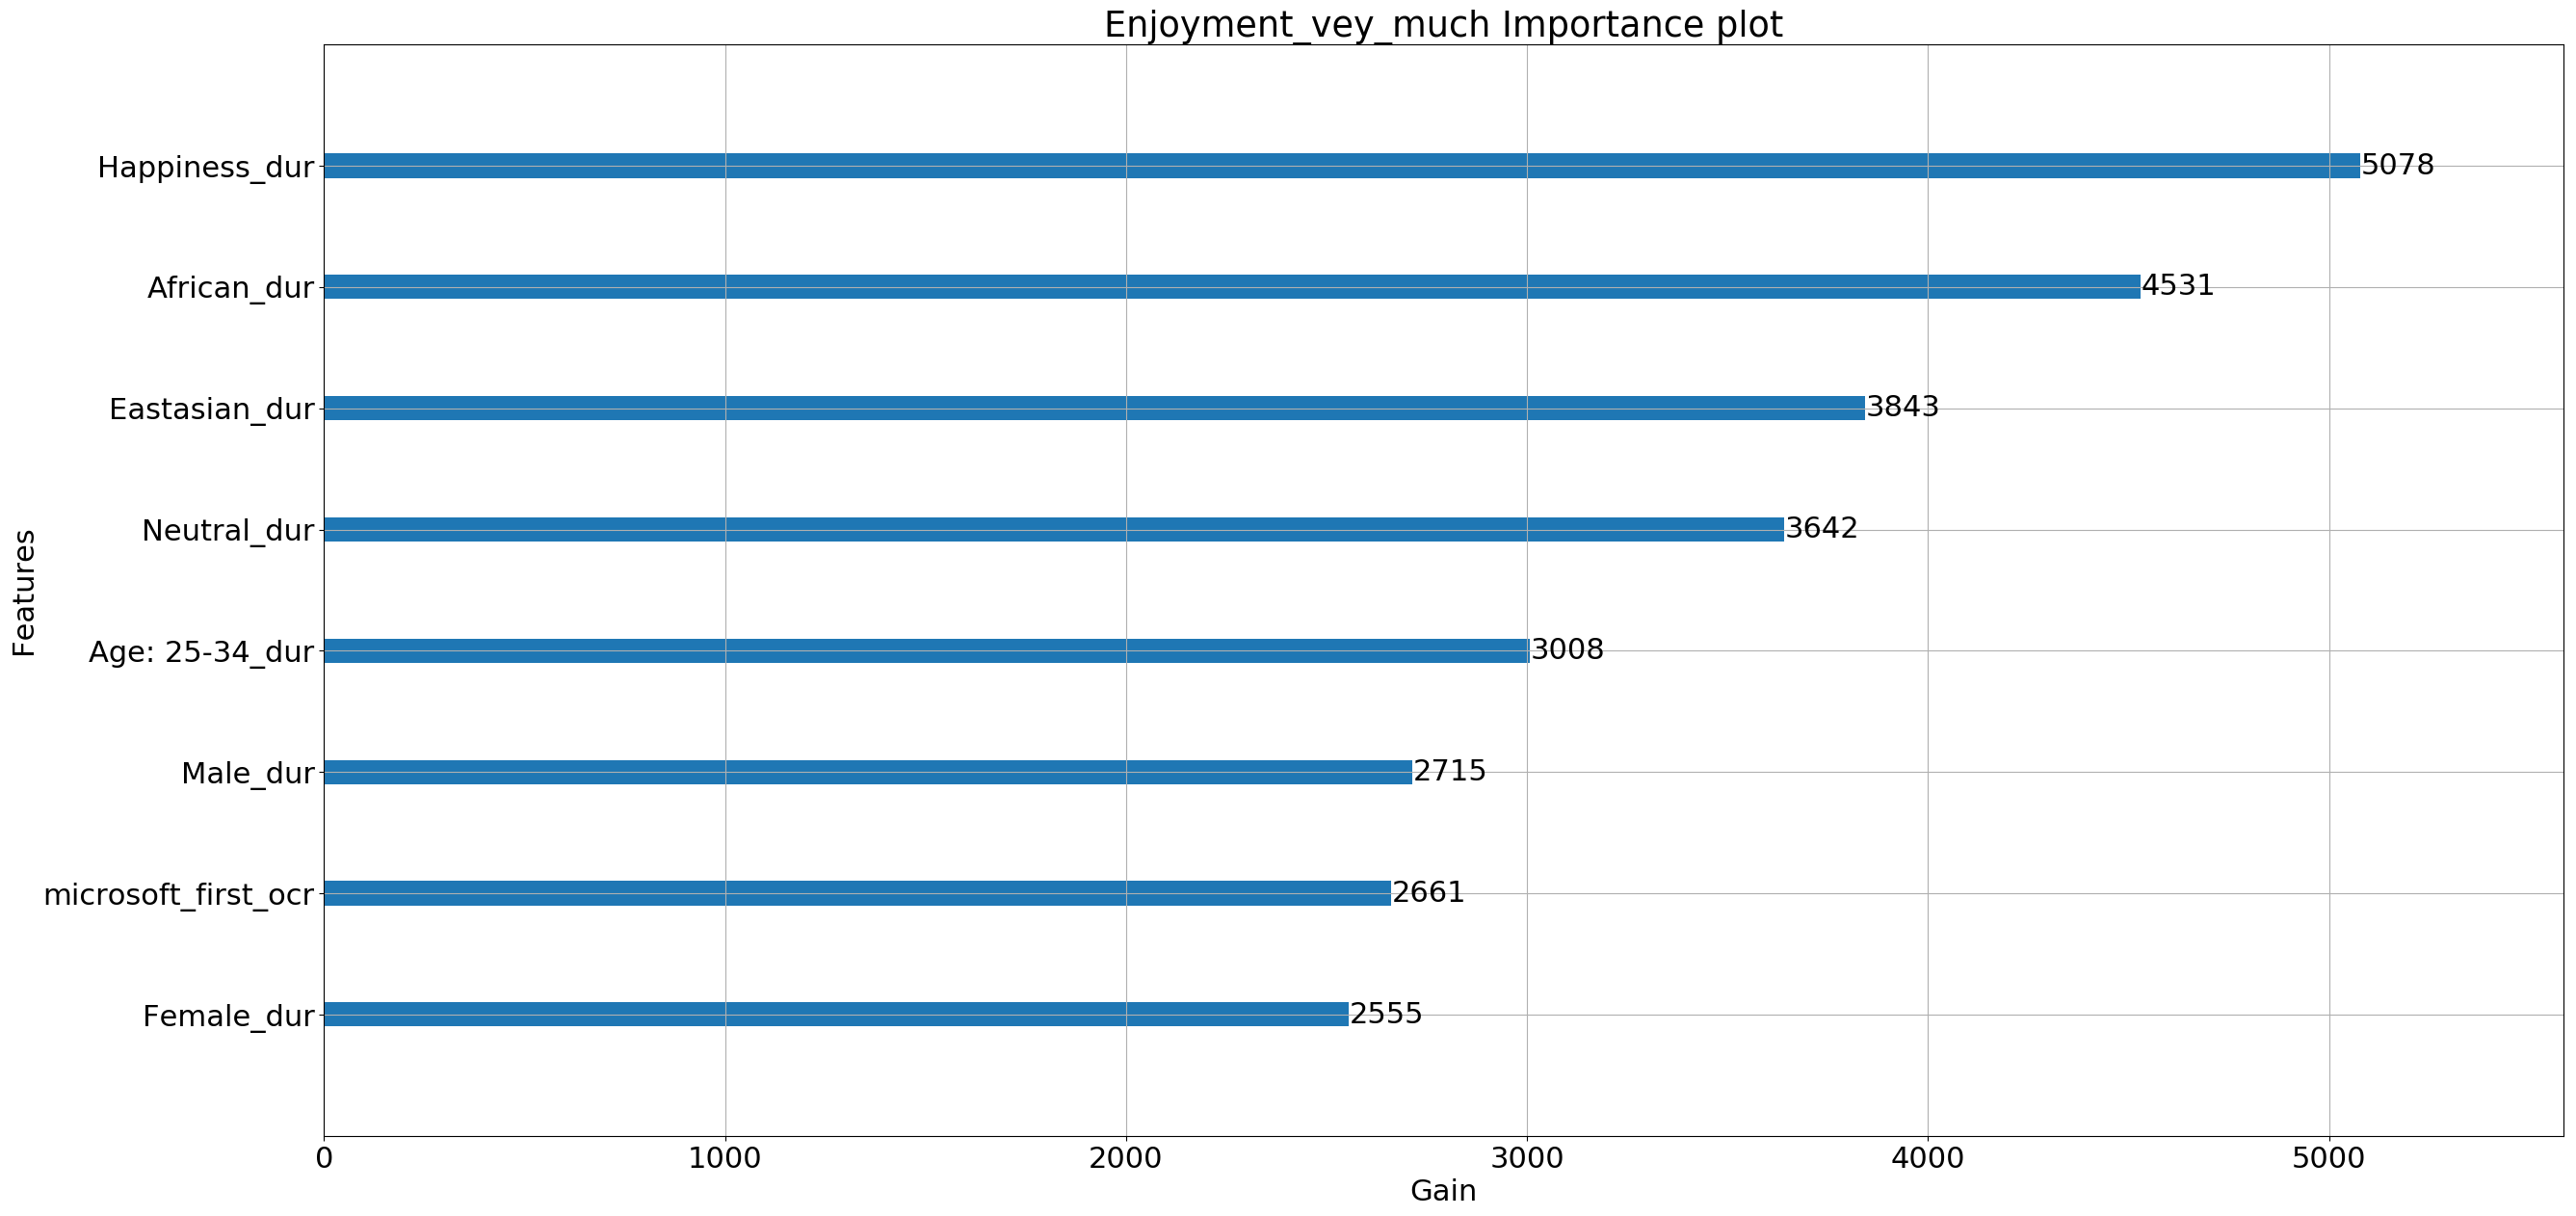

Aided_Branding_almost_anything
Laptop_first_ocr
Surface_group_dur
Hp_text_total_ocr
Age: 25-34_dur
microsoft_last_ocr
Windows_total_ocr
microsoft_dur
Windows_first_ocr
Hp_text_dur
Laptop_total_ocr
length_of_ad_15
Hp_text_last_ocr
Male_dur
Hp_text_first_ocr
Lenovo_text_dur
Laptop_dur
Windows_dur
Windows_last_ocr
Tablet_dur
Asus_text_dur
Hp_total_ocr
ASUS T102_dur
Tablet_first_ocr
Laptop_last_ocr
microsoft_total_ocr
Dell_dur
Lenovo_group_dur
Dell_sub_brand_group_dur
Hp_last_ocr
Happiness_dur
Age: 15-24_dur
Tablet_last_ocr
Neutral_dur
Dell_text_dur
Asus_dur
microsoft_first_ocr
Age: 35-44_dur
Sadness_dur
Hp_dur
Female_dur
Hp_first_ocr
Eastasian_dur
Tablet_total_ocr
African_dur
Yoga_dur
HP_group_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


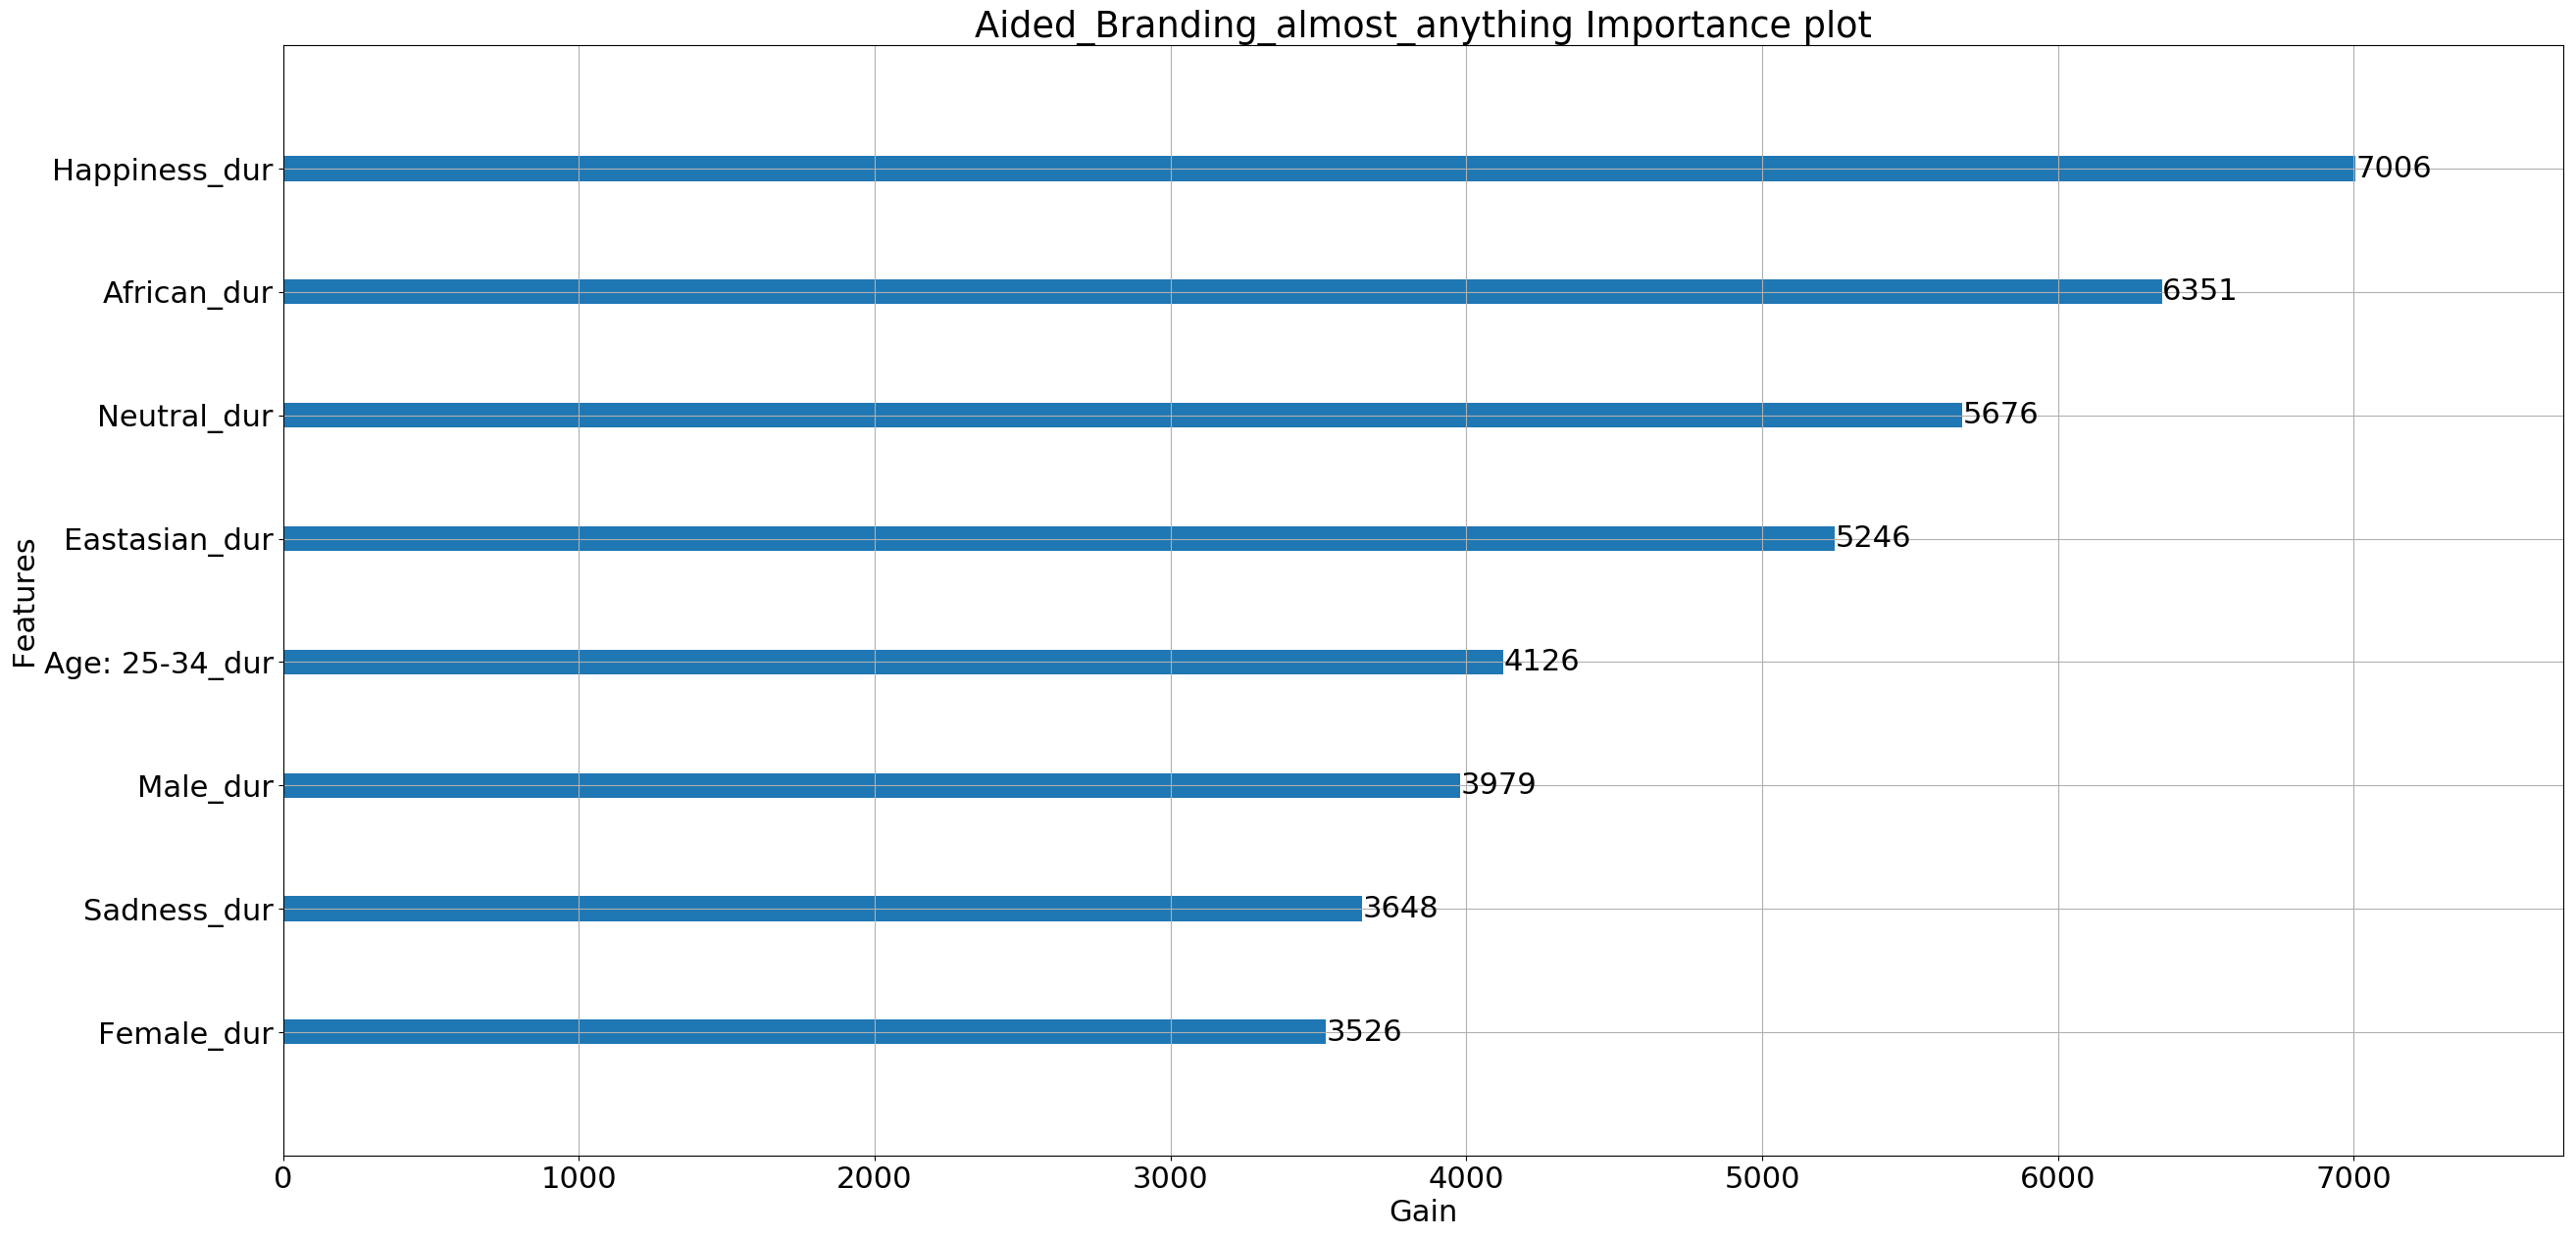

Brand_Cues_very_easily
Windows_last_ocr
Dell_text_dur
Laptop_total_ocr
Asus_text_dur
ASUS T102_dur
Laptop_first_ocr
microsoft_last_ocr
Laptop_last_ocr
Asus_dur
Hp_text_first_ocr
Tablet_first_ocr
Hp_text_last_ocr
Yoga_dur
Lenovo_text_dur
Dell_dur
microsoft_first_ocr
Hp_text_dur
Male_dur
Windows_first_ocr
Lenovo_group_dur
Female_dur
Hp_text_total_ocr
Age: 15-24_dur
Dell_sub_brand_group_dur
microsoft_dur
Tablet_total_ocr
Neutral_dur
Happiness_dur
Age: 25-34_dur
microsoft_total_ocr
length_of_ad_15
Tablet_dur
Hp_total_ocr
Hp_dur
Hp_first_ocr
HP_group_dur
African_dur
Age: 35-44_dur
Hp_last_ocr
Laptop_dur
Sadness_dur
Tablet_last_ocr
Windows_dur
Eastasian_dur
Surface_group_dur
Windows_total_ocr
Apple_dur
Currys PCs world_text_dur
Macbook_group_dur


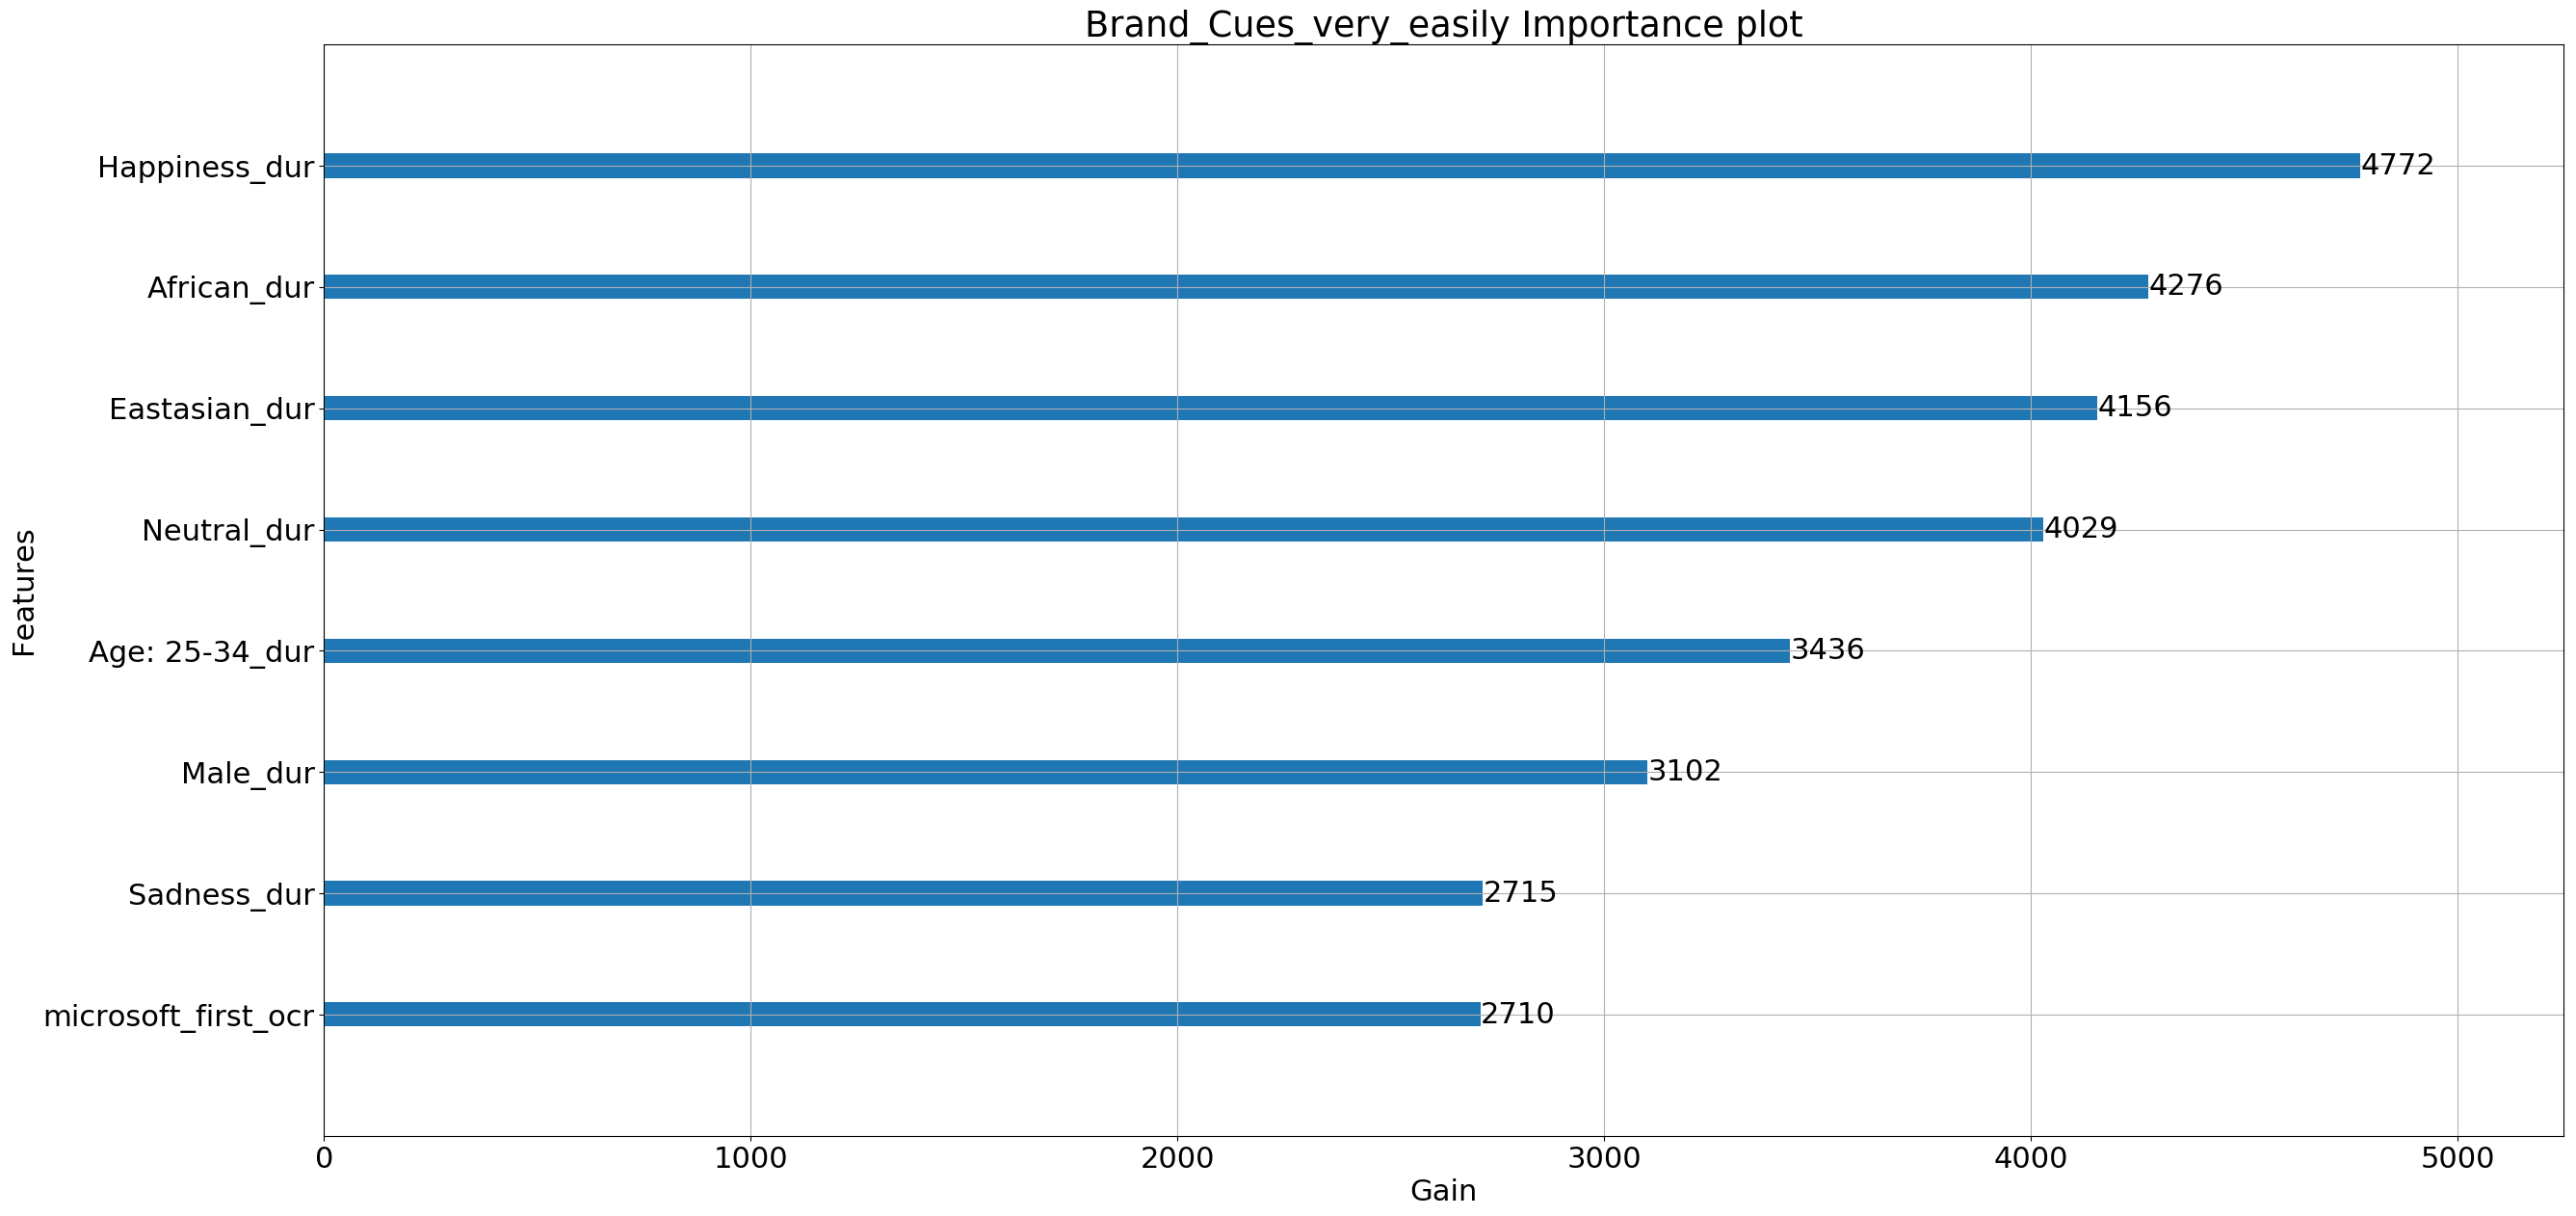

Brand_Appeal_more_appealing
Windows_last_ocr
length_of_ad_15
microsoft_last_ocr
Yoga_dur
microsoft_first_ocr
Lenovo_text_dur
ASUS T102_dur
Laptop_last_ocr
Windows_first_ocr
Asus_text_dur
Laptop_total_ocr
Windows_total_ocr
Asus_dur
Lenovo_group_dur
microsoft_total_ocr
Hp_text_last_ocr
Hp_text_first_ocr
Laptop_first_ocr
Age: 15-24_dur
Dell_dur
Age: 35-44_dur
Neutral_dur
Hp_dur
Tablet_dur
Dell_sub_brand_group_dur
Dell_text_dur
Hp_total_ocr
Laptop_dur
Tablet_first_ocr
Hp_last_ocr
microsoft_dur
Hp_text_dur
Tablet_total_ocr
Happiness_dur
Windows_dur
African_dur
Sadness_dur
Hp_text_total_ocr
Female_dur
Tablet_last_ocr
Hp_first_ocr
Age: 25-34_dur
Male_dur
Eastasian_dur
Surface_group_dur
HP_group_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


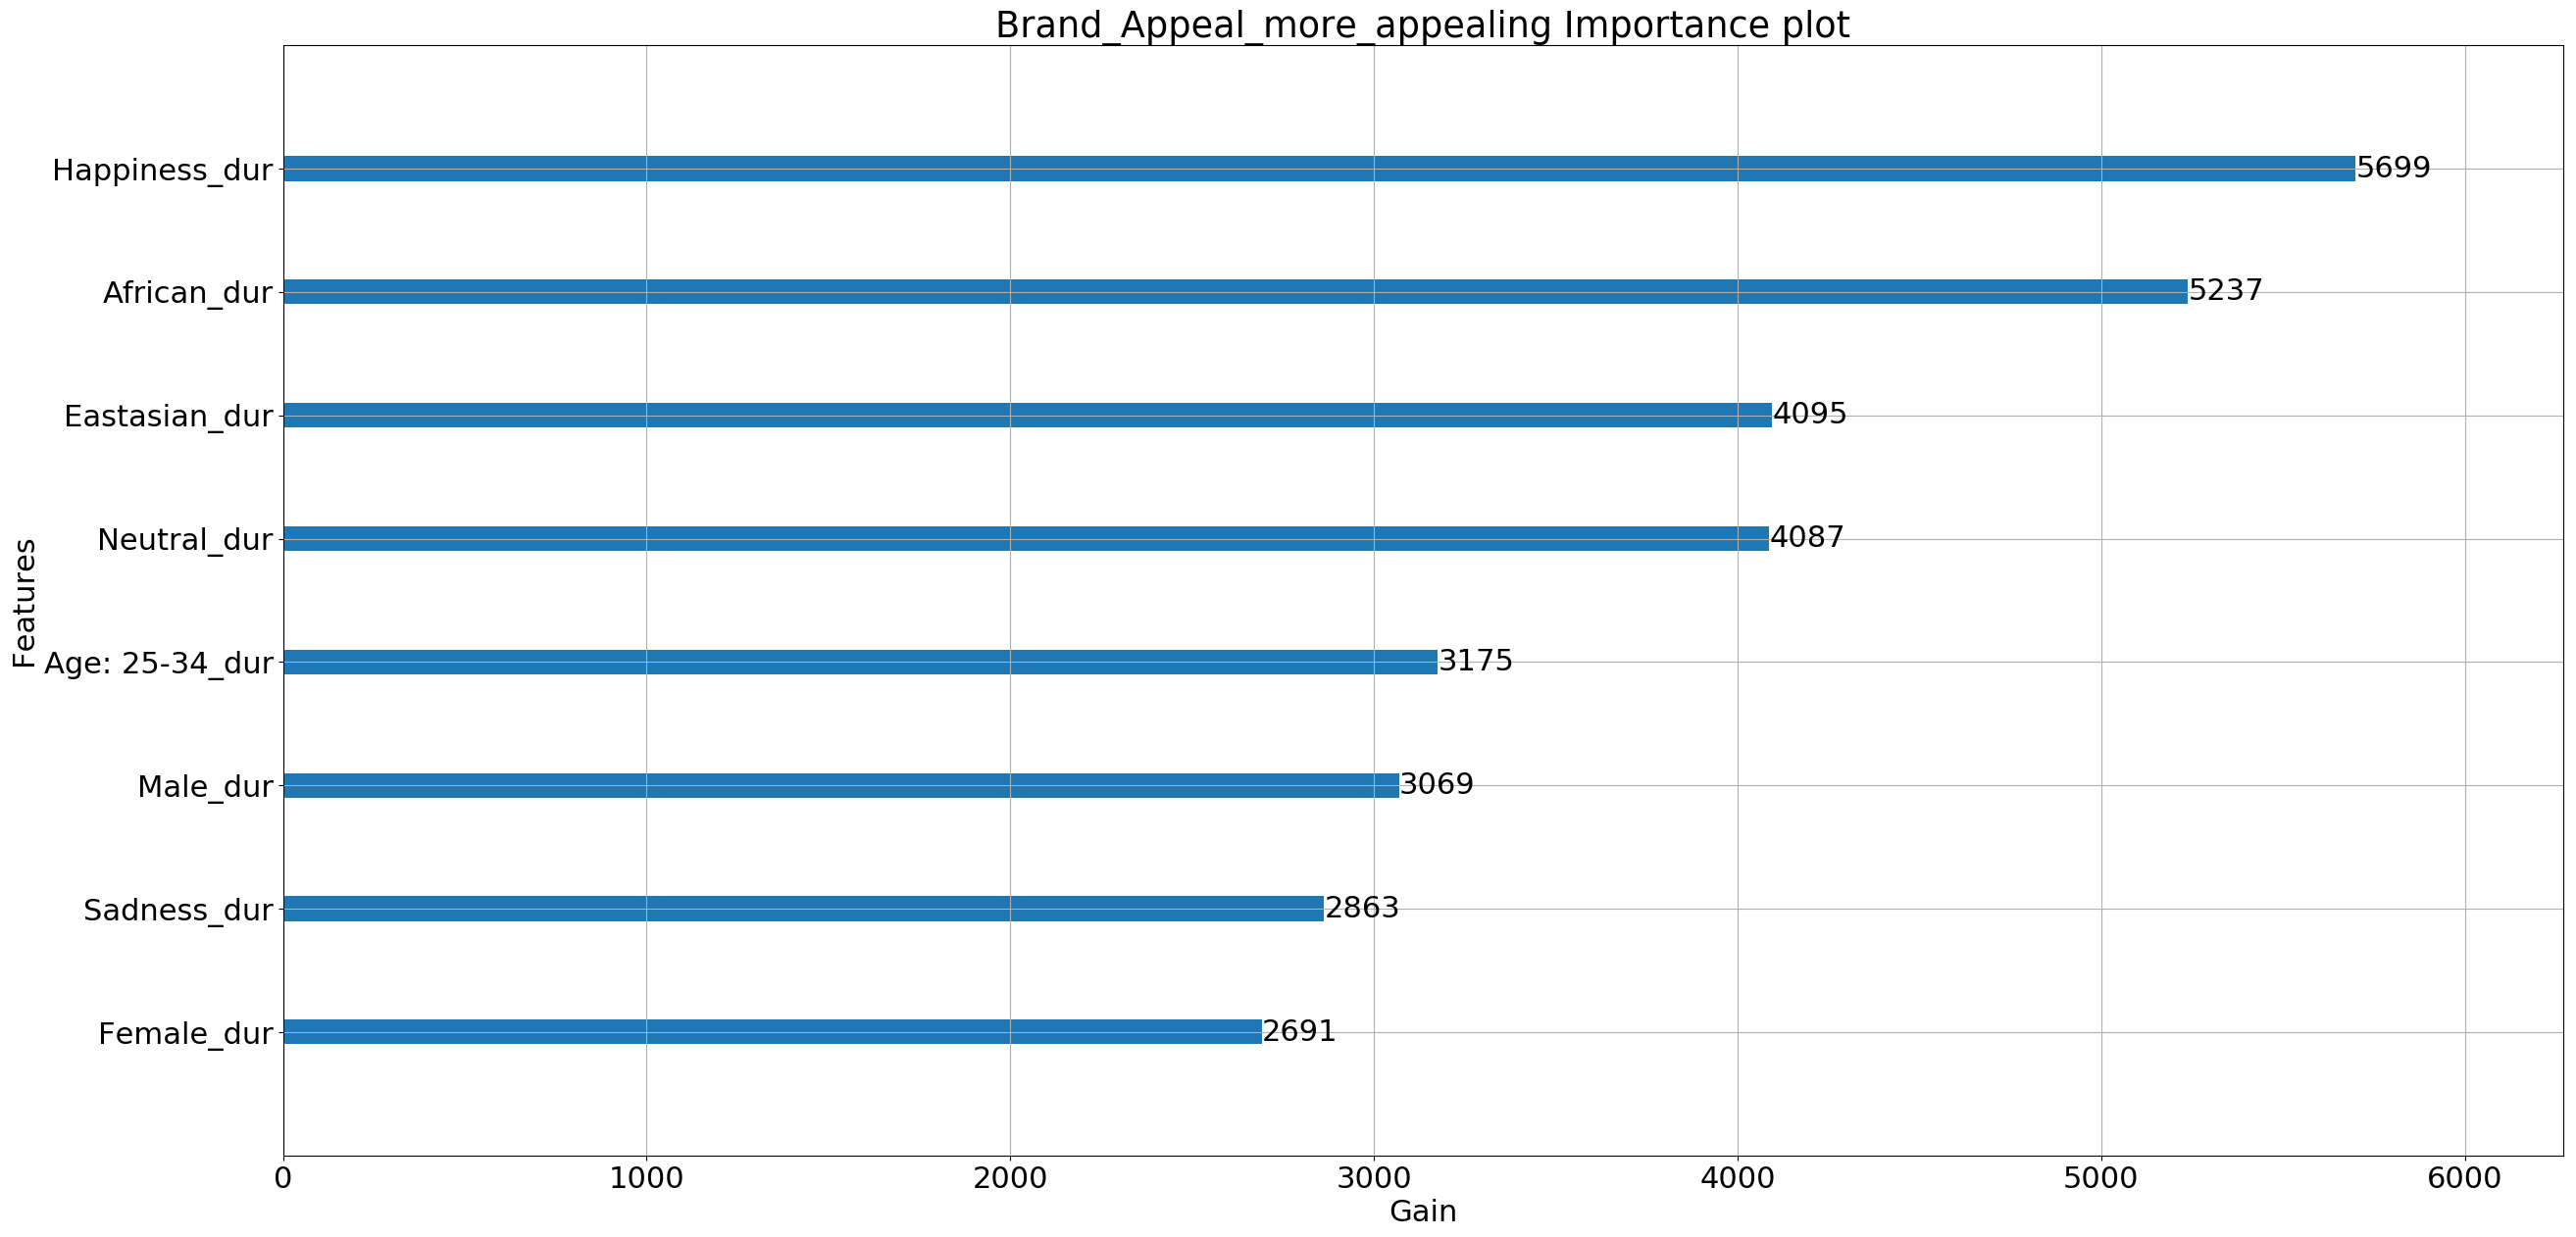

Understanding_very_easily
microsoft_last_ocr
Male_dur
Tablet_last_ocr
Tablet_first_ocr
Hp_text_total_ocr
microsoft_total_ocr
Female_dur
Lenovo_text_dur
Hp_first_ocr
Hp_text_dur
Windows_last_ocr
Tablet_total_ocr
Hp_text_last_ocr
microsoft_first_ocr
Windows_total_ocr
Neutral_dur
ASUS T102_dur
Asus_text_dur
Dell_text_dur
Asus_dur
Windows_first_ocr
Age: 35-44_dur
length_of_ad_15
Hp_total_ocr
Tablet_dur
Yoga_dur
Hp_text_first_ocr
Dell_dur
Laptop_first_ocr
microsoft_dur
Laptop_total_ocr
Laptop_dur
Hp_last_ocr
Hp_dur
Age: 15-24_dur
Laptop_last_ocr
Sadness_dur
Happiness_dur
Age: 25-34_dur
Lenovo_group_dur
Windows_dur
Dell_sub_brand_group_dur
Eastasian_dur
HP_group_dur
African_dur
Surface_group_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


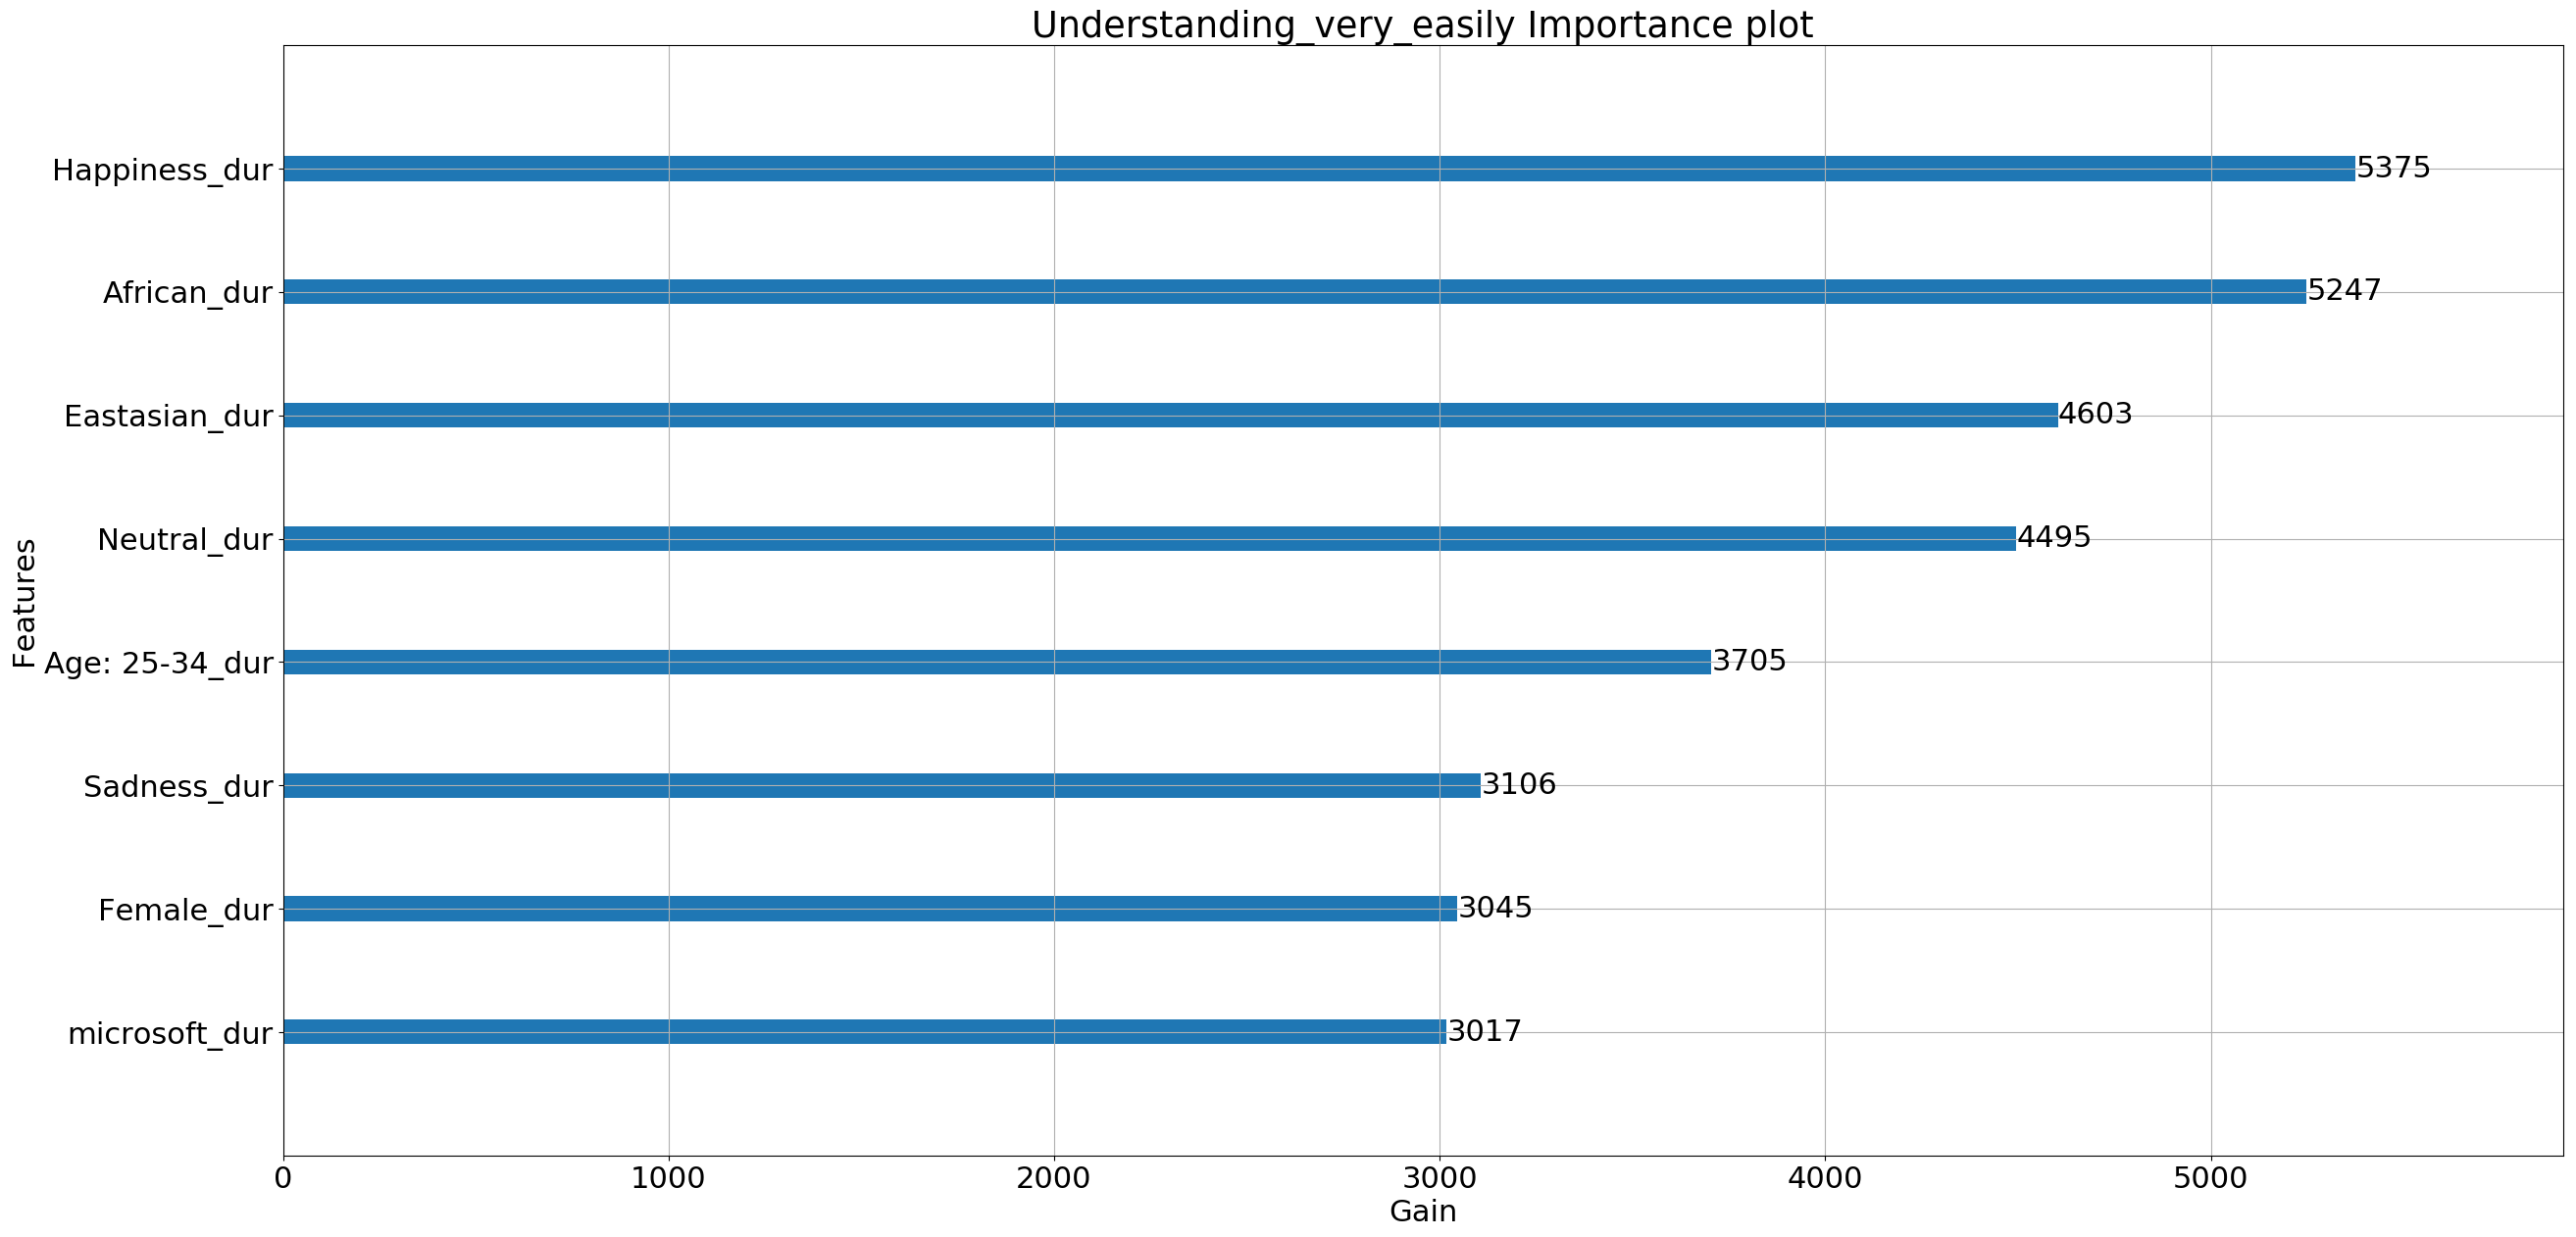

Relevance_Information_very_relevant
microsoft_last_ocr
Windows_last_ocr
ASUS T102_dur
Asus_dur
Asus_text_dur
length_of_ad_15
Laptop_first_ocr
microsoft_first_ocr
Hp_text_total_ocr
Age: 35-44_dur
Tablet_total_ocr
Yoga_dur
Laptop_total_ocr
Hp_text_last_ocr
Hp_text_first_ocr
Hp_text_dur
Windows_first_ocr
Surface_group_dur
Laptop_last_ocr
microsoft_dur
Laptop_dur
Windows_total_ocr
Age: 15-24_dur
Happiness_dur
Tablet_last_ocr
Neutral_dur
Lenovo_group_dur
Windows_dur
Lenovo_text_dur
Age: 25-34_dur
microsoft_total_ocr
Tablet_first_ocr
Hp_first_ocr
Sadness_dur
Dell_dur
Tablet_dur
Hp_total_ocr
HP_group_dur
Eastasian_dur
Male_dur
Hp_last_ocr
Hp_dur
Dell_text_dur
African_dur
Female_dur
Dell_sub_brand_group_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


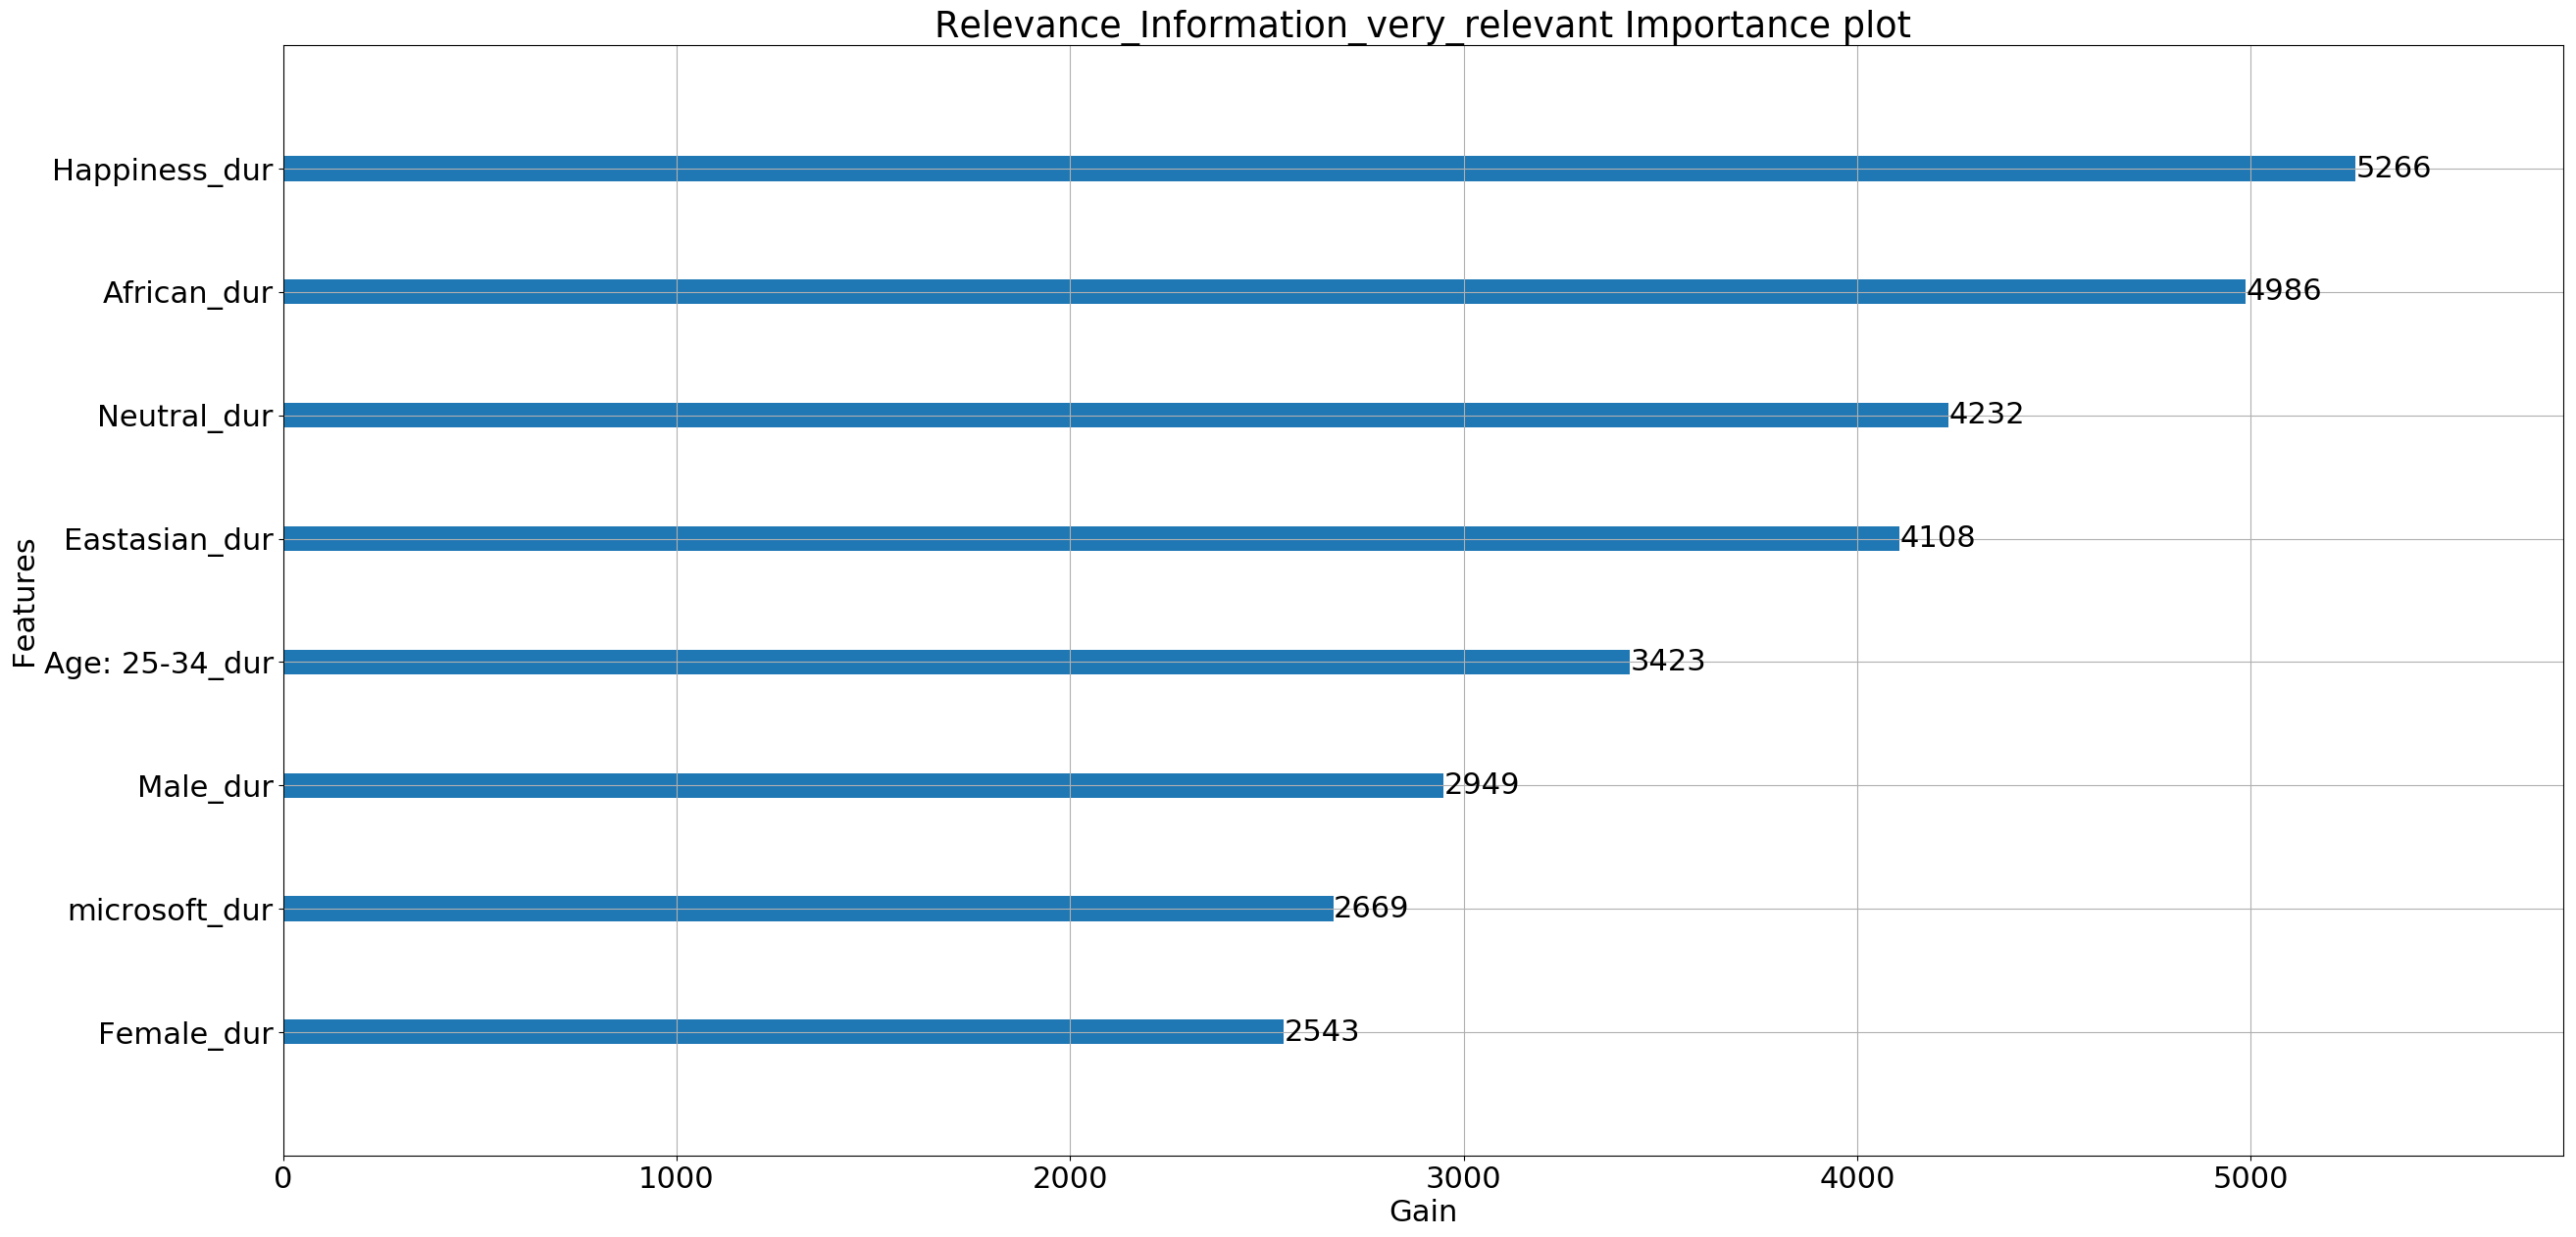

Credibility_Information_agree_strongly
Tablet_total_ocr
microsoft_last_ocr
Laptop_last_ocr
Tablet_first_ocr
Tablet_dur
Yoga_dur
Laptop_total_ocr
Hp_text_dur
Lenovo_text_dur
microsoft_dur
Asus_dur
Hp_text_total_ocr
microsoft_first_ocr
Lenovo_group_dur
Neutral_dur
Windows_first_ocr
ASUS T102_dur
Dell_sub_brand_group_dur
Laptop_first_ocr
Laptop_dur
Hp_text_first_ocr
Tablet_last_ocr
Hp_text_last_ocr
Dell_dur
Hp_total_ocr
microsoft_total_ocr
Windows_dur
Hp_first_ocr
Windows_total_ocr
Happiness_dur
Age: 25-34_dur
Windows_last_ocr
Dell_text_dur
Hp_dur
Male_dur
Sadness_dur
Female_dur
Surface_group_dur
Age: 15-24_dur
Age: 35-44_dur
Asus_text_dur
Hp_last_ocr
length_of_ad_15
Eastasian_dur
African_dur
HP_group_dur
Macbook_group_dur
Apple_dur
Currys PCs world_text_dur


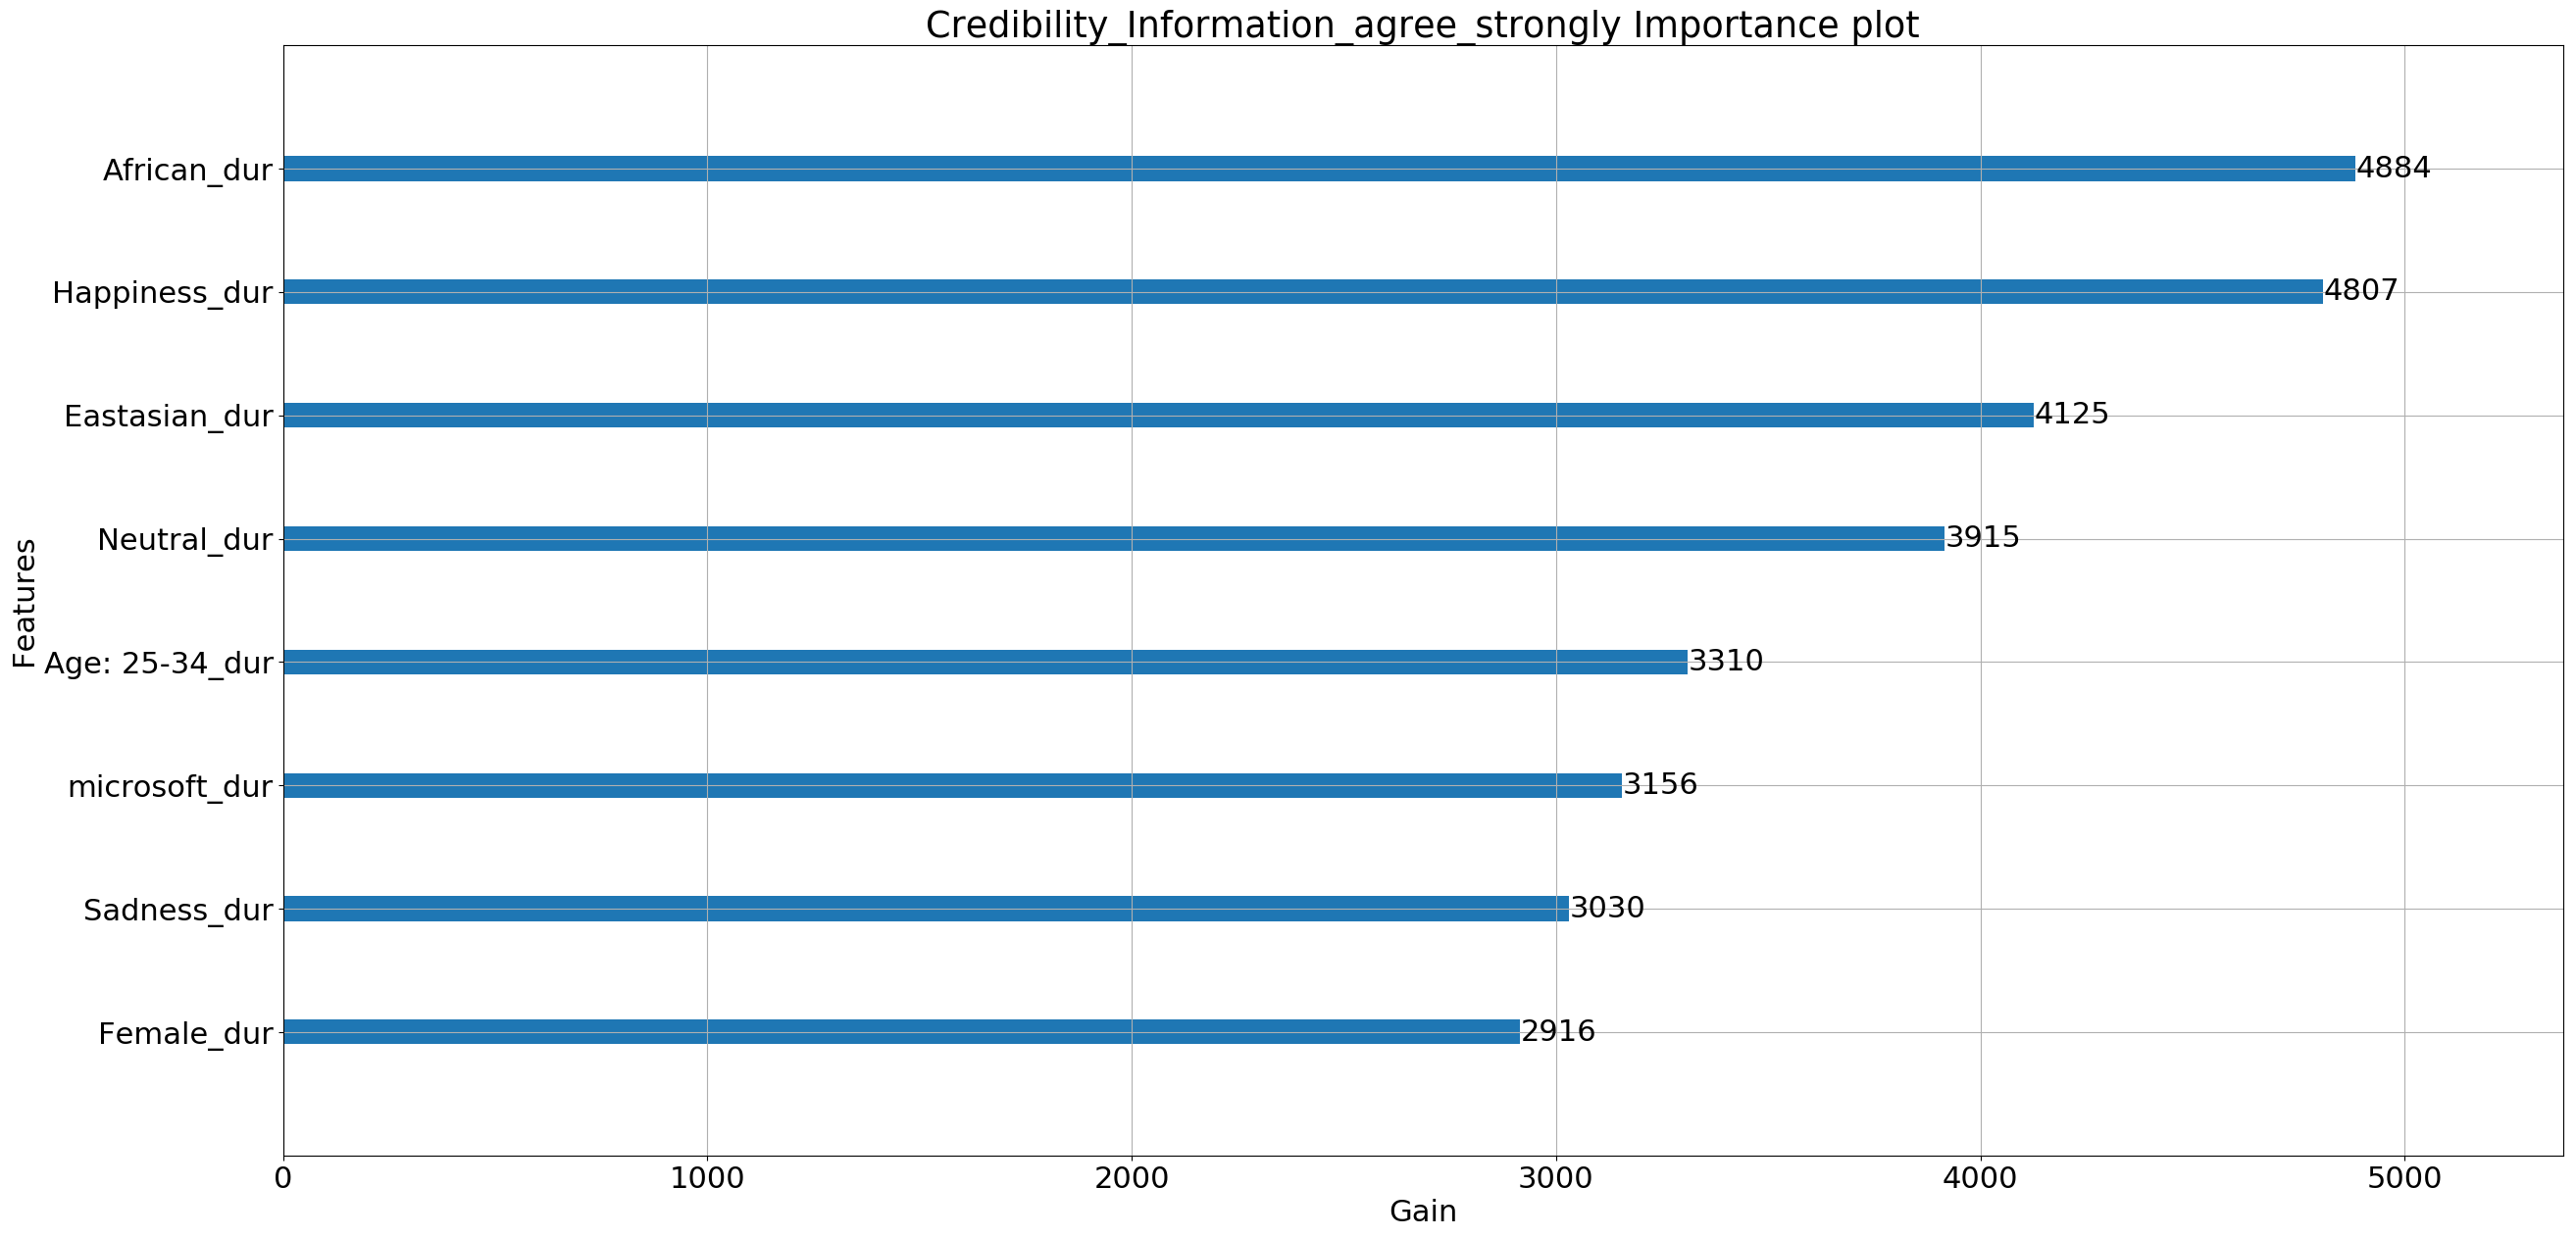

New_Information_alot
length_of_ad_15
microsoft_last_ocr
Lenovo_text_dur
Laptop_last_ocr
Yoga_dur
Windows_last_ocr
Dell_text_dur
Tablet_total_ocr
Laptop_total_ocr
Lenovo_group_dur
Windows_first_ocr
microsoft_first_ocr
Tablet_dur
Laptop_first_ocr
ASUS T102_dur
Age: 35-44_dur
Laptop_dur
Age: 25-34_dur
microsoft_total_ocr
Happiness_dur
Asus_text_dur
Asus_dur
Dell_sub_brand_group_dur
Hp_text_total_ocr
Tablet_first_ocr
Hp_last_ocr
Windows_total_ocr
Tablet_last_ocr
Age: 15-24_dur
Hp_total_ocr
Dell_dur
Hp_text_dur
Hp_dur
Sadness_dur
Hp_first_ocr
Hp_text_first_ocr
microsoft_dur
Windows_dur
Hp_text_last_ocr
Neutral_dur
Surface_group_dur
Male_dur
HP_group_dur
African_dur
Female_dur
Eastasian_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


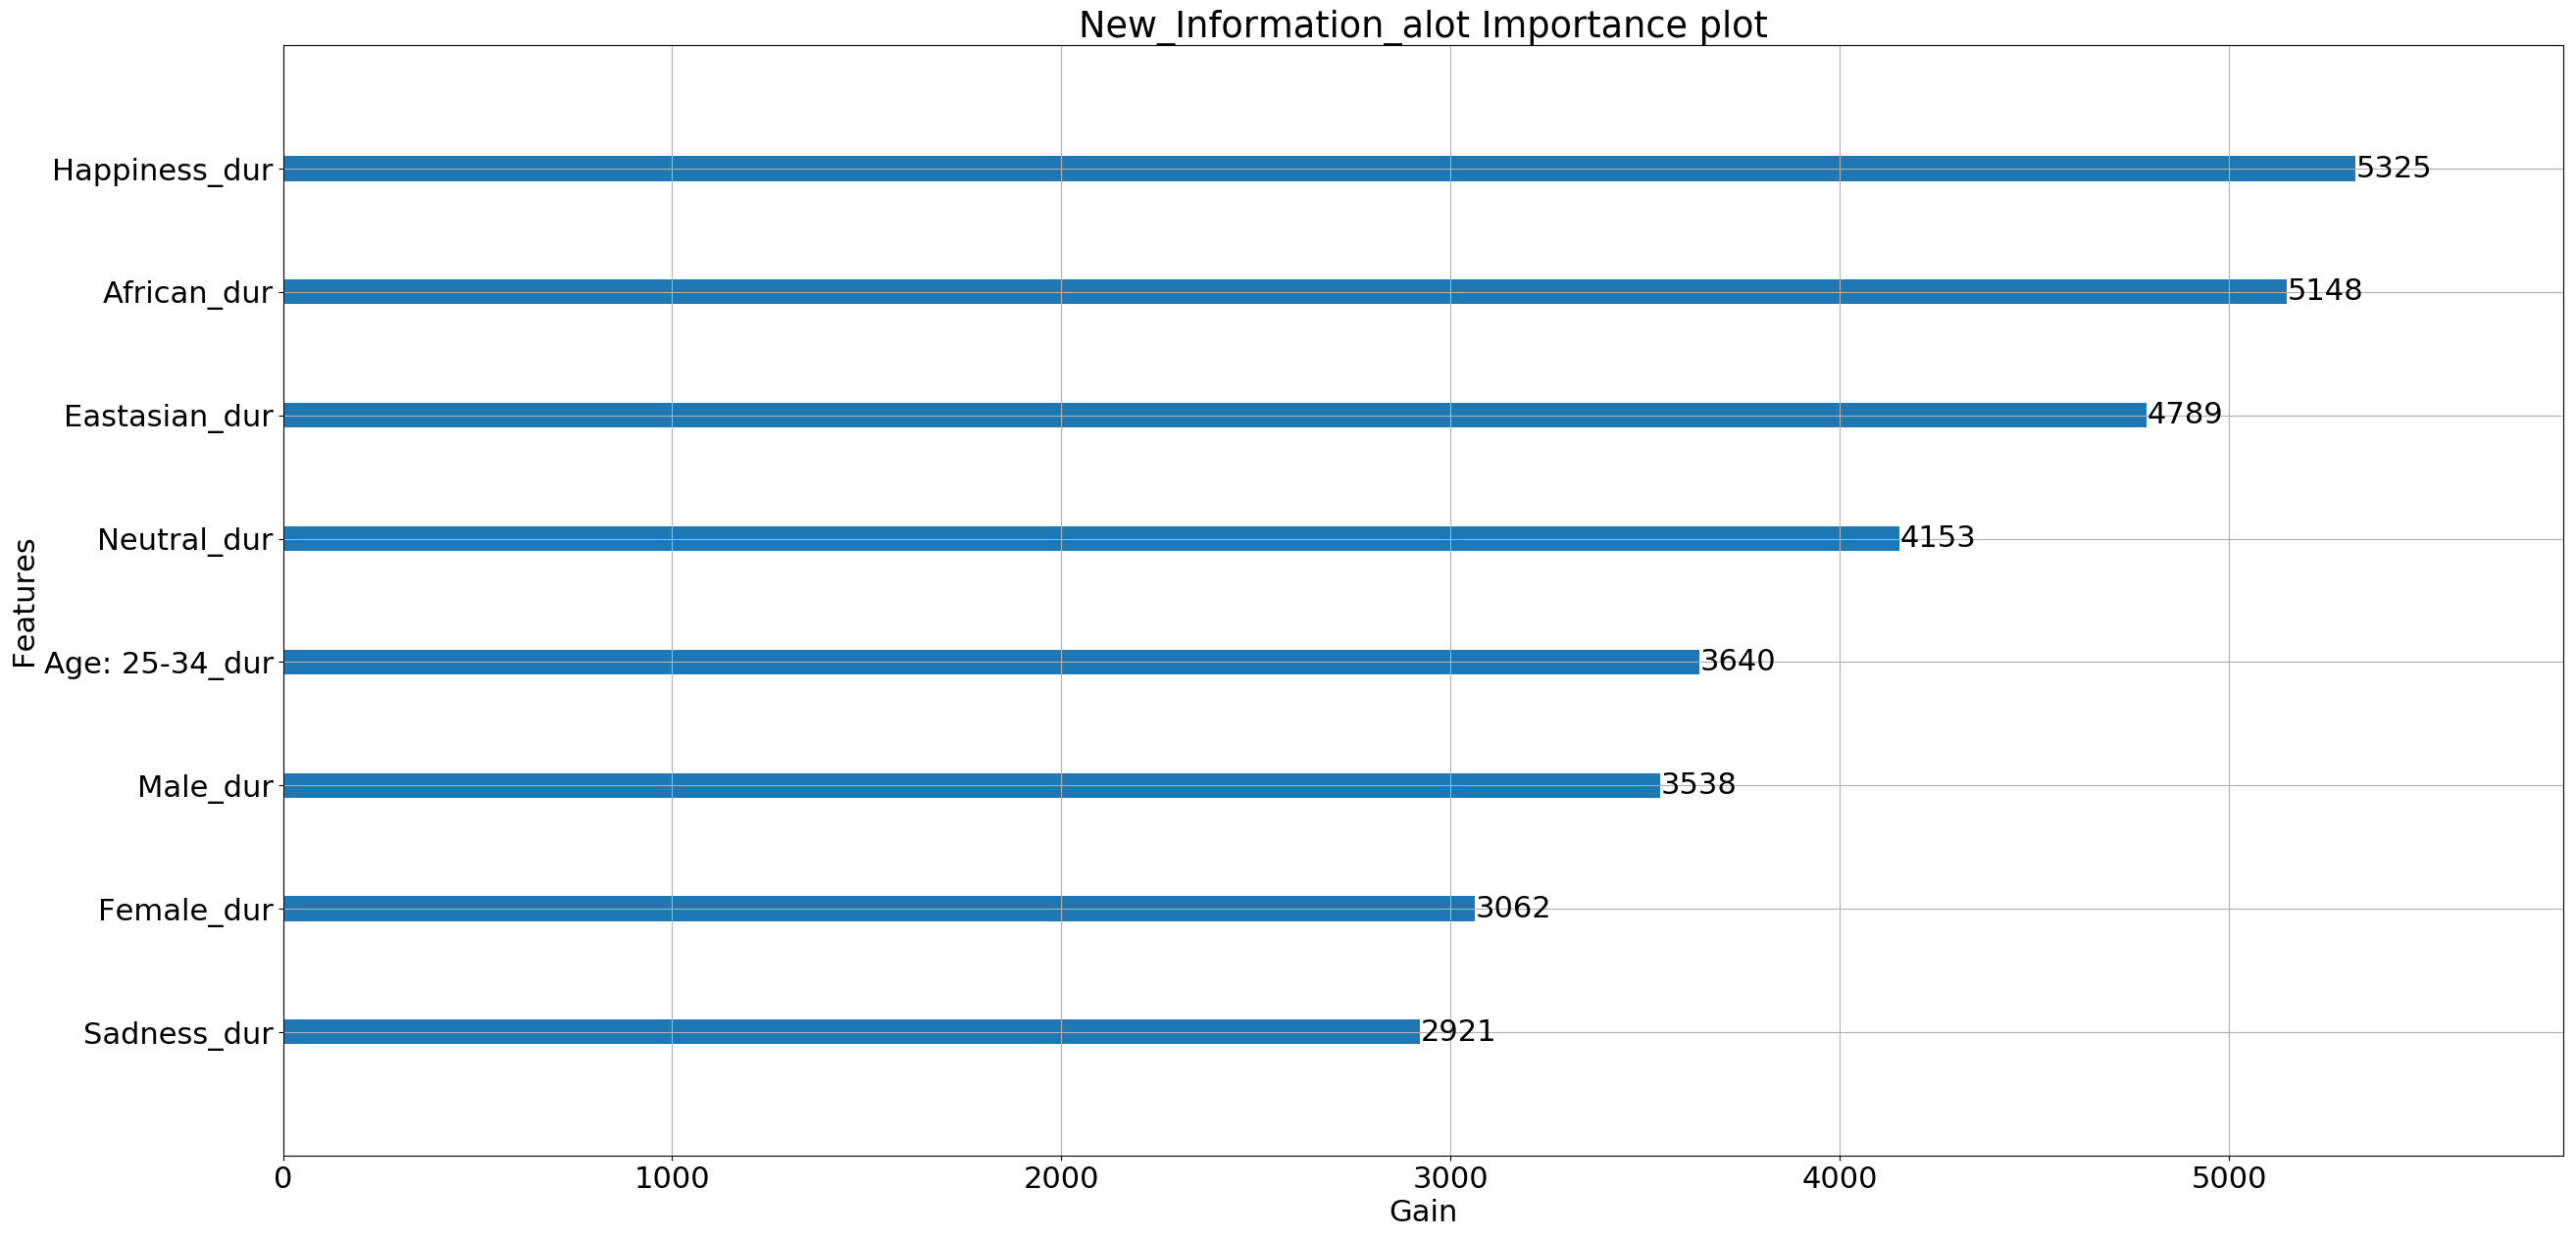

Brand_Difference_strongly
Dell_text_dur
microsoft_last_ocr
Laptop_last_ocr
microsoft_first_ocr
Age: 25-34_dur
Windows_last_ocr
Tablet_first_ocr
Lenovo_text_dur
Dell_dur
Yoga_dur
Hp_text_dur
Tablet_last_ocr
Asus_text_dur
Windows_total_ocr
Age: 15-24_dur
Tablet_dur
Tablet_total_ocr
Laptop_dur
Laptop_total_ocr
Lenovo_group_dur
Neutral_dur
Surface_group_dur
microsoft_total_ocr
African_dur
ASUS T102_dur
Laptop_first_ocr
Sadness_dur
Dell_sub_brand_group_dur
microsoft_dur
Happiness_dur
length_of_ad_15
Windows_first_ocr
Hp_first_ocr
HP_group_dur
Hp_text_last_ocr
Hp_total_ocr
Asus_dur
Hp_text_total_ocr
Eastasian_dur
Hp_dur
Hp_last_ocr
Female_dur
Male_dur
Hp_text_first_ocr
Age: 35-44_dur
Windows_dur
Macbook_group_dur
Currys PCs world_text_dur
Apple_dur


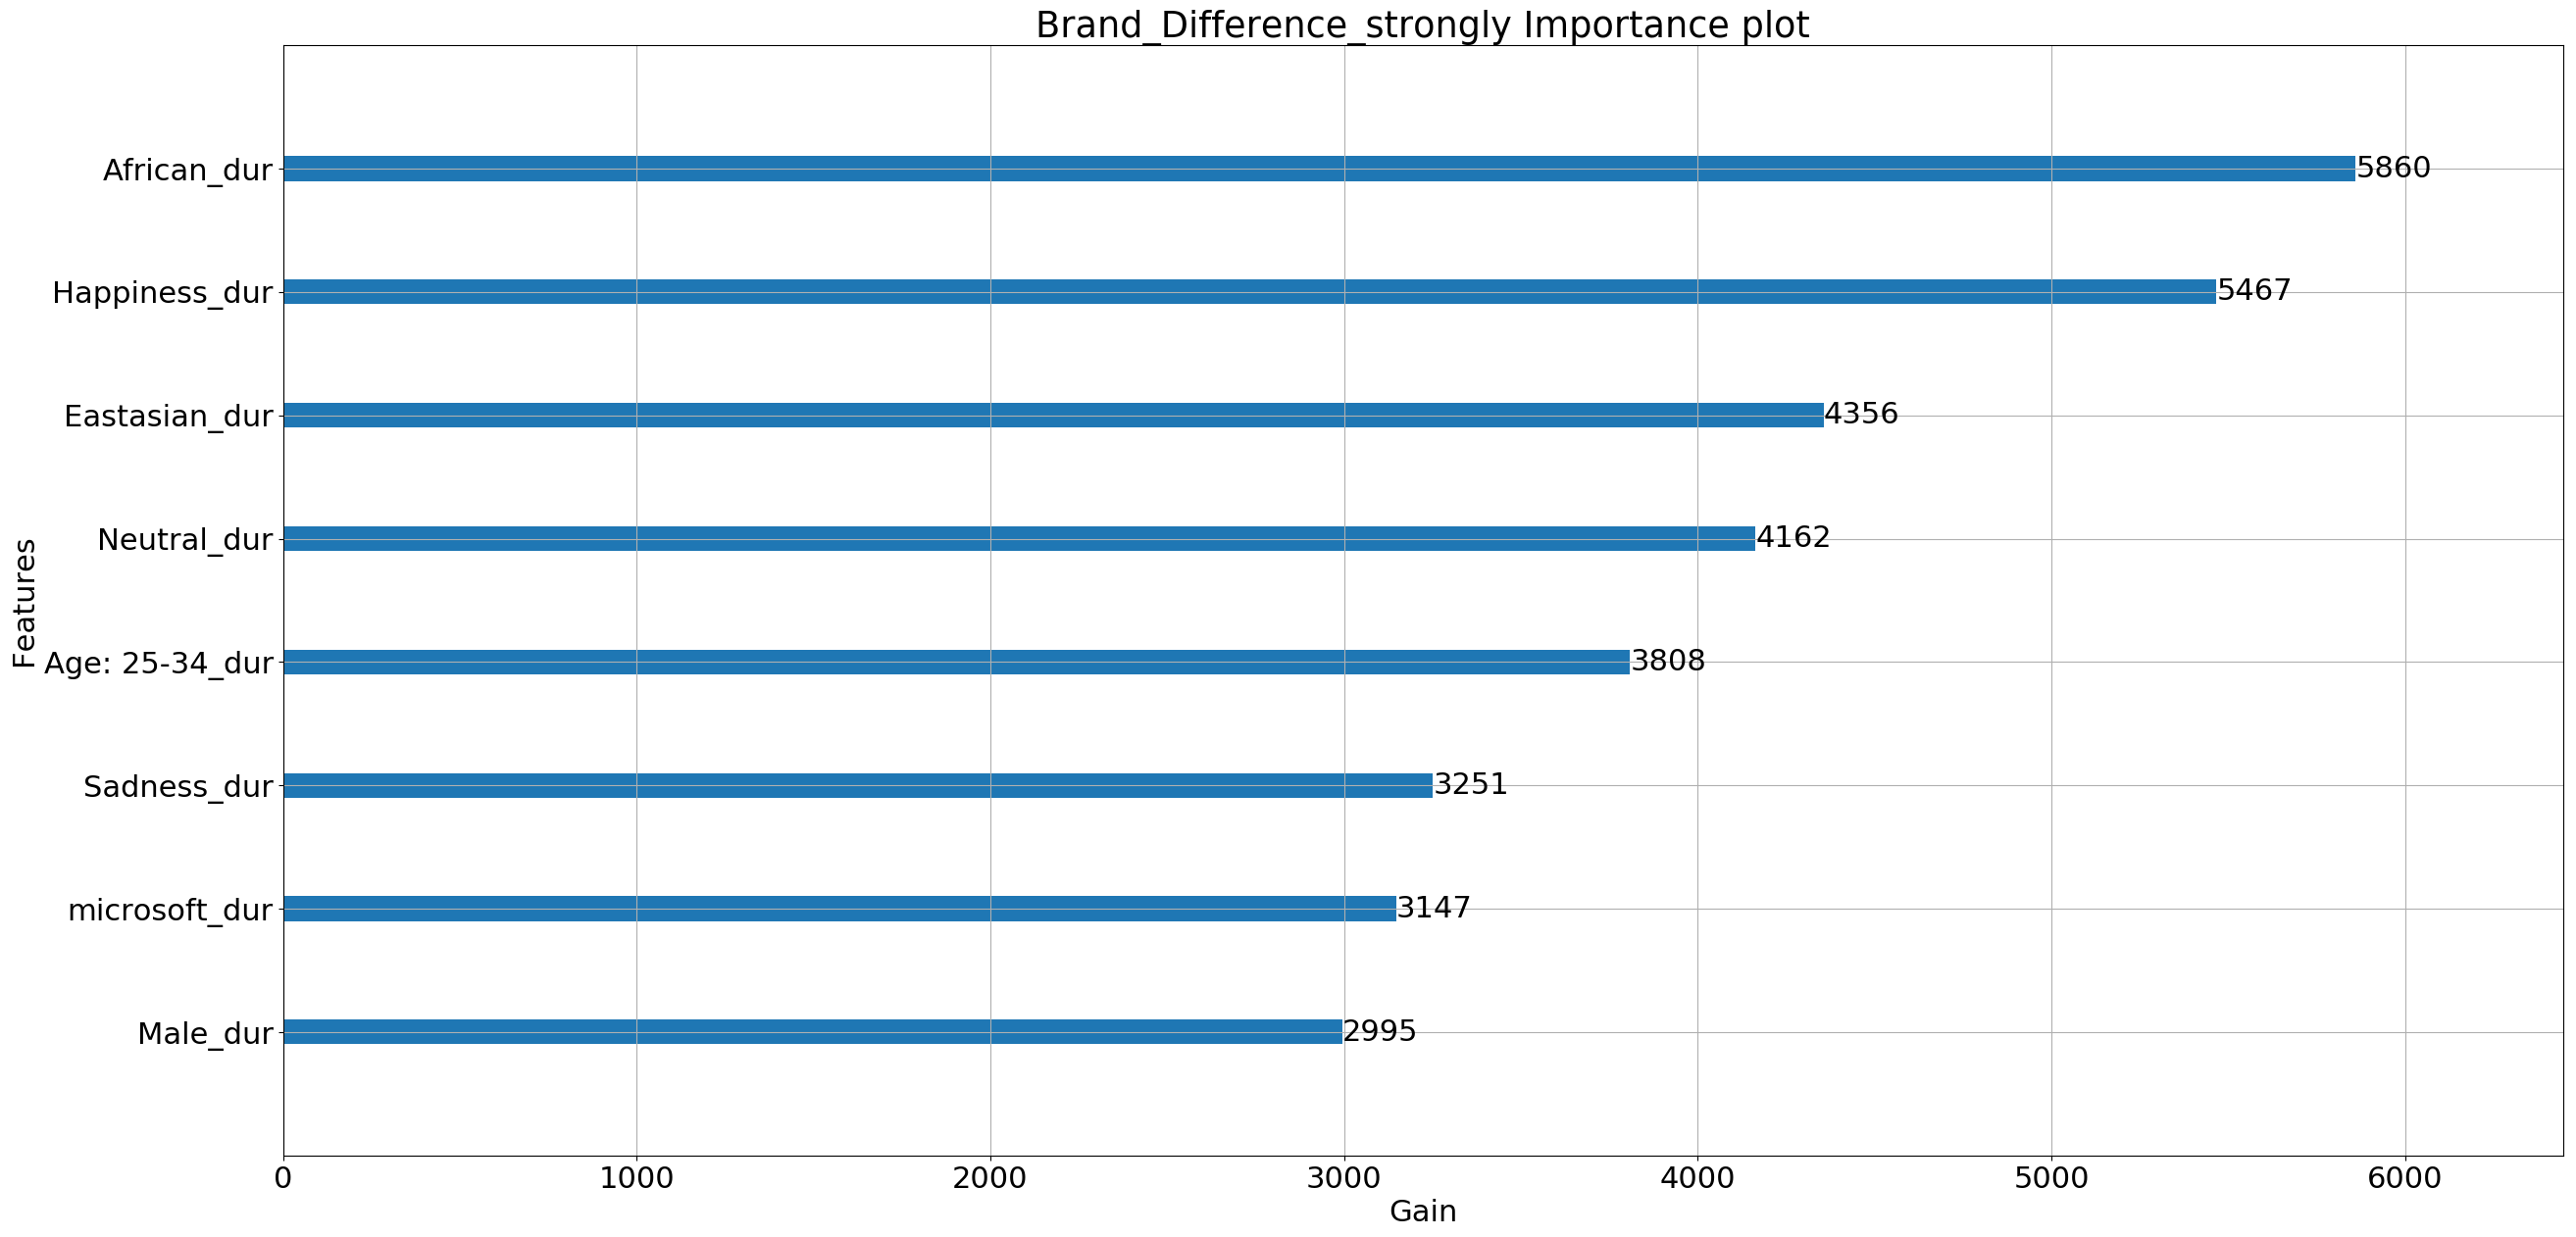

array([['Lenovo_text_dur', 'Hp_text_total_ocr', 'Windows_total_ocr', ...,
        'Macbook_group_dur', 'Apple_dur', 'Currys PCs world_text_dur'],
       ['microsoft_total_ocr', 'Laptop_total_ocr', 'ASUS T102_dur', ...,
        'Apple_dur', 'Macbook_group_dur', 'Currys PCs world_text_dur'],
       ['Windows_last_ocr', 'ASUS T102_dur', 'Asus_text_dur', ...,
        'Macbook_group_dur', 'Currys PCs world_text_dur', 'Apple_dur'],
       ...,
       ['Tablet_total_ocr', 'microsoft_last_ocr', 'Laptop_last_ocr', ...,
        'Macbook_group_dur', 'Apple_dur', 'Currys PCs world_text_dur'],
       ['length_of_ad_15', 'microsoft_last_ocr', 'Lenovo_text_dur', ...,
        'Macbook_group_dur', 'Currys PCs world_text_dur', 'Apple_dur'],
       ['Dell_text_dur', 'microsoft_last_ocr', 'Laptop_last_ocr', ...,
        'Macbook_group_dur', 'Currys PCs world_text_dur', 'Apple_dur']],
      dtype=object)

In [29]:
model_xgb.plot_feature_importance(models_xgb_17,10,y_train_17.columns,X_train_17.columns,savefig=False)

In [30]:
explainer_xgb=[]
shap_values_xgb=[]
for i in tqdm(range(17,26)):
    explainer_xgb.append(shap.TreeExplainer(models_xgb_17[i]))
    shap_values_xgb.append(explainer_xgb[-1].shap_values(X_train_17))
    print(i)

 11%|█         | 1/9 [00:13<01:45, 13.20s/it]

17


 22%|██▏       | 2/9 [00:31<01:42, 14.66s/it]

18


 33%|███▎      | 3/9 [00:44<01:25, 14.33s/it]

19


 44%|████▍     | 4/9 [00:59<01:12, 14.48s/it]

20


 56%|█████▌    | 5/9 [01:13<00:56, 14.21s/it]

21


 67%|██████▋   | 6/9 [01:27<00:42, 14.17s/it]

22


 78%|███████▊  | 7/9 [01:40<00:27, 13.93s/it]

23


 89%|████████▉ | 8/9 [01:55<00:14, 14.07s/it]

24


100%|██████████| 9/9 [02:09<00:00, 14.16s/it]

25


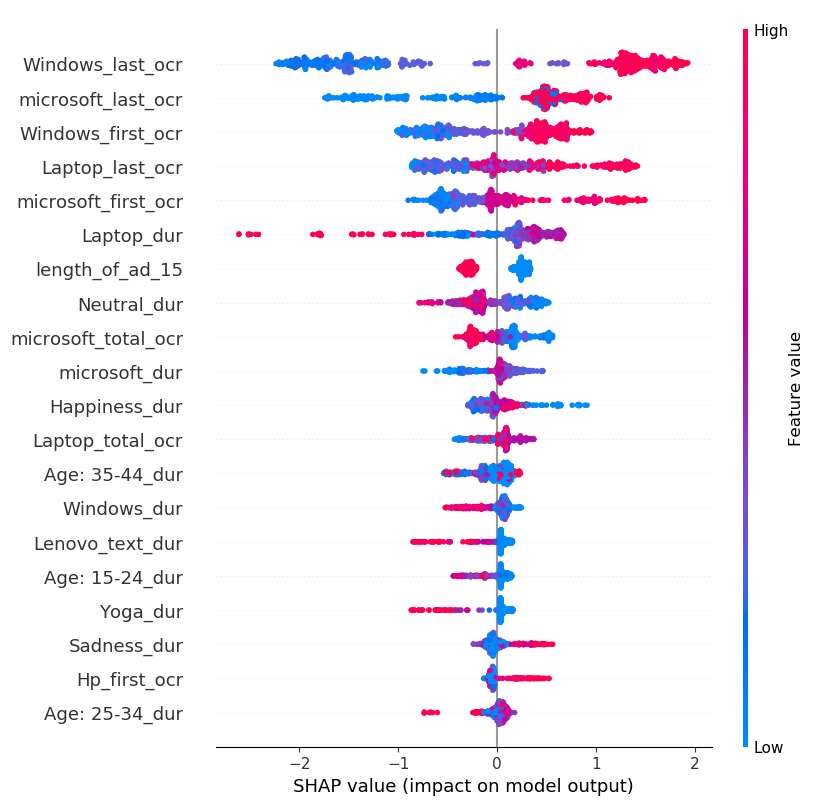

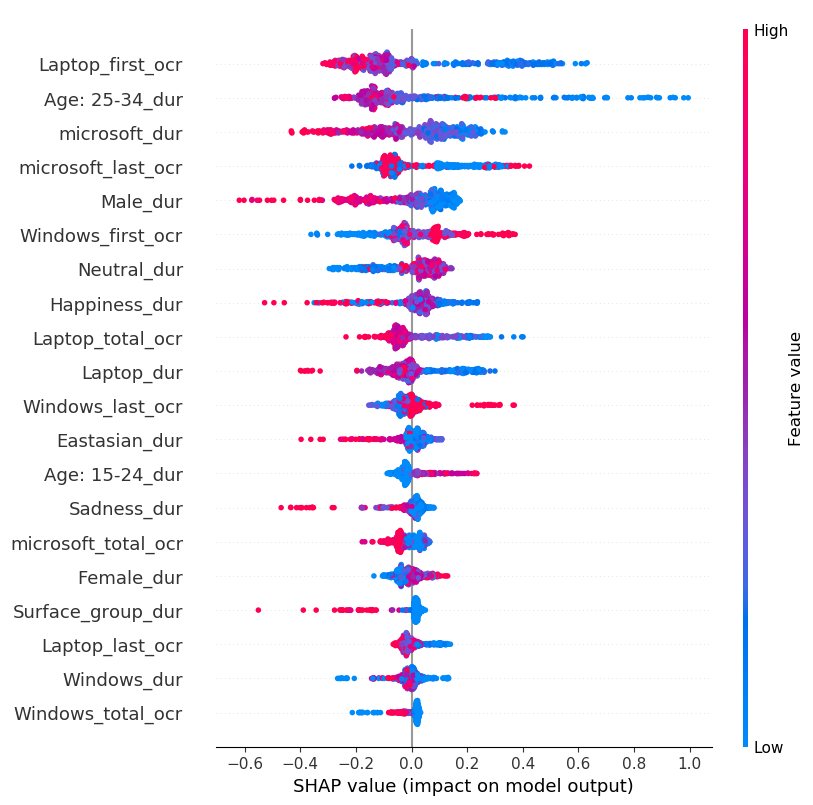

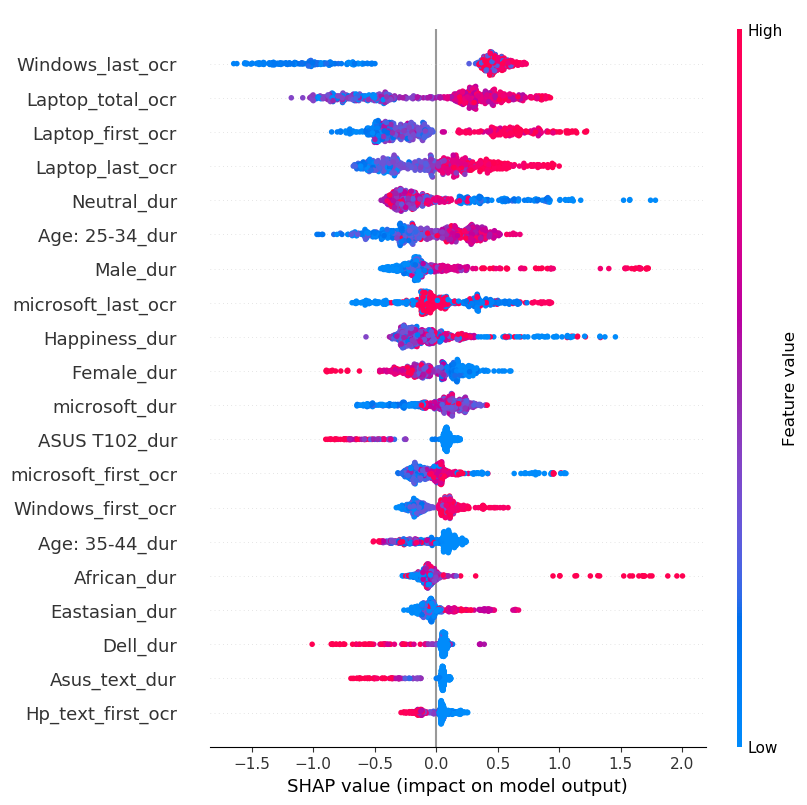

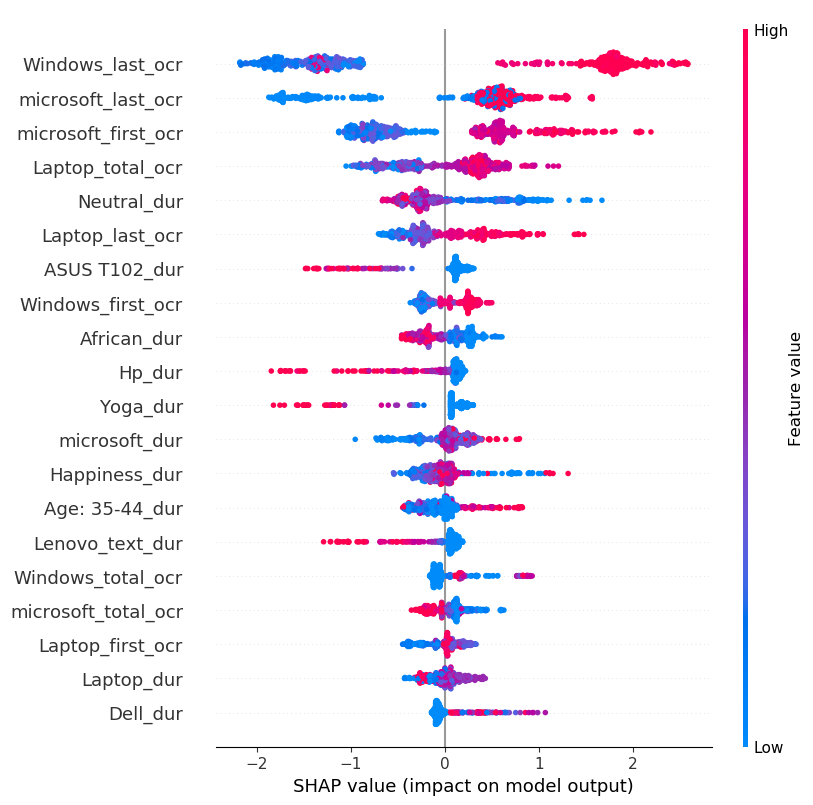

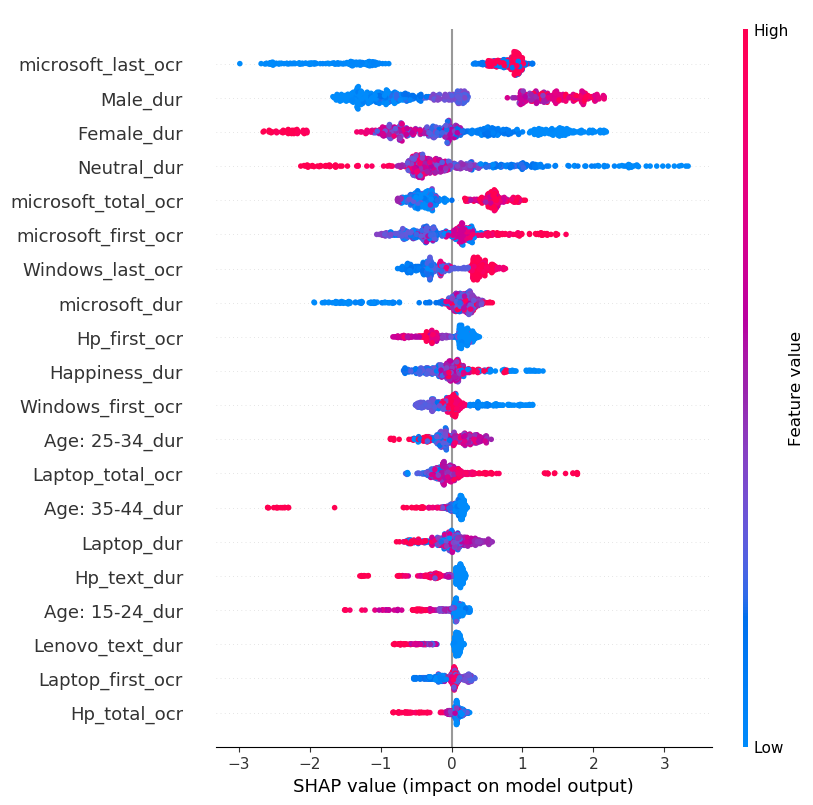

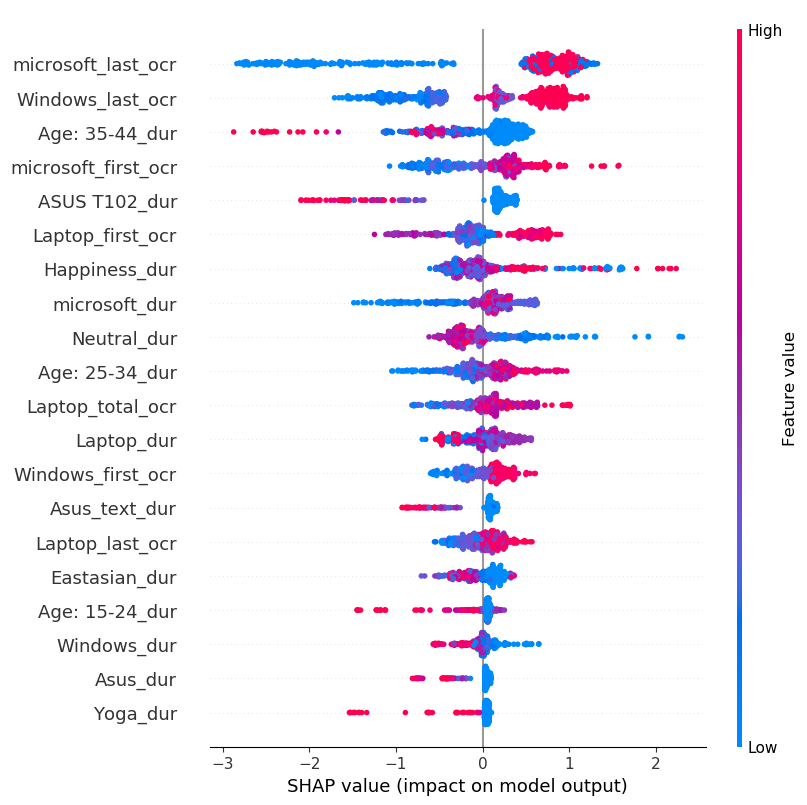

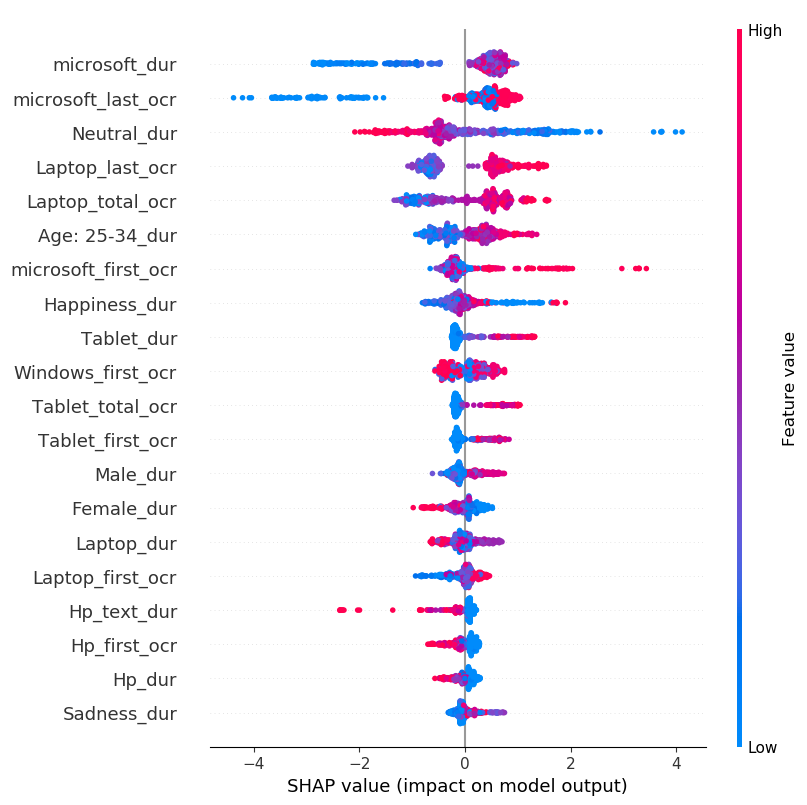

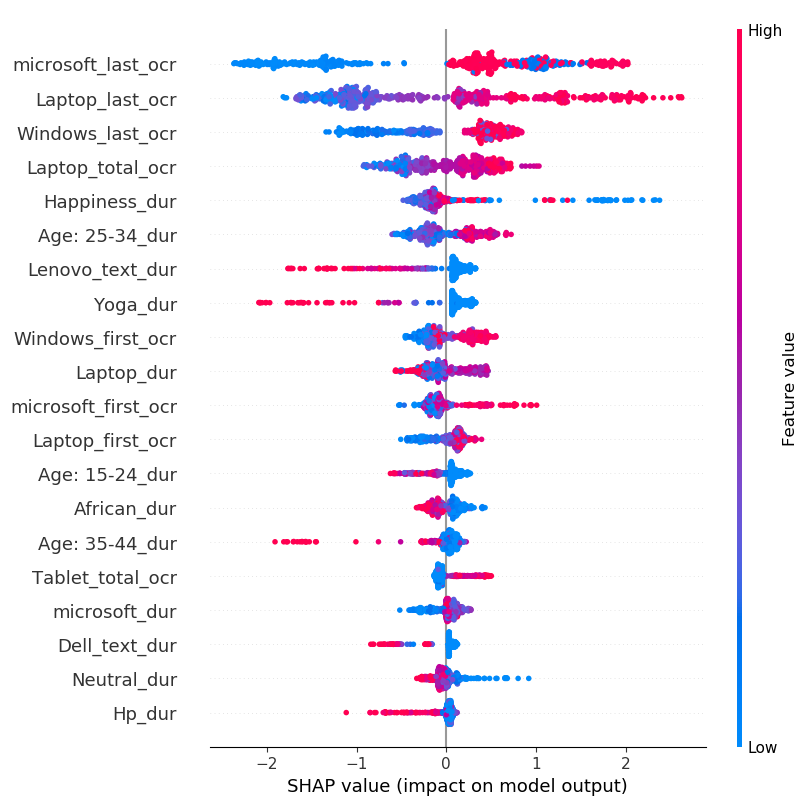

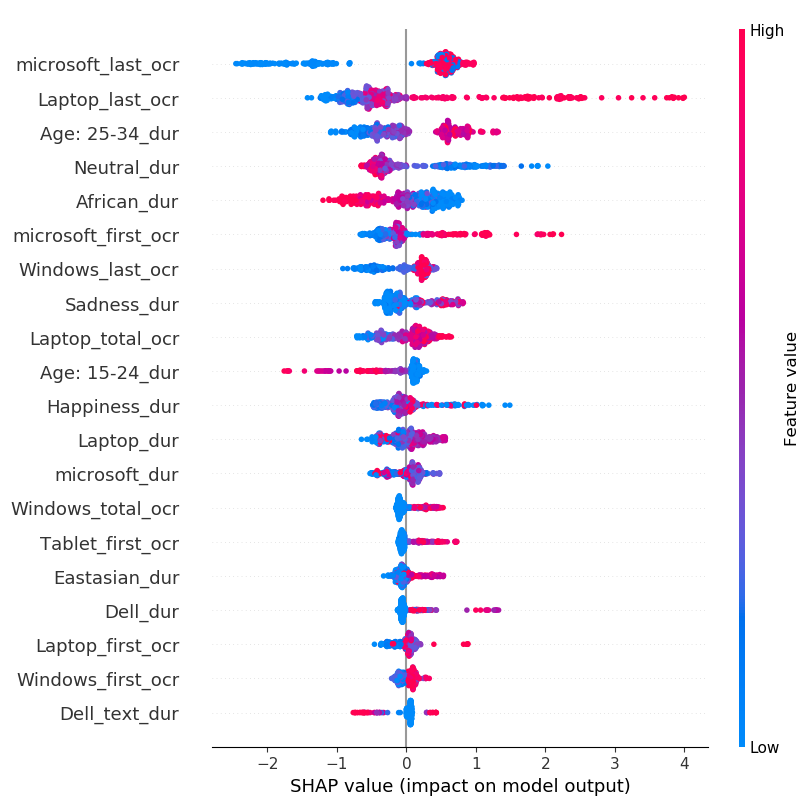

In [31]:
for i in range(9):
    plt.figure()
    shap.summary_plot(shap_values_xgb[i],X_train_17,show=False)
    plt.savefig('./WIth_new_target_variables/shap_plots_26_xgb_software/'+y_train_17.columns[17+i]+'.png',bbox_inches='tight')

In [60]:
X_train_14.to_excel('../../Version_1.01/x_train_14.xlsx')

In [61]:
X_test_14.to_excel('../../Version_1.01/x_test_14.xlsx')
y_train_14.to_excel('../../Version_1.01/y_train_14.xlsx')
y_test_14.to_excel('../../Version_1.01/y_test_14.xlsx')

In [62]:
X_train_4.to_excel('../../Version_1.01/x_train_4.xlsx')
X_test_4.to_excel('../../Version_1.01/x_test_4.xlsx')
y_train_4.to_excel('../../Version_1.01/y_train_4.xlsx')
y_test_4.to_excel('../../Version_1.01/y_test_4.xlsx')